# Objective:Identify which questions asked on Quora are duplicates of questions that have already been asked.

It is a binary classification problem, for a given pair of questions we need to predict if they are duplicate or not.


## 1.Import necessary libraries

In [1]:
pip install distance


Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install fuzzywuzzy


Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc

import re
from nltk.corpus import stopwords
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup

import warnings
warnings.filterwarnings("ignore")
# This package is used for finding longest common subsequence between two strings
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
from fuzzywuzzy import fuzz
from sklearn.manifold import TSNE
# Import the Required lib packages for WORD-Cloud generation
from wordcloud import WordCloud, STOPWORDS
from os import path
from PIL import Image

## 3.Exploratory Data Analysis

### 3.1 Analyzing Data

In [6]:
df= pd.read_csv("train.csv")

In [7]:
print("Number of data points:",df.shape[0])

Number of data points: 404290


In [8]:
df.head()

id  qid1  qid2                                          question1  \
0   0     1     2  What is the step by step guide to invest in sh...   
1   1     3     4  What is the story of Kohinoor (Koh-i-Noor) Dia...   
2   2     5     6  How can I increase the speed of my internet co...   
3   3     7     8  Why am I mentally very lonely? How can I solve...   
4   4     9    10  Which one dissolve in water quikly sugar, salt...   

                                           question2  is_duplicate  
0  What is the step by step guide to invest in sh...             0  
1  What would happen if the Indian government sto...             0  
2  How can Internet speed be increased by hacking...             0  
3  Find the remainder when [math]23^{24}[/math] i...             0  
4            Which fish would survive in salt water?             0

In [9]:
df.describe()

id           qid1           qid2   is_duplicate
count  404290.000000  404290.000000  404290.000000  404290.000000
mean   202144.500000  217243.942418  220955.655337       0.369198
std    116708.614502  157751.700002  159903.182629       0.482588
min         0.000000       1.000000       2.000000       0.000000
25%    101072.250000   74437.500000   74727.000000       0.000000
50%    202144.500000  192182.000000  197052.000000       0.000000
75%    303216.750000  346573.500000  354692.500000       1.000000
max    404289.000000  537932.000000  537933.000000       1.000000

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
id              404290 non-null int64
qid1            404290 non-null int64
qid2            404290 non-null int64
question1       404289 non-null object
question2       404288 non-null object
is_duplicate    404290 non-null int64
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


### 3.2.1 Distribution of data points among output classes


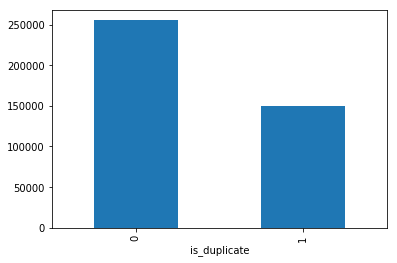

In [11]:
data=df.groupby("is_duplicate")['id']
count=data.count()
count.plot.bar()

In [12]:
print('Total  number of training points:{}'.format(len(df)))

Total  number of training points:404290


In [13]:
print('Question pairs are not Similar (is_duplicate = 0):   {}%'.format(100 - round(df['is_duplicate'].mean()*100, 2)))
print('\n Question pairs are Similar (is_duplicate = 1):  {}%'.format(round(df['is_duplicate'].mean()*100, 2)))

Question pairs are not Similar (is_duplicate = 0):   63.08%

 Question pairs are Similar (is_duplicate = 1):  36.92%


### 3.2.2 Number of unique questions

In [14]:
qids=pd.Series(df['qid1'].tolist()+df['qid2'].tolist())
unique_qs=len(np.unique(qids))
print ('Total number of  Unique Questions are: {}\n'.format(unique_qs))
duplicate_qs=np.sum(qids.value_counts() > 1)
print ('Number of  questions that appear more than one time: {} ({}%)\n'.format(duplicate_qs,duplicate_qs/unique_qs*100))
print ('Max number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

q_vals=qids.value_counts()

q_vals=q_vals.values



Total number of  Unique Questions are: 537933

Number of  questions that appear more than one time: 111780 (20.77953945937505%)

Max number of times a single question is repeated: 157



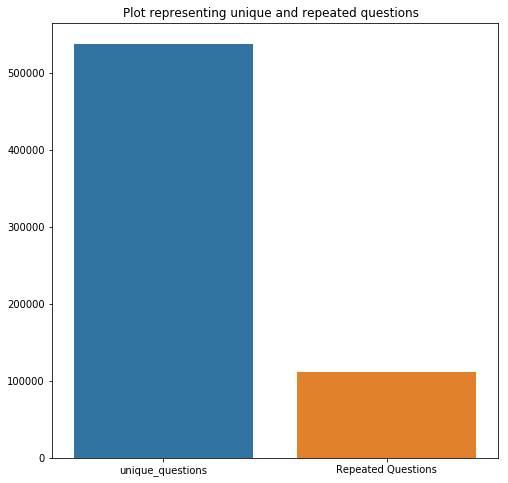

In [15]:
x = ["unique_questions" , "Repeated Questions"]
y =  [unique_qs , duplicate_qs]

plt.figure(figsize=(8, 8))
plt.title ("Plot representing unique and repeated questions  ")
sns.barplot(x,y)
plt.show()


### 3.2.3 Checking for Duplicates

In [16]:
#checking whether there are any repeated pair of questions

pair_duplicates = df[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count().reset_index()

print ("Number of duplicate questions",(pair_duplicates).shape[0] - df.shape[0])

Number of duplicate questions 0


### 3.2.4 Number of occurrences of each question


Maximum number of times a single question is repeated: 157



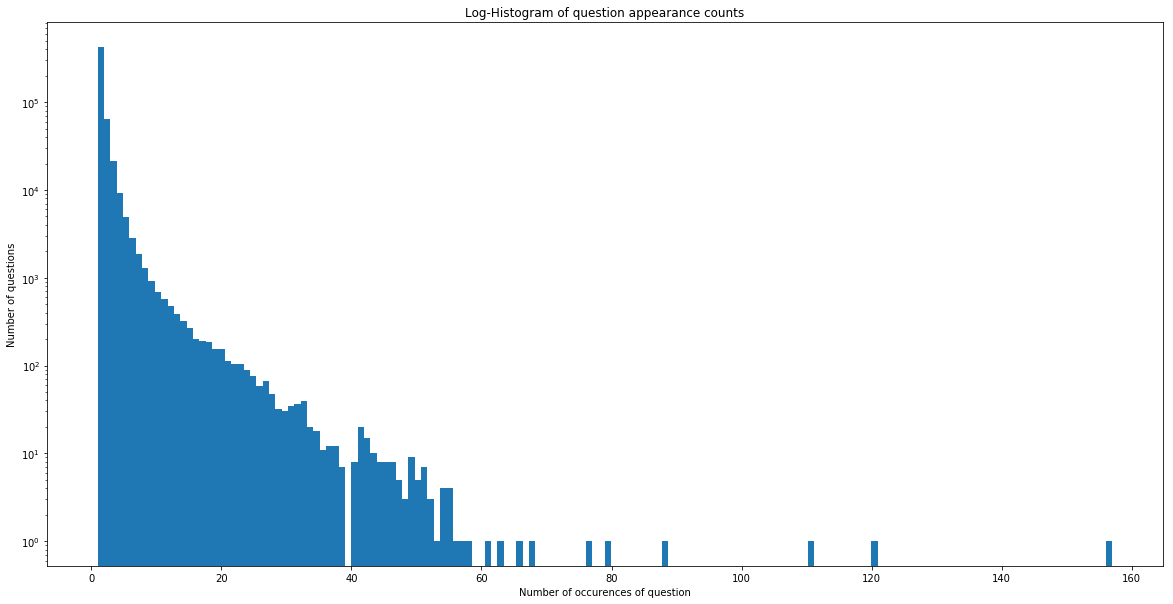

In [17]:
plt.figure(figsize=(20, 10))

plt.hist(qids.value_counts(), bins=160)

plt.yscale('log', nonposy='clip')

plt.title('Log-Histogram of question appearance counts')

plt.xlabel('Number of occurences of question')

plt.ylabel('Number of questions')

print ('Maximum number of times a single question is repeated: {}\n'.format(max(qids.value_counts())))


### 3.2.5 Checking for NULL values


In [18]:
#Checking whether there are any rows with null values
nan_rows = df[df.isnull().any(1)]
print (nan_rows)

            id    qid1    qid2                         question1  \
105780  105780  174363  174364    How can I develop android app?   
201841  201841  303951  174364  How can I create an Android app?   
363362  363362  493340  493341                               NaN   

                                                question2  is_duplicate  
105780                                                NaN             0  
201841                                                NaN             0  
363362  My Chinese name is Haichao Yu. What English na...             0  


In [19]:
# Filling the null values with ' '
df = df.fillna('')
nan_rows = df[df.isnull().any(1)]
print (nan_rows)

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []


## 3.3 Basic Feature Extraction (before cleaning)

Let us now construct a few features like:

    freq_qid1 = Frequency of qid1's
    freq_qid2 = Frequency of qid2's
    q1len = Length of q1
    q2len = Length of q2
    q1_n_words = Number of words in Question 1
    q2_n_words = Number of words in Question 2
    word_Common = (Number of common unique words in Question 1 and      Question 2)
    word_Total =(Total num of words in Question 1 + Total num of words in Question 2)
    word_share = (word_common)/(word_Total)
    freq_q1+freq_q2 = sum total of frequency of qid1 and qid2
    freq_q1-freq_q2 = absolute difference of frequency of qid1 and qid2

In [20]:
if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    df = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
else:
    df['freq_qid1'] = df.groupby('qid1')['qid1'].transform('count') 
    df['freq_qid2'] = df.groupby('qid2')['qid2'].transform('count')
    df['q1len'] = df['question1'].str.len() 
    df['q2len'] = df['question2'].str.len()
    df['q1_n_words'] = df['question1'].apply(lambda row: len(row.split(" ")))
    df['q2_n_words'] = df['question2'].apply(lambda row: len(row.split(" ")))

    def normalized_word_Common(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)
    df['word_Common'] = df.apply(normalized_word_Common, axis=1)

    def normalized_word_Total(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * (len(w1) + len(w2))
    df['word_Total'] = df.apply(normalized_word_Total, axis=1)

    def normalized_word_share(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)/(len(w1) + len(w2))
    df['word_share'] = df.apply(normalized_word_share, axis=1)

    df['freq_q1+q2'] = df['freq_qid1']+df['freq_qid2']
    df['freq_q1-q2'] = abs(df['freq_qid1']-df['freq_qid2'])

    df.to_csv("df_fe_without_preprocessing_train.csv", index=False)

df.head()

id  qid1  qid2                                          question1  \
0   0     1     2  What is the step by step guide to invest in sh...   
1   1     3     4  What is the story of Kohinoor (Koh-i-Noor) Dia...   
2   2     5     6  How can I increase the speed of my internet co...   
3   3     7     8  Why am I mentally very lonely? How can I solve...   
4   4     9    10  Which one dissolve in water quikly sugar, salt...   

                                           question2  is_duplicate  freq_qid1  \
0  What is the step by step guide to invest in sh...             0          1   
1  What would happen if the Indian government sto...             0          4   
2  How can Internet speed be increased by hacking...             0          1   
3  Find the remainder when [math]23^{24}[/math] i...             0          1   
4            Which fish would survive in salt water?             0          3   

   freq_qid2  q1len  q2len  q1_n_words  q2_n_words  word_Common  word_Total  \
0          1     66     57          14          12         10.0        23.0   
1          1     51     88           8          13          4.0        20.0   
2          1     73     59          14          10          4.0        24.0   
3          1     50     65          11           9          0.0        19.0   
4          1     76     39          13           7          2.0        20.0   

   word_share  freq_q1+q2  freq_q1-q2  
0    0.434783           2           0  
1    0.200000           5           3  
2    0.166667           2           0  
3    0.000000           2           0  
4    0.100000           4           2

### 3.3.1 Analysis of some of the extracted features

In [21]:
print ("Minimum length of the questions in question1 : " , min(df['q1_n_words']))

print ("Minimum length of the questions in question2 : " , min(df['q2_n_words']))

print ("Number of Questions with minimum length [question1] :", df[df['q1_n_words']== 1].shape[0])
print ("Number of Questions with minimum length [question2] :", df[df['q2_n_words']== 1].shape[0])

Minimum length of the questions in question1 :  1
Minimum length of the questions in question2 :  1
Number of Questions with minimum length [question1] : 67
Number of Questions with minimum length [question2] : 24


#### 3.3.1.1 word_share

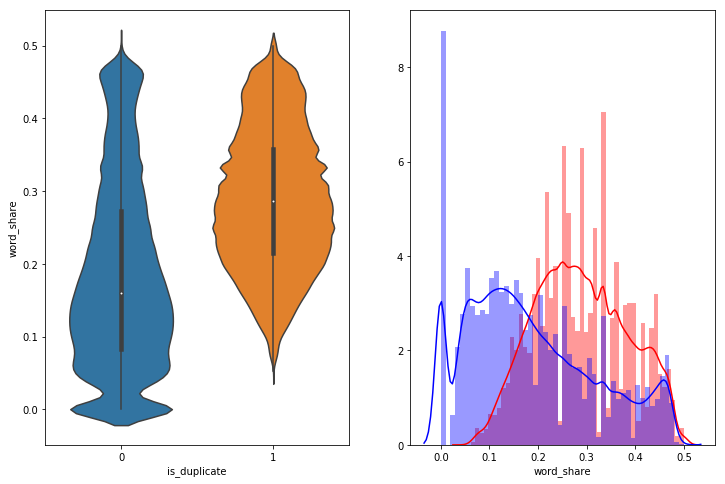

In [22]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_share', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_share'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_share'][0:] , label = "0" , color = 'blue' )
plt.show()

## Objervation:
      1.The distributions for normalized word_share have some overlap on the far right-hand side, i.e., there are quite a lot of questions with high word similarity
      2.The average word share and Common no. of words of qid1 and qid2 is more when they are duplicate(Similar)








### 3.3.1.2 Feature: word_Common

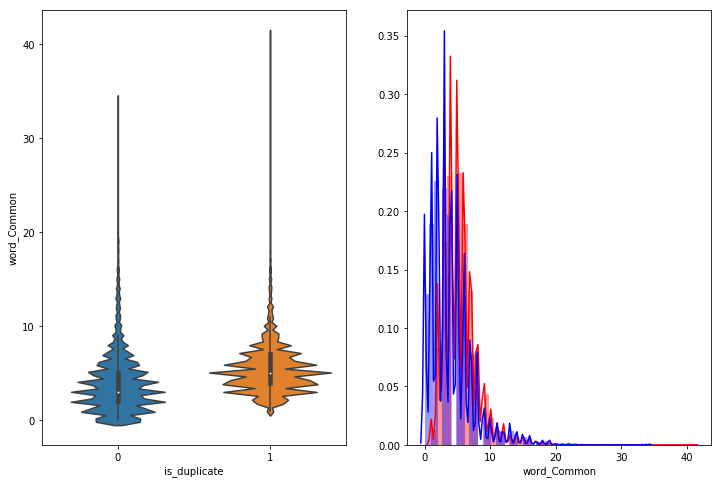

In [23]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_Common', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_Common'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_Common'][0:] , label = "0" , color = 'blue' )
plt.show()

### Objervation:
    The distributions of the word_Common feature in similar and non-similar questions are highly overlapping





In [24]:
if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    df = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
    df = df.fillna('')
    df.head()
else:
    print("get df_fe_without_preprocessing_train.csv from drive or run the previous notebook")

In [25]:
df.head()

id  qid1  qid2                                          question1  \
0   0     1     2  What is the step by step guide to invest in sh...   
1   1     3     4  What is the story of Kohinoor (Koh-i-Noor) Dia...   
2   2     5     6  How can I increase the speed of my internet co...   
3   3     7     8  Why am I mentally very lonely? How can I solve...   
4   4     9    10  Which one dissolve in water quikly sugar, salt...   

                                           question2  is_duplicate  freq_qid1  \
0  What is the step by step guide to invest in sh...             0          1   
1  What would happen if the Indian government sto...             0          4   
2  How can Internet speed be increased by hacking...             0          1   
3  Find the remainder when [math]23^{24}[/math] i...             0          1   
4            Which fish would survive in salt water?             0          3   

   freq_qid2  q1len  q2len  q1_n_words  q2_n_words  word_Common  word_Total  \
0          1     66     57          14          12         10.0        23.0   
1          1     51     88           8          13          4.0        20.0   
2          1     73     59          14          10          4.0        24.0   
3          1     50     65          11           9          0.0        19.0   
4          1     76     39          13           7          2.0        20.0   

   word_share  freq_q1+q2  freq_q1-q2  
0    0.434783           2           0  
1    0.200000           5           3  
2    0.166667           2           0  
3    0.000000           2           0  
4    0.100000           4           2

## 3.4 Preprocessing of Text

*   Preprocessing:
     *  Removing html tags
     *  Removing Punctuations
     *  Performing stemming
     *  Removing Stopwords
     *  Expanding contractions etc.




In [26]:
  import nltk
  nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /home/cnlp2/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [27]:
# To get the results in 4 decemal points
SAFE_DIV = 0.0001 

STOP_WORDS = stopwords.words("english")


def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    
    porter = PorterStemmer()
    pattern = re.compile('\W')
    
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)
    
    
    if type(x) == type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()
               
    
    return x

## 3.5 Advanced Feature Extraction (NLP and Fuzzy Features)


Definition:

   Token: You get a token by splitting sentence a space
   Stop_Word : stop words as per NLTK.
   Word : A token that is not a stop_word
Features:

  * cwc_min : Ratio of common_word_count to min lenghth of word count of Q1 and Q2
  
  cwc_min = common_word_count / (min(len(q1_words), len(q2_words))

* cwc_max : Ratio of common_word_count to max lenghth of word count of Q1 and Q2

  cwc_max = common_word_count / (max(len(q1_words), len(q2_words))

* csc_min : Ratio of common_stop_count to min lenghth of stop count of Q1 and Q2 

  csc_min = common_stop_count / (min(len(q1_stops), len(q2_stops))

* csc_max : Ratio of common_stop_count to max lenghth of stop count of Q1 and Q2

   csc_max = common_stop_count / (max(len(q1_stops), len(q2_stops))

* ctc_min : Ratio of common_token_count to min lenghth of token count of Q1 and Q2

  ctc_min = common_token_count / (min(len(q1_tokens), len(q2_tokens))


* ctc_max : Ratio of common_token_count to max lenghth of token count of Q1 and Q2

  ctc_max = common_token_count / (max(len(q1_tokens), len(q2_tokens))


* last_word_eq : Check if Last word of both questions is equal or not

  last_word_eq = int(q1_tokens[-1] == q2_tokens[-1])


* first_word_eq : Check if First word of both questions is equal or not

   first_word_eq = int(q1_tokens[0] == q2_tokens[0])


* abs_len_diff : Abs. length difference

  abs_len_diff = abs(len(q1_tokens) - len(q2_tokens))


* mean_len : Average Token Length of both Questions
  
  mean_len = (len(q1_tokens) + len(q2_tokens))/2


* fuzz_ratio : https://github.com/seatgeek/fuzzywuzzy#usage         http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/


* fuzz_partial_ratio : https://github.com/seatgeek/fuzzywuzzy#usage http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/


* token_sort_ratio : https://github.com/seatgeek/fuzzywuzzy#usage http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/

* token_set_ratio : https://github.com/seatgeek/fuzzywuzzy#usage http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/

* longest_substr_ratio : Ratio of length longest common substring to min lenghth of token count of Q1 and Q2

  longest_substr_ratio = len(longest common substring) / (min(len(q1_tokens), len(q2_tokens))


In [28]:
def get_token_features(q1, q2):
    token_features = [0.0]*10
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    token_features[9] = (len(q1_tokens) + len(q2_tokens))/2
    return token_features

# get the Longest Common sub string

def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)

def extract_features(df):
    # preprocessing each question
    df["question1"] = df["question1"].fillna("").apply(preprocess)
    df["question2"] = df["question2"].fillna("").apply(preprocess)

    print("token features...")
    
    # Merging Features with dataset
    
    token_features = df.apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1)
    
    df["cwc_min"]       = list(map(lambda x: x[0], token_features))
    df["cwc_max"]       = list(map(lambda x: x[1], token_features))
    df["csc_min"]       = list(map(lambda x: x[2], token_features))
    df["csc_max"]       = list(map(lambda x: x[3], token_features))
    df["ctc_min"]       = list(map(lambda x: x[4], token_features))
    df["ctc_max"]       = list(map(lambda x: x[5], token_features))
    df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
    df["first_word_eq"] = list(map(lambda x: x[7], token_features))
    df["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
    df["mean_len"]      = list(map(lambda x: x[9], token_features))
   
    #Computing Fuzzy Features and Merging with Dataset
    print("fuzzy features..")

    df["token_set_ratio"]       = df.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    # The token sort approach involves tokenizing the string in question, sorting the tokens alphabetically, and 
    # then joining them back into a string We then compare the transformed strings with a simple ratio().
    df["token_sort_ratio"]      = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    df["fuzz_ratio"]            = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    df["fuzz_partial_ratio"]    = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    df["longest_substr_ratio"]  = df.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)
    return df

In [32]:
if os.path.isfile('nlp_features_train.csv'):
    df = pd.read_csv("nlp_features_train.csv",encoding='latin-1')
    df.fillna('')
else:
    print("Extracting features for train:")
    df = pd.read_csv("train.csv")
    df = extract_features(df)
    df.to_csv("nlp_features_train.csv", index=False)
df.head(2)

Extracting features for train:
token features...
fuzzy features..


id  qid1  qid2                                          question1  \
0   0     1     2  what is the step by step guide to invest in sh...   
1   1     3     4  what is the story of kohinoor  koh i noor  dia...   

                                           question2  is_duplicate   cwc_min  \
0  what is the step by step guide to invest in sh...             0  0.999980   
1  what would happen if the indian government sto...             0  0.799984   

    cwc_max   csc_min   csc_max  ...   ctc_max  last_word_eq  first_word_eq  \
0  0.833319  0.999983  0.999983  ...  0.785709           0.0            1.0   
1  0.399996  0.749981  0.599988  ...  0.466664           0.0            1.0   

   abs_len_diff  mean_len  token_set_ratio  token_sort_ratio  fuzz_ratio  \
0           2.0      13.0              100                93          93   
1           5.0      12.5               86                63          66   

   fuzz_partial_ratio  longest_substr_ratio  
0                 100              0.982759  
1                  75              0.596154  

[2 rows x 21 columns]

### 3.5.1 Analysis of extracted features

* Creating Word Cloud of Duplicates and Non-Duplicates Question pairs
* We can observe the most frequent occuring words

In [33]:
df_duplicate = df[df['is_duplicate'] == 1]
dfp_nonduplicate = df[df['is_duplicate'] == 0]

# Converting 2d array of q1 and q2 and flatten the array: like {{1,2},{3,4}} to {1,2,3,4}
p = np.dstack([df_duplicate["question1"], df_duplicate["question2"]]).flatten()
n = np.dstack([dfp_nonduplicate["question1"], dfp_nonduplicate["question2"]]).flatten()

print ("Number of data points in class 1 (duplicate pairs) :",len(p))
print ("Number of data points in class 0 (non duplicate pairs) :",len(n))

#Saving the np array into a text file
np.savetxt('train_p.txt', p, delimiter=' ', fmt='%s')
np.savetxt('train_n.txt', n, delimiter=' ', fmt='%s')


Number of data points in class 1 (duplicate pairs) : 298526
Number of data points in class 0 (non duplicate pairs) : 510054


In [34]:
d = path.dirname('.')

textp_w = open(path.join(d, 'train_p.txt')).read()
textn_w = open(path.join(d, 'train_n.txt')).read()
stopwords = set(STOPWORDS)
stopwords.add("said")
stopwords.add("br")
stopwords.add(" ")
stopwords.remove("not")
stopwords.remove("no")
stopwords.remove("like")
print ("Total number of words in duplicate pair questions :",len(textp_w))
print ("Total number of words in non duplicate pair questions :",len(textn_w))

Total number of words in duplicate pair questions : 16109886
Total number of words in non duplicate pair questions : 33193067


 #### Word Clouds generated from duplicate pair question's text

Word Cloud for Duplicate Question pairs


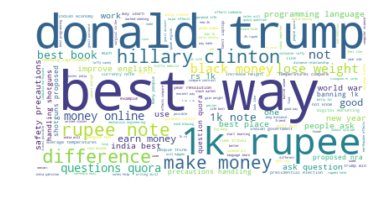

In [35]:
wc = WordCloud(background_color="white", max_words=len(textp_w), stopwords=stopwords)
wc.generate(textp_w)
print ("Word Cloud for Duplicate Question pairs")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

#### Word Clouds generated from non duplicate pair question's text



Word Cloud for non-Duplicate Question pairs:


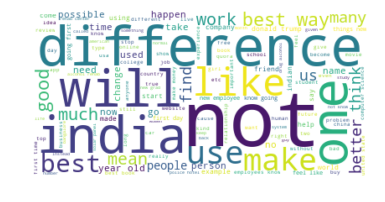

In [36]:
wc = WordCloud(background_color="white", max_words=len(textn_w),stopwords=stopwords)
# generate word cloud
wc.generate(textn_w)
print ("Word Cloud for non-Duplicate Question pairs:")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

#### 3.5.1.2 Pair plot of features ['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio']


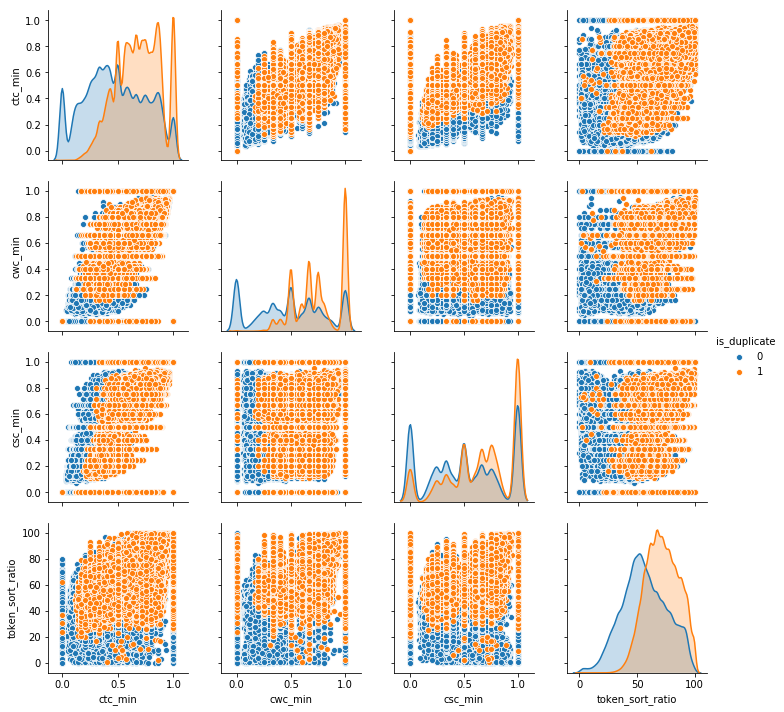

In [37]:
n = df.shape[0]
sns.pairplot(df[['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio', 'is_duplicate']][0:n], hue='is_duplicate', vars=['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'])
plt.show()

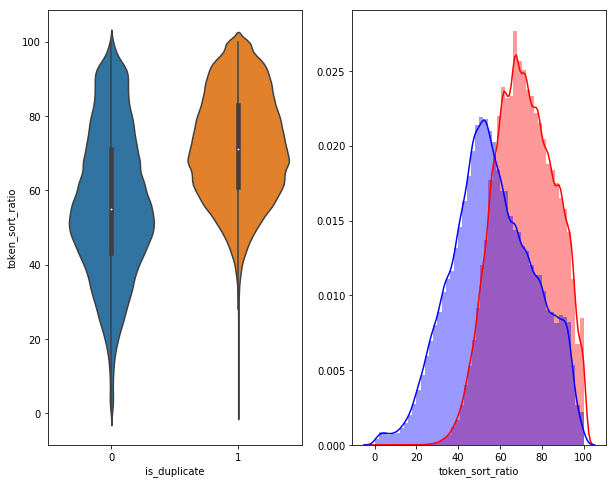

In [38]:
# Distribution of the token_sort_ratio
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'token_sort_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['token_sort_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['token_sort_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

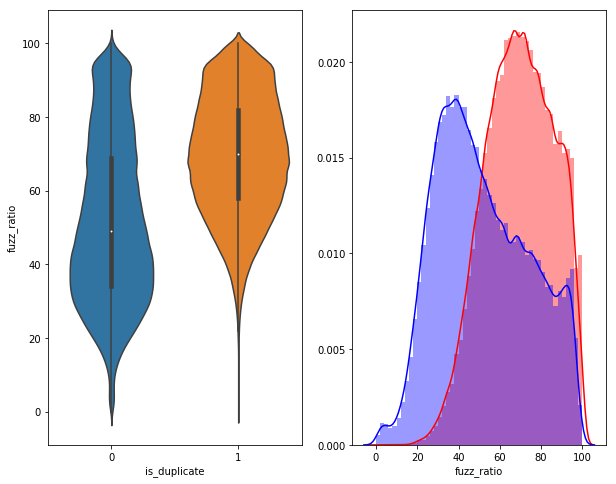

In [39]:
#Distribution of Fuzz_ratio
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'fuzz_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['fuzz_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['fuzz_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()


## 3.5.2 Visualization using TSNE

In [40]:
from sklearn.preprocessing import MinMaxScaler

dfp_subsampled = df[0:5000]
X = MinMaxScaler().fit_transform(dfp_subsampled[['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , 'last_word_eq', 'first_word_eq' , 'abs_len_diff' , 'mean_len' , 'token_set_ratio' , 'token_sort_ratio' ,  'fuzz_ratio' , 'fuzz_partial_ratio' , 'longest_substr_ratio']])
y = dfp_subsampled['is_duplicate'].values

In [41]:
tsne2d = TSNE(
    n_components=2,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.040s...
[t-SNE] Computed neighbors for 5000 samples in 0.233s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.130446
[t-SNE] Computed conditional probabilities in 0.212s
[t-SNE] Iteration 50: error = 81.2911148, gradient norm = 0.0457501 (50 iterations in 1.620s)
[t-SNE] Iteration 100: error = 70.6044159, gradient norm = 0.0086692 (50 iterations in 1.109s)
[t-SNE] Iteration 150: error = 68.9124908, gradient norm = 0.0056016 (50 iterations in 1.064s)
[t-SNE] Iteration 200: error = 68.1010742, gradient norm = 0.0047585 (50 iterations in 1.106s)
[t-SNE] Iteration 250: error = 67.5907974, gradient norm = 0.0033576

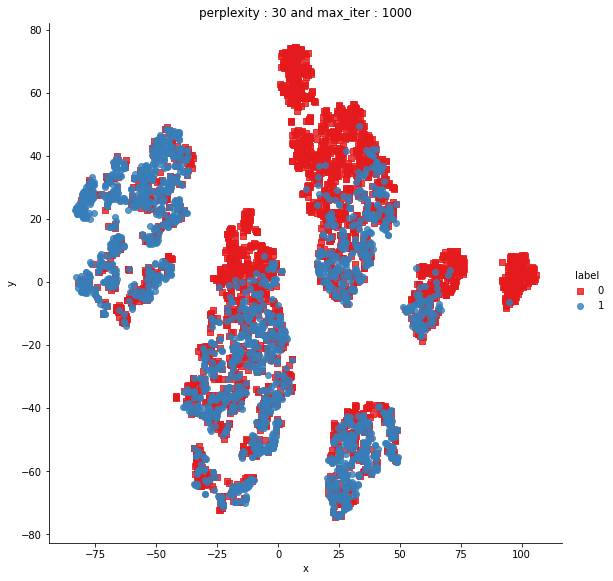

In [42]:
df = pd.DataFrame({'x':tsne2d[:,0], 'y':tsne2d[:,1] ,'label':y})

sns.lmplot(data=df, x='x', y='y', hue='label', fit_reg=False, size=8,palette="Set1",markers=['s','o'])
plt.title("perplexity : {} and max_iter : {}".format(30, 1000))
plt.show()

## 3.6 Featurizing text data with tfidf weighted word-vectors

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
warnings.filterwarnings("ignore")
import sys
import os 
import pandas as pd
import numpy as np
from tqdm import tqdm
import spacy

In [45]:

df = pd.read_csv("train.csv")
df['question1'] = df['question1'].apply(lambda x: str(x))
df['question2'] = df['question2'].apply(lambda x: str(x))
df.head()

id  qid1  qid2                                          question1  \
0   0     1     2  What is the step by step guide to invest in sh...   
1   1     3     4  What is the story of Kohinoor (Koh-i-Noor) Dia...   
2   2     5     6  How can I increase the speed of my internet co...   
3   3     7     8  Why am I mentally very lonely? How can I solve...   
4   4     9    10  Which one dissolve in water quikly sugar, salt...   

                                           question2  is_duplicate  
0  What is the step by step guide to invest in sh...             0  
1  What would happen if the Indian government sto...             0  
2  How can Internet speed be increased by hacking...             0  
3  Find the remainder when [math]23^{24}[/math] i...             0  
4            Which fish would survive in salt water?             0

In [46]:
df.head()


id  qid1  qid2                                          question1  \
0   0     1     2  What is the step by step guide to invest in sh...   
1   1     3     4  What is the story of Kohinoor (Koh-i-Noor) Dia...   
2   2     5     6  How can I increase the speed of my internet co...   
3   3     7     8  Why am I mentally very lonely? How can I solve...   
4   4     9    10  Which one dissolve in water quikly sugar, salt...   

                                           question2  is_duplicate  
0  What is the step by step guide to invest in sh...             0  
1  What would happen if the Indian government sto...             0  
2  How can Internet speed be increased by hacking...             0  
3  Find the remainder when [math]23^{24}[/math] i...             0  
4            Which fish would survive in salt water?             0

In [47]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
# merge texts
questions = list(df['question1']) + list(df['question2'])

tfidf = TfidfVectorizer(lowercase=False,)
tfidf.fit_transform(questions)

# dict key:word and value:tf-idf score
word2tfidf = dict(zip(tfidf.get_feature_names(), tfidf.idf_))

* After we find TF-IDF scores, we convert each question to a weighted average of word2vec vectors by these scores.
* here we use a pre-trained GLOVE model which comes free with "Spacy". https://spacy.io/usage/vectors-similarity
* It is trained on Wikipedia and therefore, it is stronger in terms of word semantics.

In [54]:
import en_core_web_sm
nlp = en_core_web_sm.load()

vecs1 = []
# tqdm is used to print the progress bar
for qu1 in tqdm(list(df['question1'])):
    doc1 = nlp(qu1) 
    # 96 is the number of dimensions of vectors 
    mean_vec1 = np.zeros([len(doc1), 96])
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)
df['q1_feats_m'] = list(vecs1)





  0%|          | 0/404290 [00:00<?, ?it/s]



  0%|          | 15/404290 [00:00<47:48, 140.95it/s]



  0%|          | 29/404290 [00:00<48:26, 139.07it/s]



  0%|          | 42/404290 [00:00<49:28, 136.17it/s]



  0%|          | 56/404290 [00:00<49:32, 135.98it/s]



  0%|          | 71/404290 [00:00<48:40, 138.42it/s]



  0%|          | 86/404290 [00:00<48:07, 139.98it/s]



  0%|          | 101/404290 [00:00<48:07, 139.97it/s]



  0%|          | 114/404290 [00:00<49:32, 135.95it/s]



  0%|          | 128/404290 [00:00<49:10, 136.98it/s]



  0%|          | 142/404290 [00:01<50:04, 134.52it/s]



  0%|          | 156/404290 [00:01<49:43, 135.47it/s]



  0%|          | 170/404290 [00:01<49:29, 136.09it/s]



  0%|          | 185/404290 [00:01<48:11, 139.75it/s]



  0%|          | 200/404290 [00:01<47:49, 140.82it/s]



  0%|          | 215/404290 [00:01<49:44, 135.41it/s]



  0%|          | 231/404290 [00:01<48:08, 139.91it/s]



  0%|          | 246/404290 [00:01<49:44, 13

  1%|          | 3654/404290 [00:24<42:56, 155.49it/s]



  1%|          | 3670/404290 [00:24<42:52, 155.75it/s]



  1%|          | 3686/404290 [00:24<43:18, 154.15it/s]



  1%|          | 3702/404290 [00:24<42:51, 155.76it/s]



  1%|          | 3718/404290 [00:25<42:47, 156.05it/s]



  1%|          | 3734/404290 [00:25<42:53, 155.66it/s]



  1%|          | 3750/404290 [00:25<43:19, 154.07it/s]



  1%|          | 3766/404290 [00:25<43:27, 153.63it/s]



  1%|          | 3782/404290 [00:25<43:11, 154.52it/s]



  1%|          | 3799/404290 [00:25<42:35, 156.71it/s]



  1%|          | 3815/404290 [00:25<43:10, 154.59it/s]



  1%|          | 3831/404290 [00:25<43:45, 152.51it/s]



  1%|          | 3848/404290 [00:25<42:57, 155.36it/s]



  1%|          | 3865/404290 [00:25<42:28, 157.15it/s]



  1%|          | 3881/404290 [00:26<43:31, 153.30it/s]



  1%|          | 3897/404290 [00:26<43:39, 152.83it/s]



  1%|          | 3913/404290 [00:26<43:20, 153.94it/s]



  1%|         

  2%|▏         | 7430/404290 [00:49<43:19, 152.68it/s]



  2%|▏         | 7446/404290 [00:49<43:27, 152.21it/s]



  2%|▏         | 7462/404290 [00:49<42:52, 154.28it/s]



  2%|▏         | 7478/404290 [00:49<42:58, 153.92it/s]



  2%|▏         | 7494/404290 [00:49<42:46, 154.63it/s]



  2%|▏         | 7510/404290 [00:49<42:21, 156.11it/s]



  2%|▏         | 7526/404290 [00:49<42:09, 156.87it/s]



  2%|▏         | 7542/404290 [00:49<41:59, 157.45it/s]



  2%|▏         | 7558/404290 [00:49<42:17, 156.36it/s]



  2%|▏         | 7575/404290 [00:49<41:43, 158.44it/s]



  2%|▏         | 7592/404290 [00:50<41:33, 159.07it/s]



  2%|▏         | 7609/404290 [00:50<41:22, 159.81it/s]



  2%|▏         | 7625/404290 [00:50<42:40, 154.93it/s]



  2%|▏         | 7642/404290 [00:50<42:00, 157.35it/s]



  2%|▏         | 7658/404290 [00:50<42:44, 154.68it/s]



  2%|▏         | 7674/404290 [00:50<43:01, 153.65it/s]



  2%|▏         | 7690/404290 [00:50<43:09, 153.14it/s]



  2%|▏        

  3%|▎         | 11216/404290 [01:13<41:42, 157.08it/s]



  3%|▎         | 11232/404290 [01:13<41:30, 157.81it/s]



  3%|▎         | 11249/404290 [01:13<41:18, 158.59it/s]



  3%|▎         | 11266/404290 [01:13<41:07, 159.29it/s]



  3%|▎         | 11282/404290 [01:13<41:20, 158.45it/s]



  3%|▎         | 11299/404290 [01:13<40:55, 160.02it/s]



  3%|▎         | 11316/404290 [01:13<40:34, 161.41it/s]



  3%|▎         | 11333/404290 [01:14<40:37, 161.19it/s]



  3%|▎         | 11350/404290 [01:14<40:18, 162.49it/s]



  3%|▎         | 11367/404290 [01:14<40:55, 160.01it/s]



  3%|▎         | 11384/404290 [01:14<41:15, 158.73it/s]



  3%|▎         | 11401/404290 [01:14<41:10, 159.02it/s]



  3%|▎         | 11417/404290 [01:14<41:09, 159.10it/s]



  3%|▎         | 11433/404290 [01:14<41:37, 157.31it/s]



  3%|▎         | 11449/404290 [01:14<41:45, 156.80it/s]



  3%|▎         | 11465/404290 [01:14<42:02, 155.75it/s]



  3%|▎         | 11481/404290 [01:14<41:55, 156.18it/s]


  4%|▎         | 15031/404290 [01:37<41:40, 155.64it/s]



  4%|▎         | 15047/404290 [01:37<41:48, 155.20it/s]



  4%|▎         | 15063/404290 [01:37<41:33, 156.10it/s]



  4%|▎         | 15079/404290 [01:37<41:28, 156.38it/s]



  4%|▎         | 15095/404290 [01:37<41:28, 156.37it/s]



  4%|▎         | 15111/404290 [01:37<41:39, 155.69it/s]



  4%|▎         | 15127/404290 [01:37<41:43, 155.43it/s]



  4%|▎         | 15143/404290 [01:38<41:26, 156.50it/s]



  4%|▎         | 15159/404290 [01:38<47:07, 137.61it/s]



  4%|▍         | 15174/404290 [01:38<48:36, 133.41it/s]



  4%|▍         | 15189/404290 [01:38<47:08, 137.58it/s]



  4%|▍         | 15206/404290 [01:38<44:53, 144.43it/s]



  4%|▍         | 15222/404290 [01:38<44:12, 146.67it/s]



  4%|▍         | 15238/404290 [01:38<43:10, 150.16it/s]



  4%|▍         | 15254/404290 [01:38<44:44, 144.91it/s]



  4%|▍         | 15269/404290 [01:38<45:05, 143.80it/s]



  4%|▍         | 15286/404290 [01:39<43:07, 150.32it/s]


  5%|▍         | 18801/404290 [02:01<41:06, 156.29it/s]



  5%|▍         | 18817/404290 [02:01<41:08, 156.14it/s]



  5%|▍         | 18833/404290 [02:01<41:20, 155.40it/s]



  5%|▍         | 18849/404290 [02:01<41:49, 153.57it/s]



  5%|▍         | 18865/404290 [02:01<41:23, 155.19it/s]



  5%|▍         | 18882/404290 [02:02<40:44, 157.66it/s]



  5%|▍         | 18898/404290 [02:02<40:40, 157.89it/s]



  5%|▍         | 18914/404290 [02:02<40:34, 158.32it/s]



  5%|▍         | 18931/404290 [02:02<40:14, 159.60it/s]



  5%|▍         | 18947/404290 [02:02<40:16, 159.48it/s]



  5%|▍         | 18964/404290 [02:02<39:51, 161.16it/s]



  5%|▍         | 18981/404290 [02:02<39:52, 161.02it/s]



  5%|▍         | 18998/404290 [02:02<39:23, 163.03it/s]



  5%|▍         | 19015/404290 [02:02<39:46, 161.45it/s]



  5%|▍         | 19032/404290 [02:02<40:02, 160.33it/s]



  5%|▍         | 19049/404290 [02:03<40:05, 160.13it/s]



  5%|▍         | 19066/404290 [02:03<40:07, 159.98it/s]


  6%|▌         | 22593/404290 [02:25<40:29, 157.12it/s]



  6%|▌         | 22609/404290 [02:25<40:47, 155.94it/s]



  6%|▌         | 22625/404290 [02:25<40:54, 155.49it/s]



  6%|▌         | 22641/404290 [02:25<40:59, 155.16it/s]



  6%|▌         | 22657/404290 [02:26<40:37, 156.56it/s]



  6%|▌         | 22674/404290 [02:26<40:14, 158.06it/s]



  6%|▌         | 22690/404290 [02:26<40:17, 157.85it/s]



  6%|▌         | 22706/404290 [02:26<40:50, 155.69it/s]



  6%|▌         | 22722/404290 [02:26<41:23, 153.62it/s]



  6%|▌         | 22738/404290 [02:26<41:20, 153.82it/s]



  6%|▌         | 22755/404290 [02:26<40:42, 156.21it/s]



  6%|▌         | 22771/404290 [02:26<40:44, 156.08it/s]



  6%|▌         | 22787/404290 [02:26<41:39, 152.64it/s]



  6%|▌         | 22803/404290 [02:26<41:10, 154.44it/s]



  6%|▌         | 22819/404290 [02:27<41:04, 154.81it/s]



  6%|▌         | 22836/404290 [02:27<40:39, 156.39it/s]



  6%|▌         | 22852/404290 [02:27<40:37, 156.49it/s]


  7%|▋         | 26337/404290 [02:49<39:50, 158.08it/s]



  7%|▋         | 26353/404290 [02:49<39:57, 157.64it/s]



  7%|▋         | 26370/404290 [02:49<39:44, 158.50it/s]



  7%|▋         | 26386/404290 [02:49<41:18, 152.46it/s]



  7%|▋         | 26402/404290 [02:49<40:54, 153.95it/s]



  7%|▋         | 26418/404290 [02:50<40:50, 154.21it/s]



  7%|▋         | 26434/404290 [02:50<40:40, 154.81it/s]



  7%|▋         | 26450/404290 [02:50<40:29, 155.52it/s]



  7%|▋         | 26466/404290 [02:50<40:39, 154.88it/s]



  7%|▋         | 26482/404290 [02:50<40:50, 154.15it/s]



  7%|▋         | 26498/404290 [02:50<40:44, 154.54it/s]



  7%|▋         | 26514/404290 [02:50<40:57, 153.74it/s]



  7%|▋         | 26531/404290 [02:50<40:13, 156.53it/s]



  7%|▋         | 26548/404290 [02:50<39:46, 158.26it/s]



  7%|▋         | 26565/404290 [02:50<39:48, 158.14it/s]



  7%|▋         | 26582/404290 [02:51<39:22, 159.85it/s]



  7%|▋         | 26598/404290 [02:51<40:21, 155.97it/s]


  7%|▋         | 30133/404290 [03:13<40:18, 154.71it/s]



  7%|▋         | 30149/404290 [03:13<40:09, 155.30it/s]



  7%|▋         | 30165/404290 [03:13<39:51, 156.42it/s]



  7%|▋         | 30181/404290 [03:13<39:50, 156.49it/s]



  7%|▋         | 30197/404290 [03:13<39:56, 156.13it/s]



  7%|▋         | 30213/404290 [03:14<40:00, 155.83it/s]



  7%|▋         | 30230/404290 [03:14<39:25, 158.14it/s]



  7%|▋         | 30246/404290 [03:14<40:18, 154.68it/s]



  7%|▋         | 30262/404290 [03:14<40:15, 154.85it/s]



  7%|▋         | 30278/404290 [03:14<39:53, 156.26it/s]



  7%|▋         | 30294/404290 [03:14<40:08, 155.31it/s]



  7%|▋         | 30310/404290 [03:14<39:46, 156.68it/s]



  8%|▊         | 30326/404290 [03:14<39:54, 156.17it/s]



  8%|▊         | 30342/404290 [03:14<40:25, 154.20it/s]



  8%|▊         | 30358/404290 [03:15<40:21, 154.41it/s]



  8%|▊         | 30374/404290 [03:15<40:00, 155.78it/s]



  8%|▊         | 30390/404290 [03:15<40:27, 154.04it/s]


  8%|▊         | 33930/404290 [03:37<38:15, 161.34it/s]



  8%|▊         | 33947/404290 [03:37<38:01, 162.34it/s]



  8%|▊         | 33964/404290 [03:37<38:04, 162.11it/s]



  8%|▊         | 33981/404290 [03:37<38:00, 162.42it/s]



  8%|▊         | 33998/404290 [03:37<37:55, 162.75it/s]



  8%|▊         | 34016/404290 [03:38<37:15, 165.61it/s]



  8%|▊         | 34033/404290 [03:38<37:56, 162.61it/s]



  8%|▊         | 34050/404290 [03:38<38:01, 162.28it/s]



  8%|▊         | 34067/404290 [03:38<38:11, 161.54it/s]



  8%|▊         | 34084/404290 [03:38<38:20, 160.95it/s]



  8%|▊         | 34101/404290 [03:38<38:29, 160.31it/s]



  8%|▊         | 34118/404290 [03:38<38:22, 160.78it/s]



  8%|▊         | 34135/404290 [03:38<38:51, 158.74it/s]



  8%|▊         | 34152/404290 [03:38<38:31, 160.15it/s]



  8%|▊         | 34169/404290 [03:39<38:26, 160.44it/s]



  8%|▊         | 34186/404290 [03:39<38:41, 159.44it/s]



  8%|▊         | 34202/404290 [03:39<38:45, 159.16it/s]


  9%|▉         | 37734/404290 [04:01<37:53, 161.20it/s]



  9%|▉         | 37751/404290 [04:01<38:20, 159.32it/s]



  9%|▉         | 37767/404290 [04:01<38:28, 158.76it/s]



  9%|▉         | 37784/404290 [04:01<38:15, 159.66it/s]



  9%|▉         | 37800/404290 [04:02<38:41, 157.88it/s]



  9%|▉         | 37816/404290 [04:02<40:01, 152.63it/s]



  9%|▉         | 37833/404290 [04:02<39:13, 155.72it/s]



  9%|▉         | 37849/404290 [04:02<39:07, 156.07it/s]



  9%|▉         | 37865/404290 [04:02<39:24, 154.96it/s]



  9%|▉         | 37881/404290 [04:02<39:09, 155.98it/s]



  9%|▉         | 37898/404290 [04:02<38:30, 158.56it/s]



  9%|▉         | 37915/404290 [04:02<38:17, 159.45it/s]



  9%|▉         | 37932/404290 [04:02<38:08, 160.11it/s]



  9%|▉         | 37949/404290 [04:02<38:00, 160.65it/s]



  9%|▉         | 37966/404290 [04:03<38:19, 159.31it/s]



  9%|▉         | 37983/404290 [04:03<38:03, 160.40it/s]



  9%|▉         | 38000/404290 [04:03<38:05, 160.29it/s]


 10%|█         | 41548/404290 [04:25<39:43, 152.20it/s]



 10%|█         | 41564/404290 [04:25<39:54, 151.48it/s]



 10%|█         | 41581/404290 [04:25<39:13, 154.11it/s]



 10%|█         | 41598/404290 [04:26<38:38, 156.45it/s]



 10%|█         | 41615/404290 [04:26<38:19, 157.73it/s]



 10%|█         | 41632/404290 [04:26<38:00, 159.01it/s]



 10%|█         | 41648/404290 [04:26<38:23, 157.46it/s]



 10%|█         | 41664/404290 [04:26<38:12, 158.19it/s]



 10%|█         | 41680/404290 [04:26<38:17, 157.82it/s]



 10%|█         | 41696/404290 [04:26<38:25, 157.26it/s]



 10%|█         | 41713/404290 [04:26<38:06, 158.55it/s]



 10%|█         | 41729/404290 [04:26<38:22, 157.48it/s]



 10%|█         | 41745/404290 [04:26<38:33, 156.73it/s]



 10%|█         | 41762/404290 [04:27<38:18, 157.75it/s]



 10%|█         | 41778/404290 [04:27<38:12, 158.14it/s]



 10%|█         | 41794/404290 [04:27<38:28, 157.00it/s]



 10%|█         | 41810/404290 [04:27<38:31, 156.80it/s]


 11%|█         | 45325/404290 [04:49<38:31, 155.29it/s]



 11%|█         | 45341/404290 [04:49<38:21, 155.95it/s]



 11%|█         | 45357/404290 [04:50<39:55, 149.85it/s]



 11%|█         | 45373/404290 [04:50<39:21, 151.97it/s]



 11%|█         | 45389/404290 [04:50<40:18, 148.40it/s]



 11%|█         | 45405/404290 [04:50<39:30, 151.41it/s]



 11%|█         | 45421/404290 [04:50<39:04, 153.05it/s]



 11%|█         | 45437/404290 [04:50<39:01, 153.27it/s]



 11%|█         | 45453/404290 [04:50<39:52, 149.99it/s]



 11%|█         | 45469/404290 [04:50<39:21, 151.93it/s]



 11%|█▏        | 45485/404290 [04:50<38:55, 153.60it/s]



 11%|█▏        | 45501/404290 [04:50<38:30, 155.26it/s]



 11%|█▏        | 45517/404290 [04:51<38:11, 156.60it/s]



 11%|█▏        | 45533/404290 [04:51<39:30, 151.35it/s]



 11%|█▏        | 45549/404290 [04:51<39:17, 152.19it/s]



 11%|█▏        | 45566/404290 [04:51<38:53, 153.74it/s]



 11%|█▏        | 45582/404290 [04:51<38:49, 153.98it/s]


 12%|█▏        | 49035/404290 [05:13<37:22, 158.39it/s]



 12%|█▏        | 49051/404290 [05:13<37:39, 157.21it/s]



 12%|█▏        | 49067/404290 [05:14<37:51, 156.37it/s]



 12%|█▏        | 49083/404290 [05:14<37:38, 157.29it/s]



 12%|█▏        | 49099/404290 [05:14<37:37, 157.32it/s]



 12%|█▏        | 49115/404290 [05:14<37:40, 157.09it/s]



 12%|█▏        | 49131/404290 [05:14<37:50, 156.44it/s]



 12%|█▏        | 49147/404290 [05:14<37:42, 156.99it/s]



 12%|█▏        | 49163/404290 [05:14<37:30, 157.81it/s]



 12%|█▏        | 49180/404290 [05:14<37:12, 159.06it/s]



 12%|█▏        | 49197/404290 [05:14<36:55, 160.25it/s]



 12%|█▏        | 49214/404290 [05:15<37:13, 158.99it/s]



 12%|█▏        | 49230/404290 [05:15<37:51, 156.28it/s]



 12%|█▏        | 49246/404290 [05:15<37:45, 156.71it/s]



 12%|█▏        | 49262/404290 [05:15<37:40, 157.07it/s]



 12%|█▏        | 49278/404290 [05:15<38:23, 154.09it/s]



 12%|█▏        | 49295/404290 [05:15<37:45, 156.72it/s]


 13%|█▎        | 52776/404290 [05:37<38:14, 153.18it/s]



 13%|█▎        | 52793/404290 [05:38<37:32, 156.05it/s]



 13%|█▎        | 52810/404290 [05:38<37:11, 157.51it/s]



 13%|█▎        | 52826/404290 [05:38<37:19, 156.97it/s]



 13%|█▎        | 52843/404290 [05:38<37:02, 158.16it/s]



 13%|█▎        | 52859/404290 [05:38<36:59, 158.32it/s]



 13%|█▎        | 52876/404290 [05:38<36:47, 159.18it/s]



 13%|█▎        | 52892/404290 [05:38<37:25, 156.51it/s]



 13%|█▎        | 52908/404290 [05:38<37:34, 155.85it/s]



 13%|█▎        | 52924/404290 [05:38<37:44, 155.17it/s]



 13%|█▎        | 52941/404290 [05:38<37:44, 155.17it/s]



 13%|█▎        | 52957/404290 [05:39<37:47, 154.96it/s]



 13%|█▎        | 52973/404290 [05:39<37:32, 155.98it/s]



 13%|█▎        | 52989/404290 [05:39<37:43, 155.17it/s]



 13%|█▎        | 53005/404290 [05:39<37:56, 154.32it/s]



 13%|█▎        | 53021/404290 [05:39<37:49, 154.79it/s]



 13%|█▎        | 53038/404290 [05:39<37:27, 156.29it/s]


 14%|█▍        | 56599/404290 [06:02<35:38, 162.58it/s]



 14%|█▍        | 56616/404290 [06:02<36:44, 157.72it/s]



 14%|█▍        | 56632/404290 [06:02<36:36, 158.27it/s]



 14%|█▍        | 56649/404290 [06:02<36:30, 158.68it/s]



 14%|█▍        | 56665/404290 [06:02<36:27, 158.89it/s]



 14%|█▍        | 56681/404290 [06:02<36:36, 158.25it/s]



 14%|█▍        | 56698/404290 [06:02<35:57, 161.10it/s]



 14%|█▍        | 56715/404290 [06:02<36:08, 160.31it/s]



 14%|█▍        | 56732/404290 [06:02<36:17, 159.60it/s]



 14%|█▍        | 56749/404290 [06:02<35:46, 161.89it/s]



 14%|█▍        | 56766/404290 [06:03<35:42, 162.24it/s]



 14%|█▍        | 56783/404290 [06:03<35:48, 161.78it/s]



 14%|█▍        | 56800/404290 [06:03<35:55, 161.20it/s]



 14%|█▍        | 56817/404290 [06:03<36:11, 159.99it/s]



 14%|█▍        | 56834/404290 [06:03<35:51, 161.47it/s]



 14%|█▍        | 56851/404290 [06:03<35:49, 161.62it/s]



 14%|█▍        | 56868/404290 [06:03<35:32, 162.89it/s]


 15%|█▍        | 60490/404290 [06:26<35:12, 162.71it/s]



 15%|█▍        | 60507/404290 [06:26<35:16, 162.47it/s]



 15%|█▍        | 60524/404290 [06:26<35:04, 163.38it/s]



 15%|█▍        | 60541/404290 [06:26<34:55, 164.07it/s]



 15%|█▍        | 60558/404290 [06:26<34:51, 164.36it/s]



 15%|█▍        | 60575/404290 [06:26<35:55, 159.46it/s]



 15%|█▍        | 60592/404290 [06:26<35:57, 159.31it/s]



 15%|█▍        | 60609/404290 [06:26<35:31, 161.25it/s]



 15%|█▍        | 60626/404290 [06:27<35:35, 160.93it/s]



 15%|█▍        | 60643/404290 [06:27<35:06, 163.15it/s]



 15%|█▌        | 60660/404290 [06:27<35:16, 162.37it/s]



 15%|█▌        | 60677/404290 [06:27<35:20, 162.08it/s]



 15%|█▌        | 60694/404290 [06:27<36:37, 156.39it/s]



 15%|█▌        | 60712/404290 [06:27<35:41, 160.46it/s]



 15%|█▌        | 60729/404290 [06:27<35:28, 161.42it/s]



 15%|█▌        | 60746/404290 [06:27<34:56, 163.85it/s]



 15%|█▌        | 60763/404290 [06:27<34:41, 165.06it/s]


 16%|█▌        | 64370/404290 [06:50<35:14, 160.73it/s]



 16%|█▌        | 64387/404290 [06:50<34:57, 162.06it/s]



 16%|█▌        | 64404/404290 [06:50<34:46, 162.90it/s]



 16%|█▌        | 64421/404290 [06:50<35:17, 160.51it/s]



 16%|█▌        | 64438/404290 [06:50<35:18, 160.45it/s]



 16%|█▌        | 64455/404290 [06:50<35:28, 159.62it/s]



 16%|█▌        | 64471/404290 [06:51<35:52, 157.86it/s]



 16%|█▌        | 64488/404290 [06:51<35:31, 159.38it/s]



 16%|█▌        | 64505/404290 [06:51<35:29, 159.57it/s]



 16%|█▌        | 64522/404290 [06:51<35:03, 161.51it/s]



 16%|█▌        | 64539/404290 [06:51<34:57, 162.00it/s]



 16%|█▌        | 64556/404290 [06:51<34:35, 163.69it/s]



 16%|█▌        | 64573/404290 [06:51<34:17, 165.13it/s]



 16%|█▌        | 64590/404290 [06:51<34:16, 165.17it/s]



 16%|█▌        | 64607/404290 [06:51<34:28, 164.26it/s]



 16%|█▌        | 64624/404290 [06:51<35:03, 161.47it/s]



 16%|█▌        | 64641/404290 [06:52<34:32, 163.90it/s]


 17%|█▋        | 68228/404290 [07:14<35:15, 158.85it/s]



 17%|█▋        | 68245/404290 [07:14<35:00, 159.97it/s]



 17%|█▋        | 68262/404290 [07:14<35:53, 156.03it/s]



 17%|█▋        | 68278/404290 [07:14<36:10, 154.79it/s]



 17%|█▋        | 68295/404290 [07:14<35:32, 157.59it/s]



 17%|█▋        | 68311/404290 [07:15<35:45, 156.63it/s]



 17%|█▋        | 68327/404290 [07:15<35:50, 156.25it/s]



 17%|█▋        | 68344/404290 [07:15<35:22, 158.26it/s]



 17%|█▋        | 68361/404290 [07:15<35:12, 159.06it/s]



 17%|█▋        | 68378/404290 [07:15<35:00, 159.90it/s]



 17%|█▋        | 68395/404290 [07:15<34:34, 161.93it/s]



 17%|█▋        | 68412/404290 [07:15<34:37, 161.68it/s]



 17%|█▋        | 68429/404290 [07:15<34:21, 162.96it/s]



 17%|█▋        | 68446/404290 [07:15<35:24, 158.10it/s]



 17%|█▋        | 68463/404290 [07:15<34:53, 160.44it/s]



 17%|█▋        | 68480/404290 [07:16<34:45, 161.04it/s]



 17%|█▋        | 68497/404290 [07:16<34:42, 161.27it/s]


 18%|█▊        | 72052/404290 [07:38<34:48, 159.06it/s]



 18%|█▊        | 72069/404290 [07:38<34:34, 160.17it/s]



 18%|█▊        | 72086/404290 [07:38<34:37, 159.94it/s]



 18%|█▊        | 72103/404290 [07:38<34:41, 159.62it/s]



 18%|█▊        | 72120/404290 [07:39<34:43, 159.44it/s]



 18%|█▊        | 72137/404290 [07:39<34:27, 160.63it/s]



 18%|█▊        | 72154/404290 [07:39<34:37, 159.84it/s]



 18%|█▊        | 72170/404290 [07:39<34:40, 159.67it/s]



 18%|█▊        | 72186/404290 [07:39<35:11, 157.29it/s]



 18%|█▊        | 72202/404290 [07:39<35:01, 157.99it/s]



 18%|█▊        | 72218/404290 [07:39<35:59, 153.75it/s]



 18%|█▊        | 72234/404290 [07:39<35:54, 154.15it/s]



 18%|█▊        | 72250/404290 [07:39<35:37, 155.37it/s]



 18%|█▊        | 72266/404290 [07:39<36:29, 151.65it/s]



 18%|█▊        | 72282/404290 [07:40<37:02, 149.40it/s]



 18%|█▊        | 72299/404290 [07:40<35:54, 154.11it/s]



 18%|█▊        | 72315/404290 [07:40<35:46, 154.63it/s]


 19%|█▉        | 75904/404290 [08:02<34:06, 160.50it/s]



 19%|█▉        | 75921/404290 [08:02<34:25, 158.98it/s]



 19%|█▉        | 75937/404290 [08:03<34:23, 159.13it/s]



 19%|█▉        | 75954/404290 [08:03<34:05, 160.53it/s]



 19%|█▉        | 75971/404290 [08:03<33:51, 161.63it/s]



 19%|█▉        | 75988/404290 [08:03<33:57, 161.16it/s]



 19%|█▉        | 76005/404290 [08:03<33:44, 162.12it/s]



 19%|█▉        | 76022/404290 [08:03<33:25, 163.70it/s]



 19%|█▉        | 76039/404290 [08:03<33:21, 163.97it/s]



 19%|█▉        | 76056/404290 [08:03<33:43, 162.22it/s]



 19%|█▉        | 76073/404290 [08:03<33:33, 163.00it/s]



 19%|█▉        | 76090/404290 [08:04<33:49, 161.75it/s]



 19%|█▉        | 76107/404290 [08:04<33:48, 161.76it/s]



 19%|█▉        | 76124/404290 [08:04<34:19, 159.37it/s]



 19%|█▉        | 76141/404290 [08:04<34:06, 160.36it/s]



 19%|█▉        | 76158/404290 [08:04<34:29, 158.52it/s]



 19%|█▉        | 76175/404290 [08:04<34:16, 159.56it/s]


 20%|█▉        | 79767/404290 [08:26<33:16, 162.56it/s]



 20%|█▉        | 79784/404290 [08:27<33:22, 162.06it/s]



 20%|█▉        | 79801/404290 [08:27<33:06, 163.38it/s]



 20%|█▉        | 79818/404290 [08:27<33:13, 162.80it/s]



 20%|█▉        | 79835/404290 [08:27<33:05, 163.43it/s]



 20%|█▉        | 79852/404290 [08:27<33:23, 161.96it/s]



 20%|█▉        | 79869/404290 [08:27<33:34, 161.03it/s]



 20%|█▉        | 79886/404290 [08:27<33:43, 160.33it/s]



 20%|█▉        | 79903/404290 [08:27<33:31, 161.26it/s]



 20%|█▉        | 79920/404290 [08:27<33:27, 161.56it/s]



 20%|█▉        | 79937/404290 [08:27<33:08, 163.12it/s]



 20%|█▉        | 79954/404290 [08:28<33:26, 161.67it/s]



 20%|█▉        | 79971/404290 [08:28<33:01, 163.65it/s]



 20%|█▉        | 79988/404290 [08:28<32:57, 163.97it/s]



 20%|█▉        | 80005/404290 [08:28<33:19, 162.15it/s]



 20%|█▉        | 80022/404290 [08:28<33:38, 160.67it/s]



 20%|█▉        | 80039/404290 [08:28<33:28, 161.47it/s]


 21%|██        | 83637/404290 [08:51<33:33, 159.28it/s]



 21%|██        | 83654/404290 [08:51<33:28, 159.65it/s]



 21%|██        | 83670/404290 [08:51<33:44, 158.39it/s]



 21%|██        | 83687/404290 [08:51<33:07, 161.29it/s]



 21%|██        | 83704/404290 [08:51<32:57, 162.08it/s]



 21%|██        | 83721/404290 [08:51<33:09, 161.10it/s]



 21%|██        | 83738/404290 [08:51<33:10, 161.01it/s]



 21%|██        | 83755/404290 [08:51<32:49, 162.75it/s]



 21%|██        | 83772/404290 [08:51<32:51, 162.62it/s]



 21%|██        | 83789/404290 [08:52<32:43, 163.25it/s]



 21%|██        | 83806/404290 [08:52<33:26, 159.76it/s]



 21%|██        | 83823/404290 [08:52<33:13, 160.77it/s]



 21%|██        | 83840/404290 [08:52<32:52, 162.50it/s]



 21%|██        | 83857/404290 [08:52<33:01, 161.73it/s]



 21%|██        | 83874/404290 [08:52<32:57, 162.06it/s]



 21%|██        | 83891/404290 [08:52<32:58, 161.93it/s]



 21%|██        | 83908/404290 [08:52<32:51, 162.49it/s]


 22%|██▏       | 87459/404290 [09:15<33:29, 157.71it/s]



 22%|██▏       | 87475/404290 [09:15<33:43, 156.60it/s]



 22%|██▏       | 87492/404290 [09:15<33:15, 158.74it/s]



 22%|██▏       | 87508/404290 [09:15<33:18, 158.51it/s]



 22%|██▏       | 87524/404290 [09:15<33:37, 156.98it/s]



 22%|██▏       | 87541/404290 [09:15<33:07, 159.39it/s]



 22%|██▏       | 87557/404290 [09:15<33:23, 158.08it/s]



 22%|██▏       | 87573/404290 [09:15<33:22, 158.18it/s]



 22%|██▏       | 87590/404290 [09:15<32:53, 160.49it/s]



 22%|██▏       | 87607/404290 [09:16<32:45, 161.15it/s]



 22%|██▏       | 87624/404290 [09:16<34:03, 154.96it/s]



 22%|██▏       | 87641/404290 [09:16<33:32, 157.33it/s]



 22%|██▏       | 87658/404290 [09:16<33:06, 159.40it/s]



 22%|██▏       | 87675/404290 [09:16<32:39, 161.54it/s]



 22%|██▏       | 87692/404290 [09:16<32:55, 160.27it/s]



 22%|██▏       | 87709/404290 [09:16<33:17, 158.45it/s]



 22%|██▏       | 87726/404290 [09:16<33:09, 159.12it/s]


 23%|██▎       | 91367/404290 [09:39<31:30, 165.52it/s]



 23%|██▎       | 91384/404290 [09:39<31:24, 166.02it/s]



 23%|██▎       | 91401/404290 [09:39<31:44, 164.33it/s]



 23%|██▎       | 91418/404290 [09:39<32:01, 162.84it/s]



 23%|██▎       | 91435/404290 [09:39<32:08, 162.25it/s]



 23%|██▎       | 91452/404290 [09:39<32:16, 161.54it/s]



 23%|██▎       | 91469/404290 [09:39<31:51, 163.63it/s]



 23%|██▎       | 91486/404290 [09:39<31:59, 162.92it/s]



 23%|██▎       | 91503/404290 [09:39<32:22, 161.00it/s]



 23%|██▎       | 91521/404290 [09:40<31:50, 163.71it/s]



 23%|██▎       | 91538/404290 [09:40<31:37, 164.80it/s]



 23%|██▎       | 91555/404290 [09:40<31:35, 165.02it/s]



 23%|██▎       | 91572/404290 [09:40<31:46, 164.03it/s]



 23%|██▎       | 91589/404290 [09:40<31:31, 165.31it/s]



 23%|██▎       | 91606/404290 [09:40<31:38, 164.70it/s]



 23%|██▎       | 91623/404290 [09:40<31:22, 166.07it/s]



 23%|██▎       | 91640/404290 [09:40<31:23, 165.98it/s]


 24%|██▎       | 95286/404290 [10:03<31:40, 162.56it/s]



 24%|██▎       | 95304/404290 [10:03<31:11, 165.06it/s]



 24%|██▎       | 95321/404290 [10:03<31:17, 164.59it/s]



 24%|██▎       | 95338/404290 [10:03<31:47, 161.93it/s]



 24%|██▎       | 95355/404290 [10:03<31:25, 163.84it/s]



 24%|██▎       | 95373/404290 [10:03<30:59, 166.10it/s]



 24%|██▎       | 95391/404290 [10:03<30:46, 167.31it/s]



 24%|██▎       | 95408/404290 [10:03<30:42, 167.65it/s]



 24%|██▎       | 95425/404290 [10:03<30:56, 166.34it/s]



 24%|██▎       | 95442/404290 [10:04<31:10, 165.14it/s]



 24%|██▎       | 95459/404290 [10:04<31:01, 165.93it/s]



 24%|██▎       | 95476/404290 [10:04<31:05, 165.54it/s]



 24%|██▎       | 95493/404290 [10:04<31:37, 162.73it/s]



 24%|██▎       | 95510/404290 [10:04<31:30, 163.31it/s]



 24%|██▎       | 95527/404290 [10:04<31:31, 163.20it/s]



 24%|██▎       | 95544/404290 [10:04<31:54, 161.31it/s]



 24%|██▎       | 95561/404290 [10:04<32:01, 160.70it/s]


 25%|██▍       | 99204/404290 [10:27<30:58, 164.13it/s]



 25%|██▍       | 99221/404290 [10:27<31:08, 163.25it/s]



 25%|██▍       | 99238/404290 [10:27<31:05, 163.54it/s]



 25%|██▍       | 99255/404290 [10:27<31:23, 161.98it/s]



 25%|██▍       | 99272/404290 [10:27<31:43, 160.25it/s]



 25%|██▍       | 99289/404290 [10:27<31:44, 160.11it/s]



 25%|██▍       | 99306/404290 [10:27<31:30, 161.34it/s]



 25%|██▍       | 99323/404290 [10:27<31:13, 162.78it/s]



 25%|██▍       | 99340/404290 [10:27<31:18, 162.36it/s]



 25%|██▍       | 99357/404290 [10:27<31:12, 162.81it/s]



 25%|██▍       | 99374/404290 [10:28<31:21, 162.09it/s]



 25%|██▍       | 99391/404290 [10:28<31:23, 161.86it/s]



 25%|██▍       | 99408/404290 [10:28<31:28, 161.48it/s]



 25%|██▍       | 99425/404290 [10:28<31:49, 159.68it/s]



 25%|██▍       | 99442/404290 [10:28<31:26, 161.58it/s]



 25%|██▍       | 99459/404290 [10:28<31:29, 161.33it/s]



 25%|██▍       | 99476/404290 [10:28<31:39, 160.51it/s]


 25%|██▌       | 103031/404290 [10:50<30:49, 162.89it/s]



 25%|██▌       | 103048/404290 [10:51<30:48, 162.94it/s]



 25%|██▌       | 103065/404290 [10:51<30:45, 163.20it/s]



 25%|██▌       | 103082/404290 [10:51<30:47, 163.08it/s]



 26%|██▌       | 103099/404290 [10:51<30:35, 164.09it/s]



 26%|██▌       | 103116/404290 [10:51<31:14, 160.69it/s]



 26%|██▌       | 103133/404290 [10:51<31:04, 161.52it/s]



 26%|██▌       | 103150/404290 [10:51<31:05, 161.42it/s]



 26%|██▌       | 103167/404290 [10:51<30:56, 162.24it/s]



 26%|██▌       | 103184/404290 [10:51<31:02, 161.65it/s]



 26%|██▌       | 103201/404290 [10:51<30:55, 162.29it/s]



 26%|██▌       | 103218/404290 [10:52<30:55, 162.25it/s]



 26%|██▌       | 103235/404290 [10:52<31:01, 161.74it/s]



 26%|██▌       | 103252/404290 [10:52<30:46, 163.01it/s]



 26%|██▌       | 103269/404290 [10:52<30:37, 163.78it/s]



 26%|██▌       | 103286/404290 [10:52<31:07, 161.21it/s]



 26%|██▌       | 103303/404290 [10:52<30

 26%|██▋       | 106857/404290 [11:14<30:50, 160.69it/s]



 26%|██▋       | 106874/404290 [11:14<30:29, 162.56it/s]



 26%|██▋       | 106891/404290 [11:14<30:27, 162.78it/s]



 26%|██▋       | 106908/404290 [11:14<30:30, 162.47it/s]



 26%|██▋       | 106925/404290 [11:15<30:52, 160.48it/s]



 26%|██▋       | 106942/404290 [11:15<30:28, 162.63it/s]



 26%|██▋       | 106959/404290 [11:15<30:25, 162.87it/s]



 26%|██▋       | 106976/404290 [11:15<30:24, 162.98it/s]



 26%|██▋       | 106993/404290 [11:15<30:12, 164.06it/s]



 26%|██▋       | 107010/404290 [11:15<30:04, 164.72it/s]



 26%|██▋       | 107027/404290 [11:15<30:20, 163.26it/s]



 26%|██▋       | 107044/404290 [11:15<30:10, 164.18it/s]



 26%|██▋       | 107061/404290 [11:15<30:16, 163.65it/s]



 26%|██▋       | 107078/404290 [11:15<30:19, 163.39it/s]



 26%|██▋       | 107095/404290 [11:16<30:34, 161.96it/s]



 26%|██▋       | 107112/404290 [11:16<30:58, 159.94it/s]



 26%|██▋       | 107129/404290 [11:16<31

 27%|██▋       | 110681/404290 [11:38<31:22, 155.94it/s]



 27%|██▋       | 110698/404290 [11:38<30:48, 158.81it/s]



 27%|██▋       | 110714/404290 [11:38<30:49, 158.72it/s]



 27%|██▋       | 110731/404290 [11:38<30:26, 160.69it/s]



 27%|██▋       | 110748/404290 [11:38<30:45, 159.06it/s]



 27%|██▋       | 110765/404290 [11:38<30:23, 160.96it/s]



 27%|██▋       | 110782/404290 [11:38<31:02, 157.62it/s]



 27%|██▋       | 110799/404290 [11:39<30:48, 158.78it/s]



 27%|██▋       | 110816/404290 [11:39<30:25, 160.76it/s]



 27%|██▋       | 110833/404290 [11:39<29:59, 163.12it/s]



 27%|██▋       | 110850/404290 [11:39<29:41, 164.69it/s]



 27%|██▋       | 110867/404290 [11:39<29:38, 164.99it/s]



 27%|██▋       | 110884/404290 [11:39<29:35, 165.26it/s]



 27%|██▋       | 110901/404290 [11:39<30:05, 162.54it/s]



 27%|██▋       | 110918/404290 [11:39<30:01, 162.82it/s]



 27%|██▋       | 110935/404290 [11:39<30:08, 162.19it/s]



 27%|██▋       | 110952/404290 [11:39<30

 28%|██▊       | 114503/404290 [12:02<31:32, 153.15it/s]



 28%|██▊       | 114519/404290 [12:02<31:23, 153.83it/s]



 28%|██▊       | 114536/404290 [12:02<30:43, 157.21it/s]



 28%|██▊       | 114552/404290 [12:02<31:04, 155.42it/s]



 28%|██▊       | 114569/404290 [12:02<30:42, 157.25it/s]



 28%|██▊       | 114586/404290 [12:02<30:23, 158.92it/s]



 28%|██▊       | 114602/404290 [12:02<30:31, 158.18it/s]



 28%|██▊       | 114619/404290 [12:02<30:07, 160.26it/s]



 28%|██▊       | 114636/404290 [12:02<29:55, 161.33it/s]



 28%|██▊       | 114653/404290 [12:02<29:48, 161.93it/s]



 28%|██▊       | 114670/404290 [12:03<29:39, 162.76it/s]



 28%|██▊       | 114687/404290 [12:03<29:59, 160.91it/s]



 28%|██▊       | 114704/404290 [12:03<29:55, 161.26it/s]



 28%|██▊       | 114721/404290 [12:03<29:54, 161.36it/s]



 28%|██▊       | 114738/404290 [12:03<30:51, 156.41it/s]



 28%|██▊       | 114754/404290 [12:03<30:53, 156.23it/s]



 28%|██▊       | 114771/404290 [12:03<30

 29%|██▉       | 118335/404290 [12:25<29:47, 160.00it/s]



 29%|██▉       | 118352/404290 [12:25<29:36, 160.93it/s]



 29%|██▉       | 118369/404290 [12:26<29:19, 162.51it/s]



 29%|██▉       | 118386/404290 [12:26<29:42, 160.39it/s]



 29%|██▉       | 118403/404290 [12:26<29:34, 161.15it/s]



 29%|██▉       | 118420/404290 [12:26<30:26, 156.50it/s]



 29%|██▉       | 118437/404290 [12:26<30:15, 157.43it/s]



 29%|██▉       | 118454/404290 [12:26<29:43, 160.24it/s]



 29%|██▉       | 118471/404290 [12:26<29:47, 159.86it/s]



 29%|██▉       | 118488/404290 [12:26<29:33, 161.19it/s]



 29%|██▉       | 118505/404290 [12:26<29:10, 163.24it/s]



 29%|██▉       | 118522/404290 [12:26<29:24, 161.97it/s]



 29%|██▉       | 118539/404290 [12:27<29:15, 162.76it/s]



 29%|██▉       | 118556/404290 [12:27<29:05, 163.71it/s]



 29%|██▉       | 118573/404290 [12:27<28:55, 164.67it/s]



 29%|██▉       | 118590/404290 [12:27<29:26, 161.74it/s]



 29%|██▉       | 118607/404290 [12:27<29

 30%|███       | 122144/404290 [12:49<29:49, 157.68it/s]



 30%|███       | 122161/404290 [12:49<29:26, 159.67it/s]



 30%|███       | 122178/404290 [12:49<29:09, 161.22it/s]



 30%|███       | 122195/404290 [12:49<29:10, 161.15it/s]



 30%|███       | 122212/404290 [12:49<28:52, 162.80it/s]



 30%|███       | 122229/404290 [12:50<30:06, 156.12it/s]



 30%|███       | 122246/404290 [12:50<29:25, 159.77it/s]



 30%|███       | 122263/404290 [12:50<29:40, 158.44it/s]



 30%|███       | 122279/404290 [12:50<29:47, 157.76it/s]



 30%|███       | 122295/404290 [12:50<29:42, 158.16it/s]



 30%|███       | 122311/404290 [12:50<29:40, 158.36it/s]



 30%|███       | 122327/404290 [12:50<30:51, 152.29it/s]



 30%|███       | 122344/404290 [12:50<30:19, 154.98it/s]



 30%|███       | 122361/404290 [12:50<29:54, 157.10it/s]



 30%|███       | 122377/404290 [12:50<29:50, 157.44it/s]



 30%|███       | 122393/404290 [12:51<29:55, 157.00it/s]



 30%|███       | 122410/404290 [12:51<29

 31%|███       | 125957/404290 [13:13<29:15, 158.57it/s]



 31%|███       | 125973/404290 [13:13<29:13, 158.76it/s]



 31%|███       | 125989/404290 [13:13<29:17, 158.36it/s]



 31%|███       | 126006/404290 [13:13<28:58, 160.09it/s]



 31%|███       | 126023/404290 [13:13<28:54, 160.46it/s]



 31%|███       | 126040/404290 [13:13<28:48, 160.96it/s]



 31%|███       | 126057/404290 [13:13<29:00, 159.90it/s]



 31%|███       | 126074/404290 [13:14<28:50, 160.78it/s]



 31%|███       | 126091/404290 [13:14<29:04, 159.46it/s]



 31%|███       | 126108/404290 [13:14<28:43, 161.37it/s]



 31%|███       | 126125/404290 [13:14<28:26, 163.04it/s]



 31%|███       | 126142/404290 [13:14<29:01, 159.69it/s]



 31%|███       | 126159/404290 [13:14<28:34, 162.23it/s]



 31%|███       | 126176/404290 [13:14<28:25, 163.10it/s]



 31%|███       | 126193/404290 [13:14<28:18, 163.68it/s]



 31%|███       | 126210/404290 [13:14<28:31, 162.45it/s]



 31%|███       | 126228/404290 [13:14<28

 32%|███▏      | 129775/404290 [13:36<28:53, 158.39it/s]



 32%|███▏      | 129791/404290 [13:37<28:50, 158.62it/s]



 32%|███▏      | 129808/404290 [13:37<28:31, 160.39it/s]



 32%|███▏      | 129825/404290 [13:37<28:25, 160.93it/s]



 32%|███▏      | 129842/404290 [13:37<28:26, 160.81it/s]



 32%|███▏      | 129859/404290 [13:37<28:13, 162.03it/s]



 32%|███▏      | 129876/404290 [13:37<28:08, 162.50it/s]



 32%|███▏      | 129893/404290 [13:37<28:28, 160.56it/s]



 32%|███▏      | 129910/404290 [13:37<28:07, 162.56it/s]



 32%|███▏      | 129927/404290 [13:37<28:29, 160.50it/s]



 32%|███▏      | 129944/404290 [13:37<28:38, 159.63it/s]



 32%|███▏      | 129961/404290 [13:38<28:22, 161.12it/s]



 32%|███▏      | 129978/404290 [13:38<28:27, 160.67it/s]



 32%|███▏      | 129995/404290 [13:38<28:26, 160.71it/s]



 32%|███▏      | 130012/404290 [13:38<28:11, 162.16it/s]



 32%|███▏      | 130029/404290 [13:38<28:45, 158.99it/s]



 32%|███▏      | 130045/404290 [13:38<28

 33%|███▎      | 133585/404290 [14:00<27:40, 162.99it/s]



 33%|███▎      | 133602/404290 [14:00<27:30, 163.99it/s]



 33%|███▎      | 133619/404290 [14:00<27:42, 162.76it/s]



 33%|███▎      | 133636/404290 [14:00<27:42, 162.76it/s]



 33%|███▎      | 133653/404290 [14:01<27:39, 163.12it/s]



 33%|███▎      | 133670/404290 [14:01<27:30, 163.93it/s]



 33%|███▎      | 133687/404290 [14:01<27:30, 163.98it/s]



 33%|███▎      | 133704/404290 [14:01<27:31, 163.86it/s]



 33%|███▎      | 133721/404290 [14:01<28:10, 160.07it/s]



 33%|███▎      | 133738/404290 [14:01<28:00, 161.04it/s]



 33%|███▎      | 133755/404290 [14:01<27:46, 162.32it/s]



 33%|███▎      | 133772/404290 [14:01<27:43, 162.67it/s]



 33%|███▎      | 133789/404290 [14:01<28:10, 159.97it/s]



 33%|███▎      | 133806/404290 [14:02<28:20, 159.08it/s]



 33%|███▎      | 133823/404290 [14:02<28:20, 159.04it/s]



 33%|███▎      | 133840/404290 [14:02<28:11, 159.84it/s]



 33%|███▎      | 133857/404290 [14:02<27

 34%|███▍      | 137391/404290 [14:24<27:09, 163.79it/s]



 34%|███▍      | 137408/404290 [14:24<27:18, 162.84it/s]



 34%|███▍      | 137425/404290 [14:24<27:30, 161.67it/s]



 34%|███▍      | 137442/404290 [14:24<27:18, 162.91it/s]



 34%|███▍      | 137459/404290 [14:24<27:07, 163.94it/s]



 34%|███▍      | 137476/404290 [14:24<27:10, 163.59it/s]



 34%|███▍      | 137493/404290 [14:24<27:08, 163.88it/s]



 34%|███▍      | 137510/404290 [14:24<27:03, 164.35it/s]



 34%|███▍      | 137527/404290 [14:25<27:31, 161.52it/s]



 34%|███▍      | 137544/404290 [14:25<27:35, 161.17it/s]



 34%|███▍      | 137561/404290 [14:25<27:38, 160.82it/s]



 34%|███▍      | 137578/404290 [14:25<27:26, 161.96it/s]



 34%|███▍      | 137595/404290 [14:25<27:19, 162.70it/s]



 34%|███▍      | 137612/404290 [14:25<27:17, 162.89it/s]



 34%|███▍      | 137629/404290 [14:25<27:14, 163.19it/s]



 34%|███▍      | 137646/404290 [14:25<26:54, 165.13it/s]



 34%|███▍      | 137663/404290 [14:25<27

 35%|███▍      | 141158/404290 [14:47<27:52, 157.28it/s]



 35%|███▍      | 141174/404290 [14:47<28:04, 156.20it/s]



 35%|███▍      | 141190/404290 [14:48<27:55, 156.99it/s]



 35%|███▍      | 141206/404290 [14:48<28:04, 156.16it/s]



 35%|███▍      | 141222/404290 [14:48<27:52, 157.26it/s]



 35%|███▍      | 141238/404290 [14:48<28:00, 156.58it/s]



 35%|███▍      | 141254/404290 [14:48<27:59, 156.62it/s]



 35%|███▍      | 141271/404290 [14:48<27:27, 159.67it/s]



 35%|███▍      | 141287/404290 [14:48<27:35, 158.91it/s]



 35%|███▍      | 141304/404290 [14:48<27:19, 160.40it/s]



 35%|███▍      | 141321/404290 [14:48<27:07, 161.61it/s]



 35%|███▍      | 141338/404290 [14:49<27:13, 161.00it/s]



 35%|███▍      | 141355/404290 [14:49<27:16, 160.67it/s]



 35%|███▍      | 141372/404290 [14:49<26:50, 163.20it/s]



 35%|███▍      | 141389/404290 [14:49<26:56, 162.61it/s]



 35%|███▍      | 141406/404290 [14:49<27:17, 160.52it/s]



 35%|███▍      | 141423/404290 [14:49<27

 36%|███▌      | 144853/404290 [15:11<28:01, 154.30it/s]



 36%|███▌      | 144870/404290 [15:11<27:35, 156.73it/s]



 36%|███▌      | 144886/404290 [15:11<28:03, 154.13it/s]



 36%|███▌      | 144902/404290 [15:11<27:46, 155.67it/s]



 36%|███▌      | 144919/404290 [15:11<27:25, 157.60it/s]



 36%|███▌      | 144935/404290 [15:11<27:45, 155.76it/s]



 36%|███▌      | 144951/404290 [15:11<27:40, 156.18it/s]



 36%|███▌      | 144968/404290 [15:12<27:20, 158.08it/s]



 36%|███▌      | 144984/404290 [15:12<27:22, 157.83it/s]



 36%|███▌      | 145000/404290 [15:12<27:21, 157.96it/s]



 36%|███▌      | 145016/404290 [15:12<27:20, 158.03it/s]



 36%|███▌      | 145032/404290 [15:12<27:44, 155.72it/s]



 36%|███▌      | 145048/404290 [15:12<28:20, 152.45it/s]



 36%|███▌      | 145065/404290 [15:12<27:53, 154.86it/s]



 36%|███▌      | 145081/404290 [15:12<27:40, 156.13it/s]



 36%|███▌      | 145097/404290 [15:12<28:12, 153.18it/s]



 36%|███▌      | 145113/404290 [15:13<27

 37%|███▋      | 148665/404290 [15:35<26:31, 160.60it/s]



 37%|███▋      | 148682/404290 [15:35<26:39, 159.76it/s]



 37%|███▋      | 148699/404290 [15:35<26:31, 160.57it/s]



 37%|███▋      | 148716/404290 [15:35<26:17, 161.99it/s]



 37%|███▋      | 148733/404290 [15:35<26:15, 162.22it/s]



 37%|███▋      | 148750/404290 [15:35<26:08, 162.95it/s]



 37%|███▋      | 148767/404290 [15:35<26:14, 162.29it/s]



 37%|███▋      | 148784/404290 [15:35<26:02, 163.53it/s]



 37%|███▋      | 148801/404290 [15:35<26:04, 163.36it/s]



 37%|███▋      | 148818/404290 [15:35<26:26, 161.03it/s]



 37%|███▋      | 148835/404290 [15:36<26:13, 162.36it/s]



 37%|███▋      | 148852/404290 [15:36<26:23, 161.27it/s]



 37%|███▋      | 148869/404290 [15:36<26:13, 162.36it/s]



 37%|███▋      | 148886/404290 [15:36<26:07, 162.90it/s]



 37%|███▋      | 148903/404290 [15:36<25:57, 163.93it/s]



 37%|███▋      | 148920/404290 [15:36<25:57, 163.99it/s]



 37%|███▋      | 148937/404290 [15:36<26

 38%|███▊      | 152512/404290 [15:58<25:27, 164.80it/s]



 38%|███▊      | 152529/404290 [15:58<25:16, 165.99it/s]



 38%|███▊      | 152546/404290 [15:58<26:18, 159.44it/s]



 38%|███▊      | 152563/404290 [15:59<26:23, 158.96it/s]



 38%|███▊      | 152579/404290 [15:59<26:41, 157.16it/s]



 38%|███▊      | 152596/404290 [15:59<26:20, 159.22it/s]



 38%|███▊      | 152613/404290 [15:59<26:03, 160.93it/s]



 38%|███▊      | 152630/404290 [15:59<26:29, 158.29it/s]



 38%|███▊      | 152647/404290 [15:59<26:20, 159.21it/s]



 38%|███▊      | 152664/404290 [15:59<25:53, 161.96it/s]



 38%|███▊      | 152681/404290 [15:59<25:59, 161.31it/s]



 38%|███▊      | 152698/404290 [15:59<26:11, 160.13it/s]



 38%|███▊      | 152715/404290 [15:59<26:00, 161.24it/s]



 38%|███▊      | 152732/404290 [16:00<25:57, 161.49it/s]



 38%|███▊      | 152749/404290 [16:00<25:43, 162.92it/s]



 38%|███▊      | 152766/404290 [16:00<25:44, 162.86it/s]



 38%|███▊      | 152783/404290 [16:00<25

 39%|███▊      | 156344/404290 [16:22<25:47, 160.27it/s]



 39%|███▊      | 156361/404290 [16:22<25:47, 160.17it/s]



 39%|███▊      | 156378/404290 [16:22<25:53, 159.61it/s]



 39%|███▊      | 156394/404290 [16:22<26:01, 158.75it/s]



 39%|███▊      | 156411/404290 [16:22<25:52, 159.64it/s]



 39%|███▊      | 156428/404290 [16:23<25:36, 161.29it/s]



 39%|███▊      | 156445/404290 [16:23<25:49, 159.92it/s]



 39%|███▊      | 156461/404290 [16:23<25:51, 159.68it/s]



 39%|███▊      | 156477/404290 [16:23<25:56, 159.25it/s]



 39%|███▊      | 156494/404290 [16:23<25:48, 160.00it/s]



 39%|███▊      | 156511/404290 [16:23<25:55, 159.29it/s]



 39%|███▊      | 156528/404290 [16:23<25:29, 161.94it/s]



 39%|███▊      | 156545/404290 [16:23<25:17, 163.31it/s]



 39%|███▊      | 156562/404290 [16:23<25:09, 164.10it/s]



 39%|███▊      | 156579/404290 [16:23<25:17, 163.27it/s]



 39%|███▊      | 156596/404290 [16:24<25:24, 162.48it/s]



 39%|███▊      | 156613/404290 [16:24<25

 40%|███▉      | 160182/404290 [16:46<24:26, 166.44it/s]



 40%|███▉      | 160199/404290 [16:46<24:34, 165.58it/s]



 40%|███▉      | 160216/404290 [16:46<24:48, 163.94it/s]



 40%|███▉      | 160233/404290 [16:46<24:46, 164.14it/s]



 40%|███▉      | 160250/404290 [16:46<24:35, 165.35it/s]



 40%|███▉      | 160267/404290 [16:46<24:34, 165.52it/s]



 40%|███▉      | 160284/404290 [16:46<25:12, 161.27it/s]



 40%|███▉      | 160301/404290 [16:46<25:19, 160.56it/s]



 40%|███▉      | 160318/404290 [16:47<24:58, 162.84it/s]



 40%|███▉      | 160335/404290 [16:47<24:56, 163.00it/s]



 40%|███▉      | 160352/404290 [16:47<24:42, 164.56it/s]



 40%|███▉      | 160369/404290 [16:47<24:34, 165.46it/s]



 40%|███▉      | 160386/404290 [16:47<24:30, 165.84it/s]



 40%|███▉      | 160403/404290 [16:47<24:43, 164.45it/s]



 40%|███▉      | 160420/404290 [16:47<24:41, 164.66it/s]



 40%|███▉      | 160437/404290 [16:47<24:35, 165.31it/s]



 40%|███▉      | 160454/404290 [16:47<24

 41%|████      | 164018/404290 [17:09<24:09, 165.81it/s]



 41%|████      | 164035/404290 [17:09<24:24, 164.01it/s]



 41%|████      | 164052/404290 [17:10<24:12, 165.40it/s]



 41%|████      | 164069/404290 [17:10<24:12, 165.40it/s]



 41%|████      | 164086/404290 [17:10<24:24, 163.99it/s]



 41%|████      | 164103/404290 [17:10<24:18, 164.70it/s]



 41%|████      | 164120/404290 [17:10<24:16, 164.89it/s]



 41%|████      | 164137/404290 [17:10<24:13, 165.26it/s]



 41%|████      | 164154/404290 [17:10<24:14, 165.12it/s]



 41%|████      | 164171/404290 [17:10<24:22, 164.22it/s]



 41%|████      | 164188/404290 [17:10<24:12, 165.26it/s]



 41%|████      | 164205/404290 [17:10<24:27, 163.59it/s]



 41%|████      | 164222/404290 [17:11<24:41, 162.00it/s]



 41%|████      | 164239/404290 [17:11<25:35, 156.34it/s]



 41%|████      | 164256/404290 [17:11<25:17, 158.20it/s]



 41%|████      | 164273/404290 [17:11<24:51, 160.95it/s]



 41%|████      | 164290/404290 [17:11<24

 42%|████▏     | 167836/404290 [17:33<24:35, 160.24it/s]



 42%|████▏     | 167853/404290 [17:33<24:37, 159.98it/s]



 42%|████▏     | 167870/404290 [17:33<24:14, 162.51it/s]



 42%|████▏     | 167887/404290 [17:33<24:13, 162.62it/s]



 42%|████▏     | 167904/404290 [17:33<24:11, 162.80it/s]



 42%|████▏     | 167921/404290 [17:33<24:02, 163.81it/s]



 42%|████▏     | 167938/404290 [17:34<24:10, 162.98it/s]



 42%|████▏     | 167955/404290 [17:34<24:18, 162.03it/s]



 42%|████▏     | 167972/404290 [17:34<24:19, 161.93it/s]



 42%|████▏     | 167989/404290 [17:34<24:28, 160.87it/s]



 42%|████▏     | 168006/404290 [17:34<24:24, 161.30it/s]



 42%|████▏     | 168023/404290 [17:34<24:09, 163.04it/s]



 42%|████▏     | 168040/404290 [17:34<24:30, 160.68it/s]



 42%|████▏     | 168057/404290 [17:34<24:40, 159.56it/s]



 42%|████▏     | 168074/404290 [17:34<24:30, 160.60it/s]



 42%|████▏     | 168091/404290 [17:35<24:08, 163.01it/s]



 42%|████▏     | 168108/404290 [17:35<24

 42%|████▏     | 171669/404290 [17:57<23:54, 162.20it/s]



 42%|████▏     | 171686/404290 [17:57<23:58, 161.74it/s]



 42%|████▏     | 171703/404290 [17:57<23:43, 163.41it/s]



 42%|████▏     | 171720/404290 [17:57<23:54, 162.14it/s]



 42%|████▏     | 171737/404290 [17:57<23:57, 161.74it/s]



 42%|████▏     | 171754/404290 [17:57<23:43, 163.36it/s]



 42%|████▏     | 171771/404290 [17:57<23:35, 164.28it/s]



 42%|████▏     | 171788/404290 [17:57<23:41, 163.55it/s]



 42%|████▏     | 171805/404290 [17:57<23:52, 162.25it/s]



 42%|████▏     | 171822/404290 [17:58<24:18, 159.41it/s]



 43%|████▎     | 171839/404290 [17:58<24:07, 160.55it/s]



 43%|████▎     | 171856/404290 [17:58<24:20, 159.19it/s]



 43%|████▎     | 171873/404290 [17:58<24:07, 160.54it/s]



 43%|████▎     | 171890/404290 [17:58<24:11, 160.14it/s]



 43%|████▎     | 171907/404290 [17:58<24:07, 160.57it/s]



 43%|████▎     | 171924/404290 [17:58<24:02, 161.13it/s]



 43%|████▎     | 171941/404290 [17:58<23

 43%|████▎     | 175462/404290 [18:20<23:35, 161.65it/s]



 43%|████▎     | 175479/404290 [18:20<23:26, 162.64it/s]



 43%|████▎     | 175496/404290 [18:21<23:27, 162.57it/s]



 43%|████▎     | 175513/404290 [18:21<23:23, 163.05it/s]



 43%|████▎     | 175530/404290 [18:21<23:30, 162.14it/s]



 43%|████▎     | 175547/404290 [18:21<23:31, 162.11it/s]



 43%|████▎     | 175564/404290 [18:21<23:41, 160.87it/s]



 43%|████▎     | 175581/404290 [18:21<23:34, 161.63it/s]



 43%|████▎     | 175598/404290 [18:21<23:21, 163.22it/s]



 43%|████▎     | 175616/404290 [18:21<23:02, 165.41it/s]



 43%|████▎     | 175633/404290 [18:21<23:01, 165.48it/s]



 43%|████▎     | 175650/404290 [18:21<22:55, 166.27it/s]



 43%|████▎     | 175667/404290 [18:22<23:15, 163.78it/s]



 43%|████▎     | 175684/404290 [18:22<23:33, 161.77it/s]



 43%|████▎     | 175701/404290 [18:22<23:40, 160.88it/s]



 43%|████▎     | 175718/404290 [18:22<23:51, 159.65it/s]



 43%|████▎     | 175734/404290 [18:22<23

 44%|████▍     | 179308/404290 [18:44<24:14, 154.70it/s]



 44%|████▍     | 179325/404290 [18:44<23:44, 157.95it/s]



 44%|████▍     | 179341/404290 [18:44<24:09, 155.21it/s]



 44%|████▍     | 179358/404290 [18:44<23:47, 157.57it/s]



 44%|████▍     | 179374/404290 [18:44<24:00, 156.19it/s]



 44%|████▍     | 179390/404290 [18:44<24:52, 150.64it/s]



 44%|████▍     | 179406/404290 [18:45<24:31, 152.83it/s]



 44%|████▍     | 179422/404290 [18:45<24:14, 154.65it/s]



 44%|████▍     | 179438/404290 [18:45<24:50, 150.84it/s]



 44%|████▍     | 179456/404290 [18:45<24:00, 156.08it/s]



 44%|████▍     | 179473/404290 [18:45<23:34, 158.97it/s]



 44%|████▍     | 179490/404290 [18:45<23:18, 160.69it/s]



 44%|████▍     | 179507/404290 [18:45<23:08, 161.94it/s]



 44%|████▍     | 179524/404290 [18:45<23:12, 161.36it/s]



 44%|████▍     | 179541/404290 [18:45<23:18, 160.73it/s]



 44%|████▍     | 179558/404290 [18:45<23:13, 161.31it/s]



 44%|████▍     | 179575/404290 [18:46<23

 45%|████▌     | 183070/404290 [19:08<23:04, 159.74it/s]



 45%|████▌     | 183086/404290 [19:08<23:07, 159.40it/s]



 45%|████▌     | 183102/404290 [19:08<23:07, 159.38it/s]



 45%|████▌     | 183119/404290 [19:08<23:01, 160.05it/s]



 45%|████▌     | 183136/404290 [19:08<22:45, 161.93it/s]



 45%|████▌     | 183153/404290 [19:08<22:56, 160.70it/s]



 45%|████▌     | 183170/404290 [19:08<23:28, 156.94it/s]



 45%|████▌     | 183186/404290 [19:08<23:24, 157.38it/s]



 45%|████▌     | 183203/404290 [19:08<23:12, 158.76it/s]



 45%|████▌     | 183220/404290 [19:09<23:08, 159.27it/s]



 45%|████▌     | 183236/404290 [19:09<23:17, 158.18it/s]



 45%|████▌     | 183253/404290 [19:09<22:56, 160.57it/s]



 45%|████▌     | 183270/404290 [19:09<22:50, 161.22it/s]



 45%|████▌     | 183287/404290 [19:09<22:50, 161.30it/s]



 45%|████▌     | 183304/404290 [19:09<22:34, 163.19it/s]



 45%|████▌     | 183321/404290 [19:09<22:43, 162.04it/s]



 45%|████▌     | 183339/404290 [19:09<22

 46%|████▌     | 186887/404290 [19:31<21:51, 165.71it/s]



 46%|████▌     | 186904/404290 [19:31<21:49, 165.95it/s]



 46%|████▌     | 186921/404290 [19:31<21:57, 164.93it/s]



 46%|████▌     | 186938/404290 [19:32<21:53, 165.41it/s]



 46%|████▌     | 186956/404290 [19:32<21:40, 167.12it/s]



 46%|████▌     | 186973/404290 [19:32<21:51, 165.76it/s]



 46%|████▋     | 186990/404290 [19:32<21:54, 165.29it/s]



 46%|████▋     | 187007/404290 [19:32<21:52, 165.54it/s]



 46%|████▋     | 187024/404290 [19:32<21:50, 165.80it/s]



 46%|████▋     | 187041/404290 [19:32<21:52, 165.56it/s]



 46%|████▋     | 187058/404290 [19:32<22:08, 163.47it/s]



 46%|████▋     | 187075/404290 [19:32<21:59, 164.66it/s]



 46%|████▋     | 187092/404290 [19:33<22:12, 162.97it/s]



 46%|████▋     | 187109/404290 [19:33<22:07, 163.60it/s]



 46%|████▋     | 187127/404290 [19:33<21:44, 166.41it/s]



 46%|████▋     | 187144/404290 [19:33<21:54, 165.16it/s]



 46%|████▋     | 187161/404290 [19:33<21

 47%|████▋     | 190716/404290 [19:55<22:01, 161.66it/s]



 47%|████▋     | 190733/404290 [19:55<21:48, 163.25it/s]



 47%|████▋     | 190751/404290 [19:55<21:26, 166.00it/s]



 47%|████▋     | 190768/404290 [19:55<21:29, 165.53it/s]



 47%|████▋     | 190785/404290 [19:55<21:33, 165.03it/s]



 47%|████▋     | 190802/404290 [19:55<21:35, 164.84it/s]



 47%|████▋     | 190819/404290 [19:55<21:46, 163.37it/s]



 47%|████▋     | 190836/404290 [19:56<21:53, 162.46it/s]



 47%|████▋     | 190853/404290 [19:56<21:55, 162.30it/s]



 47%|████▋     | 190870/404290 [19:56<21:49, 162.96it/s]



 47%|████▋     | 190887/404290 [19:56<21:40, 164.11it/s]



 47%|████▋     | 190904/404290 [19:56<21:32, 165.05it/s]



 47%|████▋     | 190921/404290 [19:56<21:25, 165.98it/s]



 47%|████▋     | 190938/404290 [19:56<21:39, 164.18it/s]



 47%|████▋     | 190955/404290 [19:56<22:02, 161.35it/s]



 47%|████▋     | 190972/404290 [19:56<22:11, 160.22it/s]



 47%|████▋     | 190989/404290 [19:56<22

 48%|████▊     | 194575/404290 [20:18<21:12, 164.85it/s]



 48%|████▊     | 194593/404290 [20:18<20:55, 167.02it/s]



 48%|████▊     | 194610/404290 [20:19<21:42, 160.97it/s]



 48%|████▊     | 194627/404290 [20:19<21:29, 162.53it/s]



 48%|████▊     | 194644/404290 [20:19<21:29, 162.64it/s]



 48%|████▊     | 194661/404290 [20:19<21:18, 164.02it/s]



 48%|████▊     | 194678/404290 [20:19<21:14, 164.44it/s]



 48%|████▊     | 194695/404290 [20:19<21:22, 163.41it/s]



 48%|████▊     | 194712/404290 [20:19<21:09, 165.04it/s]



 48%|████▊     | 194729/404290 [20:19<21:12, 164.64it/s]



 48%|████▊     | 194746/404290 [20:19<21:03, 165.86it/s]



 48%|████▊     | 194763/404290 [20:19<21:10, 164.94it/s]



 48%|████▊     | 194781/404290 [20:20<20:50, 167.50it/s]



 48%|████▊     | 194798/404290 [20:20<20:59, 166.33it/s]



 48%|████▊     | 194815/404290 [20:20<21:05, 165.58it/s]



 48%|████▊     | 194832/404290 [20:20<21:08, 165.06it/s]



 48%|████▊     | 194849/404290 [20:20<21

 49%|████▉     | 198411/404290 [20:42<20:56, 163.84it/s]



 49%|████▉     | 198428/404290 [20:42<21:09, 162.17it/s]



 49%|████▉     | 198445/404290 [20:42<21:08, 162.29it/s]



 49%|████▉     | 198462/404290 [20:42<21:14, 161.48it/s]



 49%|████▉     | 198479/404290 [20:42<21:09, 162.06it/s]



 49%|████▉     | 198496/404290 [20:43<21:02, 163.04it/s]



 49%|████▉     | 198513/404290 [20:43<21:23, 160.36it/s]



 49%|████▉     | 198530/404290 [20:43<21:10, 162.01it/s]



 49%|████▉     | 198547/404290 [20:43<21:17, 161.07it/s]



 49%|████▉     | 198564/404290 [20:43<21:19, 160.73it/s]



 49%|████▉     | 198581/404290 [20:43<21:18, 160.95it/s]



 49%|████▉     | 198598/404290 [20:43<21:27, 159.82it/s]



 49%|████▉     | 198615/404290 [20:43<21:20, 160.66it/s]



 49%|████▉     | 198632/404290 [20:43<21:30, 159.36it/s]



 49%|████▉     | 198648/404290 [20:43<21:37, 158.47it/s]



 49%|████▉     | 198664/404290 [20:44<21:35, 158.66it/s]



 49%|████▉     | 198680/404290 [20:44<21

 50%|█████     | 202222/404290 [21:06<20:35, 163.52it/s]



 50%|█████     | 202239/404290 [21:06<20:52, 161.28it/s]



 50%|█████     | 202256/404290 [21:06<20:53, 161.21it/s]



 50%|█████     | 202274/404290 [21:06<20:27, 164.59it/s]



 50%|█████     | 202291/404290 [21:06<20:30, 164.14it/s]



 50%|█████     | 202308/404290 [21:06<20:31, 164.02it/s]



 50%|█████     | 202325/404290 [21:06<20:45, 162.18it/s]



 50%|█████     | 202342/404290 [21:06<20:59, 160.31it/s]



 50%|█████     | 202359/404290 [21:07<21:05, 159.54it/s]



 50%|█████     | 202375/404290 [21:07<21:23, 157.32it/s]



 50%|█████     | 202392/404290 [21:07<21:12, 158.70it/s]



 50%|█████     | 202409/404290 [21:07<20:51, 161.33it/s]



 50%|█████     | 202426/404290 [21:07<20:34, 163.46it/s]



 50%|█████     | 202443/404290 [21:07<20:41, 162.61it/s]



 50%|█████     | 202460/404290 [21:07<20:41, 162.52it/s]



 50%|█████     | 202477/404290 [21:07<20:47, 161.81it/s]



 50%|█████     | 202494/404290 [21:07<20

 51%|█████     | 206065/404290 [21:29<20:16, 163.00it/s]



 51%|█████     | 206082/404290 [21:29<20:03, 164.74it/s]



 51%|█████     | 206099/404290 [21:30<20:11, 163.56it/s]



 51%|█████     | 206116/404290 [21:30<20:17, 162.78it/s]



 51%|█████     | 206133/404290 [21:30<20:10, 163.64it/s]



 51%|█████     | 206151/404290 [21:30<19:56, 165.54it/s]



 51%|█████     | 206168/404290 [21:30<20:03, 164.57it/s]



 51%|█████     | 206185/404290 [21:30<20:08, 163.99it/s]



 51%|█████     | 206202/404290 [21:30<20:18, 162.62it/s]



 51%|█████     | 206219/404290 [21:30<20:19, 162.41it/s]



 51%|█████     | 206236/404290 [21:30<20:37, 160.06it/s]



 51%|█████     | 206253/404290 [21:30<20:34, 160.44it/s]



 51%|█████     | 206270/404290 [21:31<20:28, 161.22it/s]



 51%|█████     | 206287/404290 [21:31<20:23, 161.90it/s]



 51%|█████     | 206304/404290 [21:31<20:23, 161.76it/s]



 51%|█████     | 206321/404290 [21:31<20:21, 162.13it/s]



 51%|█████     | 206338/404290 [21:31<20

 52%|█████▏    | 209888/404290 [21:53<20:04, 161.33it/s]



 52%|█████▏    | 209905/404290 [21:53<20:17, 159.71it/s]



 52%|█████▏    | 209921/404290 [21:53<20:21, 159.09it/s]



 52%|█████▏    | 209937/404290 [21:53<20:22, 158.94it/s]



 52%|█████▏    | 209954/404290 [21:53<20:18, 159.50it/s]



 52%|█████▏    | 209971/404290 [21:54<20:08, 160.84it/s]



 52%|█████▏    | 209988/404290 [21:54<19:58, 162.11it/s]



 52%|█████▏    | 210005/404290 [21:54<20:07, 160.94it/s]



 52%|█████▏    | 210022/404290 [21:54<20:07, 160.86it/s]



 52%|█████▏    | 210039/404290 [21:54<20:10, 160.43it/s]



 52%|█████▏    | 210056/404290 [21:54<20:01, 161.64it/s]



 52%|█████▏    | 210073/404290 [21:54<19:52, 162.89it/s]



 52%|█████▏    | 210090/404290 [21:54<19:40, 164.49it/s]



 52%|█████▏    | 210107/404290 [21:54<19:40, 164.48it/s]



 52%|█████▏    | 210124/404290 [21:54<19:46, 163.63it/s]



 52%|█████▏    | 210141/404290 [21:55<20:01, 161.59it/s]



 52%|█████▏    | 210158/404290 [21:55<20

 53%|█████▎    | 213708/404290 [22:17<19:34, 162.21it/s]



 53%|█████▎    | 213725/404290 [22:17<19:40, 161.39it/s]



 53%|█████▎    | 213742/404290 [22:17<19:38, 161.74it/s]



 53%|█████▎    | 213759/404290 [22:17<19:41, 161.29it/s]



 53%|█████▎    | 213776/404290 [22:17<19:39, 161.53it/s]



 53%|█████▎    | 213793/404290 [22:17<19:31, 162.66it/s]



 53%|█████▎    | 213810/404290 [22:17<19:40, 161.31it/s]



 53%|█████▎    | 213827/404290 [22:17<19:56, 159.19it/s]



 53%|█████▎    | 213843/404290 [22:17<20:03, 158.29it/s]



 53%|█████▎    | 213860/404290 [22:18<19:50, 159.94it/s]



 53%|█████▎    | 213877/404290 [22:18<19:40, 161.29it/s]



 53%|█████▎    | 213894/404290 [22:18<19:45, 160.59it/s]



 53%|█████▎    | 213911/404290 [22:18<19:50, 159.86it/s]



 53%|█████▎    | 213928/404290 [22:18<19:43, 160.85it/s]



 53%|█████▎    | 213945/404290 [22:18<19:46, 160.44it/s]



 53%|█████▎    | 213962/404290 [22:18<19:45, 160.56it/s]



 53%|█████▎    | 213979/404290 [22:18<19

 54%|█████▍    | 217483/404290 [22:40<19:40, 158.24it/s]



 54%|█████▍    | 217500/404290 [22:40<19:22, 160.64it/s]



 54%|█████▍    | 217517/404290 [22:41<19:04, 163.22it/s]



 54%|█████▍    | 217534/404290 [22:41<19:04, 163.19it/s]



 54%|█████▍    | 217551/404290 [22:41<19:00, 163.74it/s]



 54%|█████▍    | 217568/404290 [22:41<18:59, 163.88it/s]



 54%|█████▍    | 217585/404290 [22:41<19:00, 163.71it/s]



 54%|█████▍    | 217602/404290 [22:41<18:57, 164.15it/s]



 54%|█████▍    | 217619/404290 [22:41<18:50, 165.11it/s]



 54%|█████▍    | 217636/404290 [22:41<19:28, 159.73it/s]



 54%|█████▍    | 217653/404290 [22:41<19:09, 162.37it/s]



 54%|█████▍    | 217670/404290 [22:41<18:57, 164.09it/s]



 54%|█████▍    | 217687/404290 [22:42<18:53, 164.62it/s]



 54%|█████▍    | 217704/404290 [22:42<18:58, 163.93it/s]



 54%|█████▍    | 217721/404290 [22:42<18:57, 164.06it/s]



 54%|█████▍    | 217738/404290 [22:42<18:53, 164.54it/s]



 54%|█████▍    | 217755/404290 [22:42<18

 55%|█████▍    | 221306/404290 [23:04<18:55, 161.14it/s]



 55%|█████▍    | 221323/404290 [23:04<19:00, 160.37it/s]



 55%|█████▍    | 221340/404290 [23:04<19:18, 157.93it/s]



 55%|█████▍    | 221357/404290 [23:04<18:57, 160.83it/s]



 55%|█████▍    | 221374/404290 [23:04<18:56, 160.94it/s]



 55%|█████▍    | 221391/404290 [23:05<18:57, 160.76it/s]



 55%|█████▍    | 221408/404290 [23:05<19:00, 160.42it/s]



 55%|█████▍    | 221425/404290 [23:05<18:56, 160.86it/s]



 55%|█████▍    | 221442/404290 [23:05<18:54, 161.16it/s]



 55%|█████▍    | 221459/404290 [23:05<19:23, 157.19it/s]



 55%|█████▍    | 221476/404290 [23:05<19:11, 158.75it/s]



 55%|█████▍    | 221493/404290 [23:05<19:01, 160.18it/s]



 55%|█████▍    | 221510/404290 [23:05<18:49, 161.79it/s]



 55%|█████▍    | 221527/404290 [23:05<18:41, 162.91it/s]



 55%|█████▍    | 221544/404290 [23:06<18:47, 162.05it/s]



 55%|█████▍    | 221561/404290 [23:06<18:50, 161.63it/s]



 55%|█████▍    | 221578/404290 [23:06<18

 56%|█████▌    | 225145/404290 [23:28<17:52, 167.02it/s]



 56%|█████▌    | 225162/404290 [23:28<17:48, 167.68it/s]



 56%|█████▌    | 225179/404290 [23:28<17:49, 167.41it/s]



 56%|█████▌    | 225196/404290 [23:28<17:56, 166.38it/s]



 56%|█████▌    | 225214/404290 [23:28<17:46, 167.86it/s]



 56%|█████▌    | 225231/404290 [23:28<17:45, 168.10it/s]



 56%|█████▌    | 225248/404290 [23:28<17:54, 166.57it/s]



 56%|█████▌    | 225265/404290 [23:28<17:54, 166.57it/s]



 56%|█████▌    | 225282/404290 [23:29<17:59, 165.88it/s]



 56%|█████▌    | 225299/404290 [23:29<18:07, 164.65it/s]



 56%|█████▌    | 225316/404290 [23:29<18:13, 163.73it/s]



 56%|█████▌    | 225333/404290 [23:29<18:08, 164.38it/s]



 56%|█████▌    | 225350/404290 [23:29<18:00, 165.61it/s]



 56%|█████▌    | 225367/404290 [23:29<18:19, 162.74it/s]



 56%|█████▌    | 225384/404290 [23:29<18:11, 163.87it/s]



 56%|█████▌    | 225401/404290 [23:29<18:30, 161.10it/s]



 56%|█████▌    | 225418/404290 [23:29<18

 57%|█████▋    | 228971/404290 [23:51<17:51, 163.65it/s]



 57%|█████▋    | 228988/404290 [23:51<18:01, 162.12it/s]



 57%|█████▋    | 229005/404290 [23:52<18:02, 161.88it/s]



 57%|█████▋    | 229022/404290 [23:52<17:54, 163.17it/s]



 57%|█████▋    | 229039/404290 [23:52<17:59, 162.38it/s]



 57%|█████▋    | 229056/404290 [23:52<18:08, 160.97it/s]



 57%|█████▋    | 229073/404290 [23:52<18:01, 162.02it/s]



 57%|█████▋    | 229090/404290 [23:52<18:05, 161.43it/s]



 57%|█████▋    | 229107/404290 [23:52<17:57, 162.63it/s]



 57%|█████▋    | 229124/404290 [23:52<17:48, 163.99it/s]



 57%|█████▋    | 229141/404290 [23:52<17:44, 164.47it/s]



 57%|█████▋    | 229158/404290 [23:52<17:55, 162.87it/s]



 57%|█████▋    | 229175/404290 [23:53<17:52, 163.21it/s]



 57%|█████▋    | 229192/404290 [23:53<17:56, 162.70it/s]



 57%|█████▋    | 229209/404290 [23:53<18:07, 161.00it/s]



 57%|█████▋    | 229226/404290 [23:53<18:04, 161.37it/s]



 57%|█████▋    | 229243/404290 [23:53<18

 58%|█████▊    | 232815/404290 [24:15<17:33, 162.79it/s]



 58%|█████▊    | 232832/404290 [24:15<17:33, 162.76it/s]



 58%|█████▊    | 232849/404290 [24:15<17:35, 162.49it/s]



 58%|█████▊    | 232866/404290 [24:15<17:40, 161.72it/s]



 58%|█████▊    | 232883/404290 [24:15<17:51, 159.96it/s]



 58%|█████▊    | 232900/404290 [24:16<17:51, 159.99it/s]



 58%|█████▊    | 232917/404290 [24:16<17:48, 160.40it/s]



 58%|█████▊    | 232934/404290 [24:16<17:36, 162.23it/s]



 58%|█████▊    | 232951/404290 [24:16<17:35, 162.29it/s]



 58%|█████▊    | 232968/404290 [24:16<18:02, 158.31it/s]



 58%|█████▊    | 232985/404290 [24:16<17:44, 160.90it/s]



 58%|█████▊    | 233002/404290 [24:16<17:41, 161.44it/s]



 58%|█████▊    | 233019/404290 [24:16<17:34, 162.42it/s]



 58%|█████▊    | 233036/404290 [24:16<17:41, 161.37it/s]



 58%|█████▊    | 233053/404290 [24:16<17:35, 162.18it/s]



 58%|█████▊    | 233070/404290 [24:17<18:03, 157.97it/s]



 58%|█████▊    | 233086/404290 [24:17<18

 59%|█████▊    | 236610/404290 [24:39<17:06, 163.32it/s]



 59%|█████▊    | 236627/404290 [24:39<16:58, 164.66it/s]



 59%|█████▊    | 236644/404290 [24:39<17:09, 162.82it/s]



 59%|█████▊    | 236661/404290 [24:39<17:21, 160.93it/s]



 59%|█████▊    | 236678/404290 [24:39<17:13, 162.21it/s]



 59%|█████▊    | 236695/404290 [24:39<17:17, 161.53it/s]



 59%|█████▊    | 236712/404290 [24:39<17:14, 161.94it/s]



 59%|█████▊    | 236730/404290 [24:39<17:05, 163.40it/s]



 59%|█████▊    | 236747/404290 [24:39<17:16, 161.62it/s]



 59%|█████▊    | 236764/404290 [24:40<17:10, 162.64it/s]



 59%|█████▊    | 236781/404290 [24:40<17:07, 162.95it/s]



 59%|█████▊    | 236798/404290 [24:40<17:06, 163.13it/s]



 59%|█████▊    | 236815/404290 [24:40<16:57, 164.66it/s]



 59%|█████▊    | 236832/404290 [24:40<16:49, 165.87it/s]



 59%|█████▊    | 236849/404290 [24:40<16:56, 164.69it/s]



 59%|█████▊    | 236866/404290 [24:40<16:58, 164.43it/s]



 59%|█████▊    | 236883/404290 [24:40<16

 59%|█████▉    | 240440/404290 [25:02<17:00, 160.50it/s]



 59%|█████▉    | 240457/404290 [25:02<16:51, 162.03it/s]



 59%|█████▉    | 240475/404290 [25:03<16:33, 164.93it/s]



 59%|█████▉    | 240492/404290 [25:03<16:30, 165.41it/s]



 59%|█████▉    | 240509/404290 [25:03<17:33, 155.51it/s]



 59%|█████▉    | 240525/404290 [25:03<17:30, 155.84it/s]



 59%|█████▉    | 240541/404290 [25:03<17:32, 155.59it/s]



 60%|█████▉    | 240557/404290 [25:03<17:34, 155.21it/s]



 60%|█████▉    | 240574/404290 [25:03<17:24, 156.68it/s]



 60%|█████▉    | 240591/404290 [25:03<17:09, 158.97it/s]



 60%|█████▉    | 240608/404290 [25:03<17:05, 159.59it/s]



 60%|█████▉    | 240625/404290 [25:04<16:55, 161.22it/s]



 60%|█████▉    | 240642/404290 [25:04<16:47, 162.48it/s]



 60%|█████▉    | 240659/404290 [25:04<16:45, 162.70it/s]



 60%|█████▉    | 240677/404290 [25:04<16:30, 165.14it/s]



 60%|█████▉    | 240694/404290 [25:04<16:42, 163.26it/s]



 60%|█████▉    | 240711/404290 [25:04<16

 60%|██████    | 244282/404290 [25:26<16:40, 159.95it/s]



 60%|██████    | 244299/404290 [25:26<17:15, 154.56it/s]



 60%|██████    | 244315/404290 [25:26<17:53, 149.08it/s]



 60%|██████    | 244331/404290 [25:26<17:45, 150.11it/s]



 60%|██████    | 244348/404290 [25:27<17:23, 153.28it/s]



 60%|██████    | 244364/404290 [25:27<17:14, 154.63it/s]



 60%|██████    | 244381/404290 [25:27<16:47, 158.72it/s]



 60%|██████    | 244398/404290 [25:27<16:35, 160.66it/s]



 60%|██████    | 244415/404290 [25:27<16:58, 156.95it/s]



 60%|██████    | 244432/404290 [25:27<16:36, 160.38it/s]



 60%|██████    | 244449/404290 [25:27<16:28, 161.76it/s]



 60%|██████    | 244466/404290 [25:27<16:25, 162.24it/s]



 60%|██████    | 244483/404290 [25:27<16:35, 160.60it/s]



 60%|██████    | 244500/404290 [25:27<16:25, 162.11it/s]



 60%|██████    | 244517/404290 [25:28<17:12, 154.73it/s]



 60%|██████    | 244534/404290 [25:28<16:51, 157.98it/s]



 60%|██████    | 244550/404290 [25:28<16

 61%|██████▏   | 248134/404290 [25:50<15:31, 167.71it/s]



 61%|██████▏   | 248151/404290 [25:50<15:35, 166.84it/s]



 61%|██████▏   | 248168/404290 [25:50<15:39, 166.16it/s]



 61%|██████▏   | 248185/404290 [25:50<15:55, 163.38it/s]



 61%|██████▏   | 248202/404290 [25:50<15:53, 163.66it/s]



 61%|██████▏   | 248219/404290 [25:50<16:01, 162.29it/s]



 61%|██████▏   | 248236/404290 [25:50<16:04, 161.73it/s]



 61%|██████▏   | 248253/404290 [25:50<16:04, 161.75it/s]



 61%|██████▏   | 248270/404290 [25:50<15:51, 163.94it/s]



 61%|██████▏   | 248288/404290 [25:51<15:39, 165.97it/s]



 61%|██████▏   | 248305/404290 [25:51<15:42, 165.55it/s]



 61%|██████▏   | 248322/404290 [25:51<15:35, 166.79it/s]



 61%|██████▏   | 248339/404290 [25:51<15:33, 167.04it/s]



 61%|██████▏   | 248356/404290 [25:51<15:36, 166.53it/s]



 61%|██████▏   | 248373/404290 [25:51<15:37, 166.26it/s]



 61%|██████▏   | 248390/404290 [25:51<15:32, 167.26it/s]



 61%|██████▏   | 248407/404290 [25:51<15

 62%|██████▏   | 251975/404290 [26:13<15:41, 161.75it/s]



 62%|██████▏   | 251992/404290 [26:13<15:28, 163.95it/s]



 62%|██████▏   | 252009/404290 [26:13<15:24, 164.79it/s]



 62%|██████▏   | 252026/404290 [26:14<15:24, 164.67it/s]



 62%|██████▏   | 252043/404290 [26:14<15:18, 165.79it/s]



 62%|██████▏   | 252061/404290 [26:14<15:13, 166.65it/s]



 62%|██████▏   | 252078/404290 [26:14<15:24, 164.57it/s]



 62%|██████▏   | 252095/404290 [26:14<15:31, 163.42it/s]



 62%|██████▏   | 252112/404290 [26:14<15:35, 162.65it/s]



 62%|██████▏   | 252129/404290 [26:14<15:30, 163.57it/s]



 62%|██████▏   | 252146/404290 [26:14<15:22, 164.87it/s]



 62%|██████▏   | 252163/404290 [26:14<15:28, 163.92it/s]



 62%|██████▏   | 252180/404290 [26:14<15:37, 162.28it/s]



 62%|██████▏   | 252197/404290 [26:15<15:31, 163.26it/s]



 62%|██████▏   | 252214/404290 [26:15<15:42, 161.38it/s]



 62%|██████▏   | 252231/404290 [26:15<15:42, 161.40it/s]



 62%|██████▏   | 252248/404290 [26:15<15

 63%|██████▎   | 255814/404290 [26:37<15:03, 164.30it/s]



 63%|██████▎   | 255831/404290 [26:37<15:01, 164.71it/s]



 63%|██████▎   | 255848/404290 [26:37<15:13, 162.48it/s]



 63%|██████▎   | 255866/404290 [26:37<14:54, 165.89it/s]



 63%|██████▎   | 255883/404290 [26:37<14:56, 165.53it/s]



 63%|██████▎   | 255900/404290 [26:37<14:54, 165.86it/s]



 63%|██████▎   | 255917/404290 [26:37<15:14, 162.33it/s]



 63%|██████▎   | 255934/404290 [26:38<15:19, 161.42it/s]



 63%|██████▎   | 255951/404290 [26:38<15:09, 163.10it/s]



 63%|██████▎   | 255968/404290 [26:38<14:59, 164.91it/s]



 63%|██████▎   | 255985/404290 [26:38<15:04, 163.91it/s]



 63%|██████▎   | 256002/404290 [26:38<15:02, 164.23it/s]



 63%|██████▎   | 256019/404290 [26:38<15:05, 163.80it/s]



 63%|██████▎   | 256036/404290 [26:38<15:01, 164.45it/s]



 63%|██████▎   | 256053/404290 [26:38<15:07, 163.37it/s]



 63%|██████▎   | 256070/404290 [26:38<15:09, 162.94it/s]



 63%|██████▎   | 256087/404290 [26:38<15

 64%|██████▍   | 259669/404290 [27:00<14:46, 163.09it/s]



 64%|██████▍   | 259686/404290 [27:00<14:36, 165.04it/s]



 64%|██████▍   | 259703/404290 [27:01<14:35, 165.07it/s]



 64%|██████▍   | 259720/404290 [27:01<14:31, 165.94it/s]



 64%|██████▍   | 259737/404290 [27:01<14:55, 161.49it/s]



 64%|██████▍   | 259754/404290 [27:01<14:51, 162.17it/s]



 64%|██████▍   | 259771/404290 [27:01<14:54, 161.57it/s]



 64%|██████▍   | 259788/404290 [27:01<14:52, 161.92it/s]



 64%|██████▍   | 259805/404290 [27:01<14:41, 163.82it/s]



 64%|██████▍   | 259822/404290 [27:01<14:41, 163.95it/s]



 64%|██████▍   | 259839/404290 [27:01<14:41, 163.89it/s]



 64%|██████▍   | 259856/404290 [27:01<14:36, 164.71it/s]



 64%|██████▍   | 259873/404290 [27:02<14:34, 165.15it/s]



 64%|██████▍   | 259891/404290 [27:02<14:24, 166.94it/s]



 64%|██████▍   | 259908/404290 [27:02<14:32, 165.43it/s]



 64%|██████▍   | 259925/404290 [27:02<14:43, 163.45it/s]



 64%|██████▍   | 259942/404290 [27:02<14

 65%|██████▌   | 263522/404290 [27:24<14:25, 162.62it/s]



 65%|██████▌   | 263539/404290 [27:24<14:28, 162.10it/s]



 65%|██████▌   | 263556/404290 [27:24<14:36, 160.50it/s]



 65%|██████▌   | 263573/404290 [27:24<14:29, 161.75it/s]



 65%|██████▌   | 263590/404290 [27:24<14:18, 163.88it/s]



 65%|██████▌   | 263607/404290 [27:24<14:30, 161.70it/s]



 65%|██████▌   | 263624/404290 [27:24<14:38, 160.14it/s]



 65%|██████▌   | 263641/404290 [27:25<14:38, 160.09it/s]



 65%|██████▌   | 263658/404290 [27:25<14:25, 162.48it/s]



 65%|██████▌   | 263675/404290 [27:25<14:16, 164.17it/s]



 65%|██████▌   | 263692/404290 [27:25<14:09, 165.51it/s]



 65%|██████▌   | 263710/404290 [27:25<14:02, 166.92it/s]



 65%|██████▌   | 263727/404290 [27:25<14:07, 165.80it/s]



 65%|██████▌   | 263744/404290 [27:25<14:25, 162.46it/s]



 65%|██████▌   | 263761/404290 [27:25<14:24, 162.52it/s]



 65%|██████▌   | 263778/404290 [27:25<14:34, 160.63it/s]



 65%|██████▌   | 263795/404290 [27:26<14

 66%|██████▌   | 267356/404290 [27:47<14:27, 157.84it/s]



 66%|██████▌   | 267373/404290 [27:48<14:12, 160.53it/s]



 66%|██████▌   | 267390/404290 [27:48<13:59, 162.99it/s]



 66%|██████▌   | 267407/404290 [27:48<13:52, 164.45it/s]



 66%|██████▌   | 267424/404290 [27:48<13:56, 163.71it/s]



 66%|██████▌   | 267441/404290 [27:48<13:50, 164.72it/s]



 66%|██████▌   | 267458/404290 [27:48<13:53, 164.17it/s]



 66%|██████▌   | 267475/404290 [27:48<13:56, 163.58it/s]



 66%|██████▌   | 267492/404290 [27:48<14:02, 162.29it/s]



 66%|██████▌   | 267509/404290 [27:48<14:11, 160.68it/s]



 66%|██████▌   | 267526/404290 [27:48<14:04, 161.99it/s]



 66%|██████▌   | 267543/404290 [27:49<14:05, 161.77it/s]



 66%|██████▌   | 267560/404290 [27:49<14:06, 161.45it/s]



 66%|██████▌   | 267577/404290 [27:49<14:10, 160.84it/s]



 66%|██████▌   | 267594/404290 [27:49<14:05, 161.61it/s]



 66%|██████▌   | 267611/404290 [27:49<14:03, 161.94it/s]



 66%|██████▌   | 267628/404290 [27:49<14

 67%|██████▋   | 271207/404290 [28:11<13:28, 164.59it/s]



 67%|██████▋   | 271224/404290 [28:11<13:27, 164.86it/s]



 67%|██████▋   | 271241/404290 [28:11<13:37, 162.76it/s]



 67%|██████▋   | 271258/404290 [28:11<13:34, 163.23it/s]



 67%|██████▋   | 271275/404290 [28:11<13:27, 164.69it/s]



 67%|██████▋   | 271292/404290 [28:12<13:26, 164.85it/s]



 67%|██████▋   | 271309/404290 [28:12<13:31, 163.80it/s]



 67%|██████▋   | 271326/404290 [28:12<13:36, 162.77it/s]



 67%|██████▋   | 271343/404290 [28:12<13:29, 164.23it/s]



 67%|██████▋   | 271360/404290 [28:12<13:22, 165.57it/s]



 67%|██████▋   | 271377/404290 [28:12<13:28, 164.38it/s]



 67%|██████▋   | 271394/404290 [28:12<13:21, 165.71it/s]



 67%|██████▋   | 271411/404290 [28:12<13:31, 163.80it/s]



 67%|██████▋   | 271428/404290 [28:12<13:37, 162.60it/s]



 67%|██████▋   | 271445/404290 [28:12<13:30, 163.82it/s]



 67%|██████▋   | 271462/404290 [28:13<13:50, 159.88it/s]



 67%|██████▋   | 271479/404290 [28:13<13

 68%|██████▊   | 275049/404290 [28:35<13:14, 162.60it/s]



 68%|██████▊   | 275066/404290 [28:35<13:07, 164.10it/s]



 68%|██████▊   | 275083/404290 [28:35<13:05, 164.50it/s]



 68%|██████▊   | 275100/404290 [28:35<13:08, 163.93it/s]



 68%|██████▊   | 275117/404290 [28:35<13:13, 162.70it/s]



 68%|██████▊   | 275134/404290 [28:35<13:17, 162.01it/s]



 68%|██████▊   | 275151/404290 [28:35<13:29, 159.57it/s]



 68%|██████▊   | 275168/404290 [28:35<13:21, 161.05it/s]



 68%|██████▊   | 275185/404290 [28:35<13:21, 161.02it/s]



 68%|██████▊   | 275202/404290 [28:36<13:28, 159.63it/s]



 68%|██████▊   | 275219/404290 [28:36<13:19, 161.40it/s]



 68%|██████▊   | 275236/404290 [28:36<13:09, 163.37it/s]



 68%|██████▊   | 275253/404290 [28:36<13:07, 163.91it/s]



 68%|██████▊   | 275270/404290 [28:36<13:14, 162.43it/s]



 68%|██████▊   | 275287/404290 [28:36<13:06, 164.11it/s]



 68%|██████▊   | 275304/404290 [28:36<13:08, 163.58it/s]



 68%|██████▊   | 275321/404290 [28:36<13

 69%|██████▉   | 278866/404290 [28:58<12:51, 162.53it/s]



 69%|██████▉   | 278883/404290 [28:58<12:49, 162.91it/s]



 69%|██████▉   | 278900/404290 [28:58<12:46, 163.66it/s]



 69%|██████▉   | 278917/404290 [28:59<12:38, 165.36it/s]



 69%|██████▉   | 278934/404290 [28:59<12:44, 164.01it/s]



 69%|██████▉   | 278951/404290 [28:59<12:49, 162.97it/s]



 69%|██████▉   | 278968/404290 [28:59<12:56, 161.38it/s]



 69%|██████▉   | 278985/404290 [28:59<12:55, 161.50it/s]



 69%|██████▉   | 279002/404290 [28:59<13:02, 160.17it/s]



 69%|██████▉   | 279019/404290 [28:59<12:54, 161.77it/s]



 69%|██████▉   | 279036/404290 [28:59<12:55, 161.59it/s]



 69%|██████▉   | 279053/404290 [28:59<12:58, 160.81it/s]



 69%|██████▉   | 279070/404290 [29:00<12:54, 161.61it/s]



 69%|██████▉   | 279087/404290 [29:00<12:49, 162.76it/s]



 69%|██████▉   | 279104/404290 [29:00<12:45, 163.50it/s]



 69%|██████▉   | 279121/404290 [29:00<12:51, 162.29it/s]



 69%|██████▉   | 279138/404290 [29:00<12

 70%|██████▉   | 282699/404290 [29:22<12:31, 161.83it/s]



 70%|██████▉   | 282716/404290 [29:22<12:25, 163.09it/s]



 70%|██████▉   | 282733/404290 [29:22<12:22, 163.67it/s]



 70%|██████▉   | 282750/404290 [29:22<12:23, 163.42it/s]



 70%|██████▉   | 282767/404290 [29:22<12:26, 162.84it/s]



 70%|██████▉   | 282784/404290 [29:23<12:24, 163.29it/s]



 70%|██████▉   | 282801/404290 [29:23<12:29, 162.09it/s]



 70%|██████▉   | 282818/404290 [29:23<12:31, 161.63it/s]



 70%|██████▉   | 282835/404290 [29:23<12:24, 163.19it/s]



 70%|██████▉   | 282852/404290 [29:23<12:18, 164.44it/s]



 70%|██████▉   | 282869/404290 [29:23<12:18, 164.51it/s]



 70%|██████▉   | 282886/404290 [29:23<12:23, 163.36it/s]



 70%|██████▉   | 282903/404290 [29:23<12:22, 163.52it/s]



 70%|██████▉   | 282920/404290 [29:23<12:26, 162.68it/s]



 70%|██████▉   | 282937/404290 [29:23<12:33, 161.12it/s]



 70%|██████▉   | 282954/404290 [29:24<12:33, 161.02it/s]



 70%|██████▉   | 282971/404290 [29:24<12

 71%|███████   | 286542/404290 [29:46<12:30, 156.92it/s]



 71%|███████   | 286559/404290 [29:46<12:20, 158.98it/s]



 71%|███████   | 286576/404290 [29:46<12:07, 161.87it/s]



 71%|███████   | 286593/404290 [29:46<12:11, 160.90it/s]



 71%|███████   | 286610/404290 [29:46<12:07, 161.79it/s]



 71%|███████   | 286627/404290 [29:46<12:05, 162.18it/s]



 71%|███████   | 286644/404290 [29:46<12:19, 159.14it/s]



 71%|███████   | 286661/404290 [29:46<12:14, 160.16it/s]



 71%|███████   | 286678/404290 [29:47<12:15, 159.90it/s]



 71%|███████   | 286695/404290 [29:47<12:45, 153.70it/s]



 71%|███████   | 286711/404290 [29:47<13:03, 149.98it/s]



 71%|███████   | 286727/404290 [29:47<13:13, 148.21it/s]



 71%|███████   | 286744/404290 [29:47<12:45, 153.46it/s]



 71%|███████   | 286760/404290 [29:47<12:40, 154.53it/s]



 71%|███████   | 286777/404290 [29:47<12:29, 156.74it/s]



 71%|███████   | 286795/404290 [29:47<12:10, 160.92it/s]



 71%|███████   | 286812/404290 [29:47<12

 72%|███████▏  | 290390/404290 [30:09<11:23, 166.57it/s]



 72%|███████▏  | 290407/404290 [30:09<11:21, 167.00it/s]



 72%|███████▏  | 290425/404290 [30:09<11:14, 168.77it/s]



 72%|███████▏  | 290442/404290 [30:10<11:19, 167.63it/s]



 72%|███████▏  | 290459/404290 [30:10<11:22, 166.77it/s]



 72%|███████▏  | 290476/404290 [30:10<11:23, 166.63it/s]



 72%|███████▏  | 290493/404290 [30:10<11:19, 167.48it/s]



 72%|███████▏  | 290510/404290 [30:10<11:16, 168.22it/s]



 72%|███████▏  | 290528/404290 [30:10<11:12, 169.23it/s]



 72%|███████▏  | 290545/404290 [30:10<11:25, 166.01it/s]



 72%|███████▏  | 290562/404290 [30:10<11:30, 164.78it/s]



 72%|███████▏  | 290579/404290 [30:10<11:34, 163.81it/s]



 72%|███████▏  | 290596/404290 [30:10<11:30, 164.58it/s]



 72%|███████▏  | 290613/404290 [30:11<11:27, 165.33it/s]



 72%|███████▏  | 290630/404290 [30:11<11:25, 165.81it/s]



 72%|███████▏  | 290647/404290 [30:11<11:26, 165.63it/s]



 72%|███████▏  | 290664/404290 [30:11<11

 73%|███████▎  | 294254/404290 [30:33<11:07, 164.77it/s]



 73%|███████▎  | 294271/404290 [30:33<11:11, 163.86it/s]



 73%|███████▎  | 294288/404290 [30:33<11:08, 164.62it/s]



 73%|███████▎  | 294305/404290 [30:33<11:04, 165.57it/s]



 73%|███████▎  | 294322/404290 [30:33<11:06, 164.91it/s]



 73%|███████▎  | 294339/404290 [30:33<11:08, 164.50it/s]



 73%|███████▎  | 294356/404290 [30:33<11:11, 163.62it/s]



 73%|███████▎  | 294373/404290 [30:33<11:07, 164.70it/s]



 73%|███████▎  | 294390/404290 [30:33<11:04, 165.39it/s]



 73%|███████▎  | 294408/404290 [30:34<10:56, 167.36it/s]



 73%|███████▎  | 294425/404290 [30:34<10:57, 166.99it/s]



 73%|███████▎  | 294442/404290 [30:34<11:07, 164.54it/s]



 73%|███████▎  | 294459/404290 [30:34<11:10, 163.84it/s]



 73%|███████▎  | 294476/404290 [30:34<11:15, 162.52it/s]



 73%|███████▎  | 294493/404290 [30:34<11:14, 162.68it/s]



 73%|███████▎  | 294510/404290 [30:34<11:10, 163.73it/s]



 73%|███████▎  | 294527/404290 [30:34<11

 74%|███████▎  | 298104/404290 [30:56<10:46, 164.15it/s]



 74%|███████▎  | 298121/404290 [30:56<10:49, 163.50it/s]



 74%|███████▎  | 298138/404290 [30:56<10:52, 162.57it/s]



 74%|███████▎  | 298155/404290 [30:57<10:54, 162.20it/s]



 74%|███████▍  | 298172/404290 [30:57<10:50, 163.04it/s]



 74%|███████▍  | 298189/404290 [30:57<10:45, 164.31it/s]



 74%|███████▍  | 298206/404290 [30:57<10:44, 164.48it/s]



 74%|███████▍  | 298223/404290 [30:57<10:40, 165.57it/s]



 74%|███████▍  | 298240/404290 [30:57<10:46, 164.09it/s]



 74%|███████▍  | 298257/404290 [30:57<10:45, 164.36it/s]



 74%|███████▍  | 298274/404290 [30:57<10:47, 163.73it/s]



 74%|███████▍  | 298291/404290 [30:57<10:53, 162.10it/s]



 74%|███████▍  | 298308/404290 [30:58<10:46, 163.98it/s]



 74%|███████▍  | 298325/404290 [30:58<10:51, 162.74it/s]



 74%|███████▍  | 298343/404290 [30:58<10:42, 164.91it/s]



 74%|███████▍  | 298360/404290 [30:58<10:44, 164.25it/s]



 74%|███████▍  | 298377/404290 [30:58<10

 75%|███████▍  | 301962/404290 [31:20<10:15, 166.19it/s]



 75%|███████▍  | 301979/404290 [31:20<10:20, 164.94it/s]



 75%|███████▍  | 301996/404290 [31:20<10:27, 163.09it/s]



 75%|███████▍  | 302013/404290 [31:20<10:24, 163.76it/s]



 75%|███████▍  | 302030/404290 [31:20<10:19, 165.04it/s]



 75%|███████▍  | 302047/404290 [31:20<10:31, 162.03it/s]



 75%|███████▍  | 302064/404290 [31:20<10:39, 159.89it/s]



 75%|███████▍  | 302081/404290 [31:21<10:31, 161.90it/s]



 75%|███████▍  | 302098/404290 [31:21<10:29, 162.41it/s]



 75%|███████▍  | 302115/404290 [31:21<10:29, 162.26it/s]



 75%|███████▍  | 302132/404290 [31:21<10:22, 164.01it/s]



 75%|███████▍  | 302150/404290 [31:21<10:13, 166.53it/s]



 75%|███████▍  | 302167/404290 [31:21<10:14, 166.20it/s]



 75%|███████▍  | 302184/404290 [31:21<10:11, 166.90it/s]



 75%|███████▍  | 302201/404290 [31:21<10:21, 164.31it/s]



 75%|███████▍  | 302218/404290 [31:21<10:25, 163.11it/s]



 75%|███████▍  | 302235/404290 [31:21<10

 76%|███████▌  | 305809/404290 [31:43<09:58, 164.57it/s]



 76%|███████▌  | 305826/404290 [31:43<10:03, 163.24it/s]



 76%|███████▌  | 305843/404290 [31:44<10:03, 163.19it/s]



 76%|███████▌  | 305860/404290 [31:44<10:01, 163.54it/s]



 76%|███████▌  | 305877/404290 [31:44<10:01, 163.55it/s]



 76%|███████▌  | 305895/404290 [31:44<09:51, 166.22it/s]



 76%|███████▌  | 305912/404290 [31:44<10:00, 163.89it/s]



 76%|███████▌  | 305929/404290 [31:44<10:00, 163.79it/s]



 76%|███████▌  | 305946/404290 [31:44<09:56, 164.82it/s]



 76%|███████▌  | 305963/404290 [31:44<09:54, 165.31it/s]



 76%|███████▌  | 305981/404290 [31:44<09:48, 166.94it/s]



 76%|███████▌  | 305999/404290 [31:44<09:45, 167.84it/s]



 76%|███████▌  | 306016/404290 [31:45<09:43, 168.28it/s]



 76%|███████▌  | 306034/404290 [31:45<09:37, 170.17it/s]



 76%|███████▌  | 306052/404290 [31:45<09:45, 167.87it/s]



 76%|███████▌  | 306069/404290 [31:45<09:46, 167.53it/s]



 76%|███████▌  | 306086/404290 [31:45<09

 77%|███████▋  | 309669/404290 [32:07<09:50, 160.30it/s]



 77%|███████▋  | 309686/404290 [32:07<09:42, 162.30it/s]



 77%|███████▋  | 309703/404290 [32:07<09:34, 164.51it/s]



 77%|███████▋  | 309720/404290 [32:07<09:34, 164.65it/s]



 77%|███████▋  | 309737/404290 [32:07<09:32, 165.20it/s]



 77%|███████▋  | 309754/404290 [32:07<09:37, 163.70it/s]



 77%|███████▋  | 309771/404290 [32:07<09:38, 163.48it/s]



 77%|███████▋  | 309788/404290 [32:08<09:44, 161.65it/s]



 77%|███████▋  | 309805/404290 [32:08<09:38, 163.37it/s]



 77%|███████▋  | 309822/404290 [32:08<09:33, 164.65it/s]



 77%|███████▋  | 309839/404290 [32:08<09:37, 163.53it/s]



 77%|███████▋  | 309856/404290 [32:08<09:34, 164.40it/s]



 77%|███████▋  | 309873/404290 [32:08<09:43, 161.93it/s]



 77%|███████▋  | 309890/404290 [32:08<09:38, 163.19it/s]



 77%|███████▋  | 309907/404290 [32:08<09:34, 164.19it/s]



 77%|███████▋  | 309924/404290 [32:08<09:34, 164.23it/s]



 77%|███████▋  | 309942/404290 [32:08<09

 78%|███████▊  | 313505/404290 [32:30<09:18, 162.57it/s]



 78%|███████▊  | 313522/404290 [32:30<09:23, 161.04it/s]



 78%|███████▊  | 313539/404290 [32:31<09:14, 163.52it/s]



 78%|███████▊  | 313556/404290 [32:31<09:16, 163.15it/s]



 78%|███████▊  | 313573/404290 [32:31<09:15, 163.45it/s]



 78%|███████▊  | 313590/404290 [32:31<09:13, 163.93it/s]



 78%|███████▊  | 313607/404290 [32:31<09:19, 162.04it/s]



 78%|███████▊  | 313624/404290 [32:31<09:19, 162.01it/s]



 78%|███████▊  | 313641/404290 [32:31<09:21, 161.49it/s]



 78%|███████▊  | 313658/404290 [32:31<09:18, 162.34it/s]



 78%|███████▊  | 313675/404290 [32:31<09:17, 162.47it/s]



 78%|███████▊  | 313692/404290 [32:31<09:13, 163.80it/s]



 78%|███████▊  | 313709/404290 [32:32<09:07, 165.44it/s]



 78%|███████▊  | 313726/404290 [32:32<09:15, 162.93it/s]



 78%|███████▊  | 313743/404290 [32:32<09:11, 164.04it/s]



 78%|███████▊  | 313760/404290 [32:32<09:13, 163.42it/s]



 78%|███████▊  | 313777/404290 [32:32<09

 78%|███████▊  | 317345/404290 [32:54<08:47, 164.70it/s]



 78%|███████▊  | 317362/404290 [32:54<09:00, 160.84it/s]



 79%|███████▊  | 317379/404290 [32:54<09:03, 159.90it/s]



 79%|███████▊  | 317396/404290 [32:54<08:55, 162.29it/s]



 79%|███████▊  | 317413/404290 [32:54<08:57, 161.58it/s]



 79%|███████▊  | 317430/404290 [32:54<08:58, 161.22it/s]



 79%|███████▊  | 317447/404290 [32:55<08:58, 161.26it/s]



 79%|███████▊  | 317464/404290 [32:55<09:07, 158.64it/s]



 79%|███████▊  | 317480/404290 [32:55<09:05, 159.04it/s]



 79%|███████▊  | 317497/404290 [32:55<09:01, 160.39it/s]



 79%|███████▊  | 317514/404290 [32:55<09:00, 160.46it/s]



 79%|███████▊  | 317531/404290 [32:55<08:57, 161.44it/s]



 79%|███████▊  | 317548/404290 [32:55<08:51, 163.09it/s]



 79%|███████▊  | 317565/404290 [32:55<08:48, 164.14it/s]



 79%|███████▊  | 317582/404290 [32:55<08:46, 164.60it/s]



 79%|███████▊  | 317599/404290 [32:55<08:42, 166.06it/s]



 79%|███████▊  | 317616/404290 [32:56<08

 79%|███████▉  | 321186/404290 [33:17<08:22, 165.23it/s]



 79%|███████▉  | 321203/404290 [33:18<08:24, 164.62it/s]



 79%|███████▉  | 321220/404290 [33:18<08:25, 164.20it/s]



 79%|███████▉  | 321237/404290 [33:18<08:22, 165.44it/s]



 79%|███████▉  | 321254/404290 [33:18<08:25, 164.16it/s]



 79%|███████▉  | 321271/404290 [33:18<08:27, 163.54it/s]



 79%|███████▉  | 321288/404290 [33:18<08:41, 159.29it/s]



 79%|███████▉  | 321305/404290 [33:18<08:35, 161.03it/s]



 79%|███████▉  | 321322/404290 [33:18<08:34, 161.39it/s]



 79%|███████▉  | 321339/404290 [33:18<08:48, 156.83it/s]



 79%|███████▉  | 321355/404290 [33:18<08:57, 154.24it/s]



 79%|███████▉  | 321372/404290 [33:19<08:43, 158.31it/s]



 79%|███████▉  | 321389/404290 [33:19<08:40, 159.23it/s]



 79%|███████▉  | 321407/404290 [33:19<08:29, 162.60it/s]



 80%|███████▉  | 321424/404290 [33:19<08:32, 161.76it/s]



 80%|███████▉  | 321441/404290 [33:19<08:27, 163.27it/s]



 80%|███████▉  | 321458/404290 [33:19<08

 80%|████████  | 325026/404290 [33:41<07:58, 165.59it/s]



 80%|████████  | 325043/404290 [33:41<08:01, 164.47it/s]



 80%|████████  | 325060/404290 [33:41<08:04, 163.48it/s]



 80%|████████  | 325077/404290 [33:41<08:03, 163.92it/s]



 80%|████████  | 325094/404290 [33:41<08:02, 164.10it/s]



 80%|████████  | 325111/404290 [33:42<08:02, 164.04it/s]



 80%|████████  | 325128/404290 [33:42<08:00, 164.74it/s]



 80%|████████  | 325145/404290 [33:42<08:00, 164.80it/s]



 80%|████████  | 325162/404290 [33:42<08:00, 164.54it/s]



 80%|████████  | 325179/404290 [33:42<08:02, 164.09it/s]



 80%|████████  | 325196/404290 [33:42<08:01, 164.41it/s]



 80%|████████  | 325213/404290 [33:42<07:56, 165.84it/s]



 80%|████████  | 325230/404290 [33:42<07:56, 166.08it/s]



 80%|████████  | 325248/404290 [33:42<07:50, 167.86it/s]



 80%|████████  | 325265/404290 [33:42<08:00, 164.49it/s]



 80%|████████  | 325282/404290 [33:43<08:01, 163.98it/s]



 80%|████████  | 325300/404290 [33:43<07

 81%|████████▏ | 328888/404290 [34:05<08:00, 157.04it/s]



 81%|████████▏ | 328905/404290 [34:05<07:53, 159.08it/s]



 81%|████████▏ | 328922/404290 [34:05<07:48, 160.76it/s]



 81%|████████▏ | 328939/404290 [34:05<07:49, 160.65it/s]



 81%|████████▏ | 328956/404290 [34:05<07:51, 159.88it/s]



 81%|████████▏ | 328973/404290 [34:05<07:51, 159.88it/s]



 81%|████████▏ | 328990/404290 [34:05<07:44, 162.05it/s]



 81%|████████▏ | 329008/404290 [34:05<07:36, 165.09it/s]



 81%|████████▏ | 329025/404290 [34:05<07:38, 164.11it/s]



 81%|████████▏ | 329042/404290 [34:06<07:43, 162.32it/s]



 81%|████████▏ | 329059/404290 [34:06<07:41, 163.14it/s]



 81%|████████▏ | 329076/404290 [34:06<07:50, 159.80it/s]



 81%|████████▏ | 329093/404290 [34:06<07:53, 158.90it/s]



 81%|████████▏ | 329109/404290 [34:06<07:57, 157.37it/s]



 81%|████████▏ | 329126/404290 [34:06<07:53, 158.62it/s]



 81%|████████▏ | 329143/404290 [34:06<07:51, 159.51it/s]



 81%|████████▏ | 329159/404290 [34:06<08

 82%|████████▏ | 332689/404290 [34:28<07:15, 164.36it/s]



 82%|████████▏ | 332706/404290 [34:28<07:15, 164.37it/s]



 82%|████████▏ | 332723/404290 [34:28<07:18, 163.05it/s]



 82%|████████▏ | 332740/404290 [34:29<07:28, 159.45it/s]



 82%|████████▏ | 332756/404290 [34:29<07:28, 159.56it/s]



 82%|████████▏ | 332773/404290 [34:29<07:23, 161.08it/s]



 82%|████████▏ | 332790/404290 [34:29<07:24, 160.69it/s]



 82%|████████▏ | 332807/404290 [34:29<07:25, 160.30it/s]



 82%|████████▏ | 332824/404290 [34:29<07:23, 161.13it/s]



 82%|████████▏ | 332841/404290 [34:29<07:23, 161.23it/s]



 82%|████████▏ | 332858/404290 [34:29<07:27, 159.76it/s]



 82%|████████▏ | 332875/404290 [34:29<07:25, 160.22it/s]



 82%|████████▏ | 332892/404290 [34:30<07:23, 160.98it/s]



 82%|████████▏ | 332909/404290 [34:30<07:19, 162.31it/s]



 82%|████████▏ | 332926/404290 [34:30<07:19, 162.48it/s]



 82%|████████▏ | 332943/404290 [34:30<07:24, 160.58it/s]



 82%|████████▏ | 332960/404290 [34:30<07

 83%|████████▎ | 336531/404290 [34:52<06:49, 165.28it/s]



 83%|████████▎ | 336548/404290 [34:52<06:52, 164.36it/s]



 83%|████████▎ | 336565/404290 [34:52<06:52, 164.37it/s]



 83%|████████▎ | 336582/404290 [34:52<06:48, 165.77it/s]



 83%|████████▎ | 336599/404290 [34:52<06:48, 165.70it/s]



 83%|████████▎ | 336617/404290 [34:52<06:43, 167.53it/s]



 83%|████████▎ | 336634/404290 [34:52<06:47, 166.09it/s]



 83%|████████▎ | 336651/404290 [34:53<06:50, 164.91it/s]



 83%|████████▎ | 336668/404290 [34:53<06:47, 166.14it/s]



 83%|████████▎ | 336685/404290 [34:53<06:49, 165.07it/s]



 83%|████████▎ | 336703/404290 [34:53<06:46, 166.30it/s]



 83%|████████▎ | 336720/404290 [34:53<06:46, 166.31it/s]



 83%|████████▎ | 336737/404290 [34:53<06:45, 166.66it/s]



 83%|████████▎ | 336754/404290 [34:53<06:46, 166.30it/s]



 83%|████████▎ | 336772/404290 [34:53<06:42, 167.94it/s]



 83%|████████▎ | 336789/404290 [34:53<06:43, 167.42it/s]



 83%|████████▎ | 336806/404290 [34:53<06

 84%|████████▍ | 340370/404290 [35:15<06:37, 160.87it/s]



 84%|████████▍ | 340387/404290 [35:16<06:37, 160.73it/s]



 84%|████████▍ | 340404/404290 [35:16<06:38, 160.13it/s]



 84%|████████▍ | 340421/404290 [35:16<06:36, 161.13it/s]



 84%|████████▍ | 340438/404290 [35:16<06:38, 160.38it/s]



 84%|████████▍ | 340455/404290 [35:16<06:39, 159.77it/s]



 84%|████████▍ | 340472/404290 [35:16<06:39, 159.69it/s]



 84%|████████▍ | 340489/404290 [35:16<06:38, 160.03it/s]



 84%|████████▍ | 340506/404290 [35:16<06:36, 160.68it/s]



 84%|████████▍ | 340523/404290 [35:16<06:42, 158.51it/s]



 84%|████████▍ | 340540/404290 [35:16<06:36, 160.69it/s]



 84%|████████▍ | 340557/404290 [35:17<06:40, 159.30it/s]



 84%|████████▍ | 340574/404290 [35:17<06:35, 161.00it/s]



 84%|████████▍ | 340591/404290 [35:17<06:40, 159.12it/s]



 84%|████████▍ | 340607/404290 [35:17<06:45, 157.10it/s]



 84%|████████▍ | 340623/404290 [35:17<06:46, 156.48it/s]



 84%|████████▍ | 340640/404290 [35:17<06

 85%|████████▌ | 344181/404290 [35:39<06:12, 161.33it/s]



 85%|████████▌ | 344198/404290 [35:39<06:12, 161.39it/s]



 85%|████████▌ | 344215/404290 [35:39<06:11, 161.92it/s]



 85%|████████▌ | 344232/404290 [35:39<06:13, 160.90it/s]



 85%|████████▌ | 344249/404290 [35:40<06:11, 161.69it/s]



 85%|████████▌ | 344266/404290 [35:40<06:09, 162.26it/s]



 85%|████████▌ | 344283/404290 [35:40<06:08, 163.05it/s]



 85%|████████▌ | 344300/404290 [35:40<06:04, 164.64it/s]



 85%|████████▌ | 344317/404290 [35:40<06:06, 163.62it/s]



 85%|████████▌ | 344334/404290 [35:40<06:07, 163.27it/s]



 85%|████████▌ | 344351/404290 [35:40<06:09, 162.17it/s]



 85%|████████▌ | 344368/404290 [35:40<06:15, 159.79it/s]



 85%|████████▌ | 344385/404290 [35:40<06:09, 162.06it/s]



 85%|████████▌ | 344402/404290 [35:40<06:12, 160.89it/s]



 85%|████████▌ | 344419/404290 [35:41<06:15, 159.54it/s]



 85%|████████▌ | 344436/404290 [35:41<06:13, 160.09it/s]



 85%|████████▌ | 344453/404290 [35:41<06

 86%|████████▌ | 348001/404290 [36:03<06:01, 155.73it/s]



 86%|████████▌ | 348018/404290 [36:03<05:56, 158.02it/s]



 86%|████████▌ | 348034/404290 [36:03<05:56, 157.92it/s]



 86%|████████▌ | 348051/404290 [36:03<05:52, 159.52it/s]



 86%|████████▌ | 348068/404290 [36:03<05:51, 159.95it/s]



 86%|████████▌ | 348085/404290 [36:03<05:49, 160.79it/s]



 86%|████████▌ | 348102/404290 [36:03<05:45, 162.75it/s]



 86%|████████▌ | 348119/404290 [36:03<05:49, 160.72it/s]



 86%|████████▌ | 348136/404290 [36:04<05:48, 161.25it/s]



 86%|████████▌ | 348153/404290 [36:04<05:47, 161.73it/s]



 86%|████████▌ | 348170/404290 [36:04<05:48, 161.19it/s]



 86%|████████▌ | 348187/404290 [36:04<05:48, 160.81it/s]



 86%|████████▌ | 348204/404290 [36:04<05:50, 160.09it/s]



 86%|████████▌ | 348221/404290 [36:04<05:47, 161.47it/s]



 86%|████████▌ | 348238/404290 [36:04<05:47, 161.09it/s]



 86%|████████▌ | 348255/404290 [36:04<05:44, 162.74it/s]



 86%|████████▌ | 348272/404290 [36:04<05

 87%|████████▋ | 351839/404290 [36:26<05:22, 162.74it/s]



 87%|████████▋ | 351856/404290 [36:27<05:23, 162.01it/s]



 87%|████████▋ | 351874/404290 [36:27<05:18, 164.69it/s]



 87%|████████▋ | 351891/404290 [36:27<05:18, 164.73it/s]



 87%|████████▋ | 351908/404290 [36:27<05:18, 164.56it/s]



 87%|████████▋ | 351925/404290 [36:27<05:16, 165.22it/s]



 87%|████████▋ | 351942/404290 [36:27<05:16, 165.53it/s]



 87%|████████▋ | 351959/404290 [36:27<05:17, 164.95it/s]



 87%|████████▋ | 351976/404290 [36:27<05:18, 164.29it/s]



 87%|████████▋ | 351993/404290 [36:27<05:17, 164.81it/s]



 87%|████████▋ | 352011/404290 [36:27<05:13, 166.62it/s]



 87%|████████▋ | 352028/404290 [36:28<05:15, 165.66it/s]



 87%|████████▋ | 352045/404290 [36:28<05:15, 165.60it/s]



 87%|████████▋ | 352062/404290 [36:28<05:19, 163.43it/s]



 87%|████████▋ | 352079/404290 [36:28<05:21, 162.47it/s]



 87%|████████▋ | 352096/404290 [36:28<05:21, 162.20it/s]



 87%|████████▋ | 352113/404290 [36:28<05

 88%|████████▊ | 355675/404290 [36:50<05:43, 141.37it/s]



 88%|████████▊ | 355690/404290 [36:50<05:48, 139.37it/s]



 88%|████████▊ | 355708/404290 [36:50<05:29, 147.66it/s]



 88%|████████▊ | 355725/404290 [36:50<05:17, 152.83it/s]



 88%|████████▊ | 355742/404290 [36:51<05:09, 156.84it/s]



 88%|████████▊ | 355759/404290 [36:51<05:03, 159.82it/s]



 88%|████████▊ | 355777/404290 [36:51<04:56, 163.44it/s]



 88%|████████▊ | 355795/404290 [36:51<04:51, 166.09it/s]



 88%|████████▊ | 355812/404290 [36:51<05:00, 161.21it/s]



 88%|████████▊ | 355829/404290 [36:51<05:10, 155.89it/s]



 88%|████████▊ | 355845/404290 [36:51<05:22, 150.10it/s]



 88%|████████▊ | 355862/404290 [36:51<05:13, 154.39it/s]



 88%|████████▊ | 355879/404290 [36:51<05:06, 157.85it/s]



 88%|████████▊ | 355895/404290 [36:52<05:07, 157.53it/s]



 88%|████████▊ | 355912/404290 [36:52<05:02, 159.73it/s]



 88%|████████▊ | 355930/404290 [36:52<04:56, 163.20it/s]



 88%|████████▊ | 355947/404290 [36:52<04

 89%|████████▉ | 359514/404290 [37:14<04:33, 163.57it/s]



 89%|████████▉ | 359531/404290 [37:14<04:35, 162.62it/s]



 89%|████████▉ | 359548/404290 [37:14<04:37, 161.43it/s]



 89%|████████▉ | 359565/404290 [37:14<04:35, 162.37it/s]



 89%|████████▉ | 359583/404290 [37:14<04:31, 164.74it/s]



 89%|████████▉ | 359600/404290 [37:14<04:30, 165.23it/s]



 89%|████████▉ | 359617/404290 [37:14<04:28, 166.45it/s]



 89%|████████▉ | 359634/404290 [37:15<04:27, 166.77it/s]



 89%|████████▉ | 359651/404290 [37:15<04:28, 166.26it/s]



 89%|████████▉ | 359668/404290 [37:15<04:31, 164.21it/s]



 89%|████████▉ | 359685/404290 [37:15<04:36, 161.39it/s]



 89%|████████▉ | 359702/404290 [37:15<04:40, 158.71it/s]



 89%|████████▉ | 359719/404290 [37:15<04:36, 161.12it/s]



 89%|████████▉ | 359736/404290 [37:15<04:33, 162.83it/s]



 89%|████████▉ | 359753/404290 [37:15<04:34, 162.45it/s]



 89%|████████▉ | 359770/404290 [37:15<04:33, 162.81it/s]



 89%|████████▉ | 359787/404290 [37:15<04

 90%|████████▉ | 363285/404290 [37:38<04:23, 155.88it/s]



 90%|████████▉ | 363302/404290 [37:38<04:16, 159.52it/s]



 90%|████████▉ | 363319/404290 [37:38<04:16, 159.84it/s]



 90%|████████▉ | 363336/404290 [37:38<04:19, 157.97it/s]



 90%|████████▉ | 363353/404290 [37:38<04:15, 160.11it/s]



 90%|████████▉ | 363370/404290 [37:38<04:11, 162.49it/s]



 90%|████████▉ | 363387/404290 [37:38<04:08, 164.52it/s]



 90%|████████▉ | 363404/404290 [37:38<04:07, 165.46it/s]



 90%|████████▉ | 363421/404290 [37:38<04:06, 165.86it/s]



 90%|████████▉ | 363438/404290 [37:38<04:09, 163.42it/s]



 90%|████████▉ | 363455/404290 [37:39<04:10, 163.26it/s]



 90%|████████▉ | 363472/404290 [37:39<04:11, 162.45it/s]



 90%|████████▉ | 363489/404290 [37:39<04:13, 160.67it/s]



 90%|████████▉ | 363506/404290 [37:39<04:12, 161.42it/s]



 90%|████████▉ | 363523/404290 [37:39<04:17, 158.42it/s]



 90%|████████▉ | 363540/404290 [37:39<04:12, 161.46it/s]



 90%|████████▉ | 363557/404290 [37:39<04

 91%|█████████ | 367137/404290 [38:01<03:46, 163.69it/s]



 91%|█████████ | 367154/404290 [38:01<03:45, 164.70it/s]



 91%|█████████ | 367171/404290 [38:01<03:45, 164.86it/s]



 91%|█████████ | 367188/404290 [38:01<03:47, 162.91it/s]



 91%|█████████ | 367205/404290 [38:01<03:47, 163.30it/s]



 91%|█████████ | 367222/404290 [38:02<03:44, 164.79it/s]



 91%|█████████ | 367239/404290 [38:02<03:45, 164.17it/s]



 91%|█████████ | 367256/404290 [38:02<03:46, 163.63it/s]



 91%|█████████ | 367274/404290 [38:02<03:43, 165.71it/s]



 91%|█████████ | 367291/404290 [38:02<03:44, 164.91it/s]



 91%|█████████ | 367308/404290 [38:02<03:45, 163.70it/s]



 91%|█████████ | 367325/404290 [38:02<03:43, 165.29it/s]



 91%|█████████ | 367342/404290 [38:02<03:43, 165.02it/s]



 91%|█████████ | 367359/404290 [38:02<03:44, 164.21it/s]



 91%|█████████ | 367376/404290 [38:03<03:45, 163.57it/s]



 91%|█████████ | 367393/404290 [38:03<03:43, 165.33it/s]



 91%|█████████ | 367410/404290 [38:03<03

 92%|█████████▏| 370986/404290 [38:25<03:23, 163.56it/s]



 92%|█████████▏| 371003/404290 [38:25<03:22, 164.00it/s]



 92%|█████████▏| 371020/404290 [38:25<03:21, 165.02it/s]



 92%|█████████▏| 371037/404290 [38:25<03:20, 165.72it/s]



 92%|█████████▏| 371054/404290 [38:25<03:24, 162.79it/s]



 92%|█████████▏| 371072/404290 [38:25<03:20, 165.54it/s]



 92%|█████████▏| 371089/404290 [38:25<03:20, 165.73it/s]



 92%|█████████▏| 371106/404290 [38:25<03:21, 164.36it/s]



 92%|█████████▏| 371123/404290 [38:26<03:20, 165.19it/s]



 92%|█████████▏| 371141/404290 [38:26<03:18, 166.75it/s]



 92%|█████████▏| 371158/404290 [38:26<03:23, 162.66it/s]



 92%|█████████▏| 371175/404290 [38:26<03:24, 162.20it/s]



 92%|█████████▏| 371193/404290 [38:26<03:21, 164.31it/s]



 92%|█████████▏| 371210/404290 [38:26<03:22, 163.35it/s]



 92%|█████████▏| 371227/404290 [38:26<03:21, 164.20it/s]



 92%|█████████▏| 371244/404290 [38:26<03:19, 165.66it/s]



 92%|█████████▏| 371262/404290 [38:26<03

 93%|█████████▎| 374855/404290 [38:48<03:02, 161.65it/s]



 93%|█████████▎| 374872/404290 [38:49<02:59, 163.81it/s]



 93%|█████████▎| 374889/404290 [38:49<03:00, 162.77it/s]



 93%|█████████▎| 374906/404290 [38:49<03:00, 162.69it/s]



 93%|█████████▎| 374923/404290 [38:49<02:58, 164.74it/s]



 93%|█████████▎| 374940/404290 [38:49<02:56, 166.02it/s]



 93%|█████████▎| 374957/404290 [38:49<02:57, 165.58it/s]



 93%|█████████▎| 374974/404290 [38:49<02:57, 165.33it/s]



 93%|█████████▎| 374991/404290 [38:49<02:57, 165.38it/s]



 93%|█████████▎| 375008/404290 [38:49<02:57, 165.34it/s]



 93%|█████████▎| 375025/404290 [38:49<02:56, 165.56it/s]



 93%|█████████▎| 375042/404290 [38:50<02:59, 163.27it/s]



 93%|█████████▎| 375059/404290 [38:50<03:00, 161.62it/s]



 93%|█████████▎| 375076/404290 [38:50<02:58, 163.90it/s]



 93%|█████████▎| 375093/404290 [38:50<02:56, 165.58it/s]



 93%|█████████▎| 375110/404290 [38:50<02:58, 163.82it/s]



 93%|█████████▎| 375127/404290 [38:50<02

 94%|█████████▎| 378744/404290 [39:12<02:34, 165.40it/s]



 94%|█████████▎| 378762/404290 [39:12<02:31, 168.48it/s]



 94%|█████████▎| 378780/404290 [39:12<02:31, 168.88it/s]



 94%|█████████▎| 378797/404290 [39:12<02:31, 168.47it/s]



 94%|█████████▎| 378814/404290 [39:12<02:33, 165.85it/s]



 94%|█████████▎| 378831/404290 [39:12<02:32, 167.03it/s]



 94%|█████████▎| 378848/404290 [39:13<02:33, 165.61it/s]



 94%|█████████▎| 378865/404290 [39:13<02:34, 164.84it/s]



 94%|█████████▎| 378882/404290 [39:13<02:34, 164.06it/s]



 94%|█████████▎| 378899/404290 [39:13<02:35, 163.39it/s]



 94%|█████████▎| 378916/404290 [39:13<02:35, 163.34it/s]



 94%|█████████▎| 378933/404290 [39:13<02:33, 164.78it/s]



 94%|█████████▎| 378950/404290 [39:13<02:33, 165.15it/s]



 94%|█████████▎| 378967/404290 [39:13<02:47, 150.76it/s]



 94%|█████████▎| 378983/404290 [39:13<03:03, 137.82it/s]



 94%|█████████▎| 379001/404290 [39:14<02:52, 146.33it/s]



 94%|█████████▎| 379018/404290 [39:14<02

 95%|█████████▍| 382629/404290 [39:36<02:11, 164.53it/s]



 95%|█████████▍| 382646/404290 [39:36<02:12, 163.53it/s]



 95%|█████████▍| 382663/404290 [39:36<02:12, 163.70it/s]



 95%|█████████▍| 382680/404290 [39:36<02:11, 164.12it/s]



 95%|█████████▍| 382697/404290 [39:36<02:11, 163.81it/s]



 95%|█████████▍| 382714/404290 [39:36<02:11, 164.68it/s]



 95%|█████████▍| 382731/404290 [39:36<02:10, 165.44it/s]



 95%|█████████▍| 382748/404290 [39:36<02:09, 166.05it/s]



 95%|█████████▍| 382765/404290 [39:36<02:10, 165.57it/s]



 95%|█████████▍| 382782/404290 [39:36<02:13, 160.63it/s]



 95%|█████████▍| 382799/404290 [39:37<02:13, 161.32it/s]



 95%|█████████▍| 382816/404290 [39:37<02:11, 162.77it/s]



 95%|█████████▍| 382833/404290 [39:37<02:12, 162.11it/s]



 95%|█████████▍| 382850/404290 [39:37<02:11, 163.50it/s]



 95%|█████████▍| 382867/404290 [39:37<02:10, 163.92it/s]



 95%|█████████▍| 382884/404290 [39:37<02:09, 165.12it/s]



 95%|█████████▍| 382901/404290 [39:37<02

 96%|█████████▌| 386495/404290 [39:59<01:45, 168.08it/s]



 96%|█████████▌| 386512/404290 [39:59<01:46, 166.72it/s]



 96%|█████████▌| 386529/404290 [39:59<01:47, 165.61it/s]



 96%|█████████▌| 386546/404290 [39:59<01:46, 165.85it/s]



 96%|█████████▌| 386563/404290 [40:00<01:46, 166.38it/s]



 96%|█████████▌| 386580/404290 [40:00<01:46, 166.39it/s]



 96%|█████████▌| 386598/404290 [40:00<01:45, 167.83it/s]



 96%|█████████▌| 386615/404290 [40:00<01:44, 168.46it/s]



 96%|█████████▌| 386632/404290 [40:00<01:45, 166.95it/s]



 96%|█████████▌| 386649/404290 [40:00<01:46, 166.37it/s]



 96%|█████████▌| 386666/404290 [40:00<01:46, 166.26it/s]



 96%|█████████▌| 386683/404290 [40:00<01:46, 165.11it/s]



 96%|█████████▌| 386700/404290 [40:00<01:46, 165.75it/s]



 96%|█████████▌| 386717/404290 [40:00<01:47, 163.84it/s]



 96%|█████████▌| 386734/404290 [40:01<01:46, 164.87it/s]



 96%|█████████▌| 386751/404290 [40:01<01:45, 165.69it/s]



 96%|█████████▌| 386768/404290 [40:01<01

 97%|█████████▋| 390375/404290 [40:23<01:25, 163.45it/s]



 97%|█████████▋| 390394/404290 [40:23<01:22, 168.07it/s]



 97%|█████████▋| 390411/404290 [40:23<01:22, 168.15it/s]



 97%|█████████▋| 390428/404290 [40:23<01:23, 166.78it/s]



 97%|█████████▋| 390446/404290 [40:23<01:22, 168.69it/s]



 97%|█████████▋| 390463/404290 [40:23<01:23, 166.42it/s]



 97%|█████████▋| 390481/404290 [40:23<01:21, 168.43it/s]



 97%|█████████▋| 390498/404290 [40:23<01:22, 166.78it/s]



 97%|█████████▋| 390516/404290 [40:24<01:21, 168.27it/s]



 97%|█████████▋| 390533/404290 [40:24<01:23, 165.61it/s]



 97%|█████████▋| 390550/404290 [40:24<01:22, 166.45it/s]



 97%|█████████▋| 390568/404290 [40:24<01:21, 167.78it/s]



 97%|█████████▋| 390585/404290 [40:24<01:21, 168.07it/s]



 97%|█████████▋| 390603/404290 [40:24<01:20, 169.65it/s]



 97%|█████████▋| 390620/404290 [40:24<01:21, 168.05it/s]



 97%|█████████▋| 390637/404290 [40:24<01:22, 166.00it/s]



 97%|█████████▋| 390654/404290 [40:24<01

 98%|█████████▊| 394239/404290 [40:46<01:02, 159.71it/s]



 98%|█████████▊| 394256/404290 [40:46<01:02, 160.98it/s]



 98%|█████████▊| 394274/404290 [40:47<01:01, 163.24it/s]



 98%|█████████▊| 394292/404290 [40:47<01:00, 164.46it/s]



 98%|█████████▊| 394309/404290 [40:47<01:00, 164.98it/s]



 98%|█████████▊| 394327/404290 [40:47<00:59, 166.76it/s]



 98%|█████████▊| 394344/404290 [40:47<01:00, 163.55it/s]



 98%|█████████▊| 394361/404290 [40:47<01:00, 164.99it/s]



 98%|█████████▊| 394378/404290 [40:47<01:00, 163.30it/s]



 98%|█████████▊| 394395/404290 [40:47<01:00, 163.83it/s]



 98%|█████████▊| 394412/404290 [40:47<01:00, 162.54it/s]



 98%|█████████▊| 394429/404290 [40:47<01:01, 159.28it/s]



 98%|█████████▊| 394446/404290 [40:48<01:01, 161.04it/s]



 98%|█████████▊| 394463/404290 [40:48<01:00, 161.17it/s]



 98%|█████████▊| 394480/404290 [40:48<01:00, 160.89it/s]



 98%|█████████▊| 394497/404290 [40:48<01:00, 161.61it/s]



 98%|█████████▊| 394514/404290 [40:48<01

 98%|█████████▊| 398120/404290 [41:10<00:36, 168.45it/s]



 98%|█████████▊| 398138/404290 [41:10<00:36, 169.68it/s]



 98%|█████████▊| 398155/404290 [41:10<00:36, 166.68it/s]



 98%|█████████▊| 398172/404290 [41:10<00:36, 166.99it/s]



 98%|█████████▊| 398189/404290 [41:10<00:36, 167.24it/s]



 98%|█████████▊| 398206/404290 [41:10<00:36, 167.12it/s]



 98%|█████████▊| 398223/404290 [41:11<00:36, 166.68it/s]



 99%|█████████▊| 398240/404290 [41:11<00:36, 167.02it/s]



 99%|█████████▊| 398257/404290 [41:11<00:36, 166.13it/s]



 99%|█████████▊| 398275/404290 [41:11<00:35, 167.49it/s]



 99%|█████████▊| 398292/404290 [41:11<00:36, 165.96it/s]



 99%|█████████▊| 398309/404290 [41:11<00:35, 166.97it/s]



 99%|█████████▊| 398326/404290 [41:11<00:36, 165.61it/s]



 99%|█████████▊| 398344/404290 [41:11<00:35, 167.92it/s]



 99%|█████████▊| 398361/404290 [41:11<00:35, 166.54it/s]



 99%|█████████▊| 398378/404290 [41:11<00:35, 167.47it/s]



 99%|█████████▊| 398395/404290 [41:12<00

 99%|█████████▉| 402014/404290 [41:33<00:13, 170.78it/s]



 99%|█████████▉| 402032/404290 [41:33<00:13, 169.28it/s]



 99%|█████████▉| 402050/404290 [41:34<00:13, 170.38it/s]



 99%|█████████▉| 402068/404290 [41:34<00:13, 170.11it/s]



 99%|█████████▉| 402086/404290 [41:34<00:12, 170.73it/s]



 99%|█████████▉| 402104/404290 [41:34<00:12, 169.46it/s]



 99%|█████████▉| 402121/404290 [41:34<00:12, 167.74it/s]



 99%|█████████▉| 402139/404290 [41:34<00:12, 169.03it/s]



 99%|█████████▉| 402156/404290 [41:34<00:12, 169.13it/s]



 99%|█████████▉| 402173/404290 [41:34<00:12, 168.71it/s]



 99%|█████████▉| 402190/404290 [41:34<00:12, 167.86it/s]



 99%|█████████▉| 402207/404290 [41:34<00:12, 166.14it/s]



 99%|█████████▉| 402224/404290 [41:35<00:12, 164.14it/s]



 99%|█████████▉| 402241/404290 [41:35<00:12, 164.42it/s]



 99%|█████████▉| 402258/404290 [41:35<00:12, 164.00it/s]



100%|█████████▉| 402275/404290 [41:35<00:12, 163.64it/s]



100%|█████████▉| 402292/404290 [41:35<00

In [55]:
df['q1_feats_m'].shape

(404290,)

In [56]:
vecs2 = []
for qu2 in tqdm(list(df['question2'])):
    doc2 = nlp(qu2) 
    mean_vec2 = np.zeros([len(doc1), 96])
    for word2 in doc2:
        # word2vec
        vec2 = word2.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word2)]
        except:
            #print word
            idf = 0
        # compute final vec
        mean_vec2 += vec2 * idf
    mean_vec2 = mean_vec2.mean(axis=0)
    vecs2.append(mean_vec2)
df['q2_feats_m'] = list(vecs2)






  0%|          | 0/404290 [00:00<?, ?it/s]



  0%|          | 17/404290 [00:00<41:21, 162.93it/s]



  0%|          | 35/404290 [00:00<40:43, 165.41it/s]



  0%|          | 52/404290 [00:00<40:51, 164.89it/s]



  0%|          | 68/404290 [00:00<41:53, 160.83it/s]



  0%|          | 84/404290 [00:00<42:02, 160.23it/s]



  0%|          | 101/404290 [00:00<41:49, 161.05it/s]



  0%|          | 118/404290 [00:00<41:27, 162.45it/s]



  0%|          | 136/404290 [00:00<40:48, 165.07it/s]



  0%|          | 152/404290 [00:00<42:47, 157.42it/s]



  0%|          | 169/404290 [00:01<42:11, 159.61it/s]



  0%|          | 185/404290 [00:01<43:32, 154.66it/s]



  0%|          | 202/404290 [00:01<43:10, 156.02it/s]



  0%|          | 218/404290 [00:01<44:22, 151.77it/s]



  0%|          | 235/404290 [00:01<43:43, 154.01it/s]



  0%|          | 251/404290 [00:01<43:25, 155.07it/s]



  0%|          | 268/404290 [00:01<42:40, 157.78it/s]



  0%|          | 284/404290 [00:01<43:38, 1

  1%|          | 3996/404290 [00:24<40:44, 163.74it/s]



  1%|          | 4013/404290 [00:24<40:24, 165.08it/s]



  1%|          | 4030/404290 [00:24<40:21, 165.28it/s]



  1%|          | 4048/404290 [00:25<39:56, 167.02it/s]



  1%|          | 4065/404290 [00:25<39:52, 167.29it/s]



  1%|          | 4082/404290 [00:25<40:16, 165.58it/s]



  1%|          | 4099/404290 [00:25<40:49, 163.37it/s]



  1%|          | 4116/404290 [00:25<40:47, 163.52it/s]



  1%|          | 4133/404290 [00:25<40:35, 164.29it/s]



  1%|          | 4150/404290 [00:25<41:14, 161.73it/s]



  1%|          | 4167/404290 [00:25<40:54, 163.05it/s]



  1%|          | 4185/404290 [00:25<40:12, 165.86it/s]



  1%|          | 4202/404290 [00:25<41:01, 162.55it/s]



  1%|          | 4219/404290 [00:26<41:10, 161.95it/s]



  1%|          | 4237/404290 [00:26<40:20, 165.29it/s]



  1%|          | 4254/404290 [00:26<40:36, 164.16it/s]



  1%|          | 4271/404290 [00:26<41:03, 162.36it/s]



  1%|         

  2%|▏         | 8008/404290 [00:49<39:14, 168.30it/s]



  2%|▏         | 8026/404290 [00:49<38:55, 169.69it/s]



  2%|▏         | 8043/404290 [00:49<39:41, 166.38it/s]



  2%|▏         | 8060/404290 [00:49<39:57, 165.25it/s]



  2%|▏         | 8077/404290 [00:49<40:01, 164.96it/s]



  2%|▏         | 8094/404290 [00:49<39:50, 165.76it/s]



  2%|▏         | 8111/404290 [00:49<40:23, 163.46it/s]



  2%|▏         | 8128/404290 [00:49<40:17, 163.89it/s]



  2%|▏         | 8145/404290 [00:49<39:57, 165.25it/s]



  2%|▏         | 8163/404290 [00:50<39:22, 167.64it/s]



  2%|▏         | 8180/404290 [00:50<39:20, 167.82it/s]



  2%|▏         | 8197/404290 [00:50<39:17, 168.02it/s]



  2%|▏         | 8214/404290 [00:50<39:49, 165.75it/s]



  2%|▏         | 8231/404290 [00:50<39:43, 166.18it/s]



  2%|▏         | 8248/404290 [00:50<39:32, 166.95it/s]



  2%|▏         | 8265/404290 [00:50<39:20, 167.75it/s]



  2%|▏         | 8283/404290 [00:50<39:12, 168.33it/s]



  2%|▏        

  3%|▎         | 11987/404290 [01:13<40:29, 161.50it/s]



  3%|▎         | 12004/404290 [01:13<40:18, 162.20it/s]



  3%|▎         | 12021/404290 [01:13<40:01, 163.33it/s]



  3%|▎         | 12038/404290 [01:13<40:08, 162.87it/s]



  3%|▎         | 12055/404290 [01:13<40:10, 162.71it/s]



  3%|▎         | 12072/404290 [01:13<39:46, 164.34it/s]



  3%|▎         | 12090/404290 [01:13<39:17, 166.34it/s]



  3%|▎         | 12107/404290 [01:14<39:35, 165.11it/s]



  3%|▎         | 12124/404290 [01:14<39:55, 163.72it/s]



  3%|▎         | 12141/404290 [01:14<39:46, 164.32it/s]



  3%|▎         | 12158/404290 [01:14<39:42, 164.59it/s]



  3%|▎         | 12175/404290 [01:14<39:52, 163.87it/s]



  3%|▎         | 12193/404290 [01:14<39:17, 166.31it/s]



  3%|▎         | 12210/404290 [01:14<39:17, 166.31it/s]



  3%|▎         | 12227/404290 [01:14<39:04, 167.23it/s]



  3%|▎         | 12244/404290 [01:14<39:04, 167.22it/s]



  3%|▎         | 12262/404290 [01:14<38:48, 168.38it/s]


  4%|▍         | 15942/404290 [01:37<39:14, 164.94it/s]



  4%|▍         | 15959/404290 [01:37<39:07, 165.41it/s]



  4%|▍         | 15976/404290 [01:37<39:40, 163.13it/s]



  4%|▍         | 15994/404290 [01:37<39:04, 165.60it/s]



  4%|▍         | 16012/404290 [01:37<38:33, 167.80it/s]



  4%|▍         | 16029/404290 [01:37<39:52, 162.26it/s]



  4%|▍         | 16046/404290 [01:37<39:37, 163.30it/s]



  4%|▍         | 16063/404290 [01:38<40:47, 158.61it/s]



  4%|▍         | 16080/404290 [01:38<40:21, 160.30it/s]



  4%|▍         | 16097/404290 [01:38<40:21, 160.34it/s]



  4%|▍         | 16114/404290 [01:38<40:03, 161.50it/s]



  4%|▍         | 16131/404290 [01:38<39:44, 162.77it/s]



  4%|▍         | 16148/404290 [01:38<39:34, 163.46it/s]



  4%|▍         | 16166/404290 [01:38<38:57, 166.03it/s]



  4%|▍         | 16183/404290 [01:38<38:43, 167.01it/s]



  4%|▍         | 16200/404290 [01:38<38:47, 166.74it/s]



  4%|▍         | 16217/404290 [01:39<38:49, 166.59it/s]


  5%|▍         | 19892/404290 [02:01<38:48, 165.10it/s]



  5%|▍         | 19909/404290 [02:01<38:29, 166.40it/s]



  5%|▍         | 19927/404290 [02:01<38:00, 168.54it/s]



  5%|▍         | 19944/404290 [02:01<38:20, 167.09it/s]



  5%|▍         | 19961/404290 [02:01<39:35, 161.77it/s]



  5%|▍         | 19978/404290 [02:01<39:04, 163.91it/s]



  5%|▍         | 19995/404290 [02:01<38:54, 164.60it/s]



  5%|▍         | 20012/404290 [02:01<39:24, 162.49it/s]



  5%|▍         | 20029/404290 [02:02<39:34, 161.81it/s]



  5%|▍         | 20046/404290 [02:02<39:32, 161.96it/s]



  5%|▍         | 20063/404290 [02:02<39:21, 162.69it/s]



  5%|▍         | 20080/404290 [02:02<39:07, 163.70it/s]



  5%|▍         | 20097/404290 [02:02<39:16, 163.01it/s]



  5%|▍         | 20114/404290 [02:02<39:38, 161.50it/s]



  5%|▍         | 20131/404290 [02:02<39:09, 163.53it/s]



  5%|▍         | 20148/404290 [02:02<39:01, 164.03it/s]



  5%|▍         | 20165/404290 [02:02<39:41, 161.27it/s]


  6%|▌         | 23845/404290 [02:25<37:57, 167.03it/s]



  6%|▌         | 23862/404290 [02:25<38:16, 165.63it/s]



  6%|▌         | 23880/404290 [02:25<37:54, 167.23it/s]



  6%|▌         | 23897/404290 [02:25<37:50, 167.52it/s]



  6%|▌         | 23914/404290 [02:25<38:12, 165.89it/s]



  6%|▌         | 23931/404290 [02:25<38:00, 166.78it/s]



  6%|▌         | 23948/404290 [02:25<38:20, 165.36it/s]



  6%|▌         | 23965/404290 [02:26<38:15, 165.67it/s]



  6%|▌         | 23982/404290 [02:26<38:20, 165.33it/s]



  6%|▌         | 23999/404290 [02:26<40:16, 157.36it/s]



  6%|▌         | 24017/404290 [02:26<39:09, 161.86it/s]



  6%|▌         | 24035/404290 [02:26<38:12, 165.85it/s]



  6%|▌         | 24052/404290 [02:26<38:17, 165.53it/s]



  6%|▌         | 24069/404290 [02:26<38:50, 163.16it/s]



  6%|▌         | 24087/404290 [02:26<38:09, 166.08it/s]



  6%|▌         | 24104/404290 [02:26<38:29, 164.63it/s]



  6%|▌         | 24121/404290 [02:27<38:41, 163.79it/s]


  7%|▋         | 27765/404290 [02:49<41:36, 150.83it/s]



  7%|▋         | 27781/404290 [02:49<41:42, 150.48it/s]



  7%|▋         | 27797/404290 [02:49<43:15, 145.07it/s]



  7%|▋         | 27813/404290 [02:49<42:21, 148.13it/s]



  7%|▋         | 27829/404290 [02:49<41:27, 151.34it/s]



  7%|▋         | 27845/404290 [02:49<41:26, 151.41it/s]



  7%|▋         | 27861/404290 [02:50<41:18, 151.88it/s]



  7%|▋         | 27878/404290 [02:50<40:45, 153.94it/s]



  7%|▋         | 27894/404290 [02:50<40:56, 153.21it/s]



  7%|▋         | 27910/404290 [02:50<40:40, 154.22it/s]



  7%|▋         | 27926/404290 [02:50<40:51, 153.53it/s]



  7%|▋         | 27942/404290 [02:50<41:26, 151.38it/s]



  7%|▋         | 27958/404290 [02:50<40:58, 153.05it/s]



  7%|▋         | 27974/404290 [02:50<40:42, 154.09it/s]



  7%|▋         | 27990/404290 [02:50<40:45, 153.85it/s]



  7%|▋         | 28007/404290 [02:50<40:11, 156.06it/s]



  7%|▋         | 28023/404290 [02:51<39:55, 157.10it/s]


  8%|▊         | 31649/404290 [03:13<37:19, 166.42it/s]



  8%|▊         | 31667/404290 [03:13<37:11, 166.97it/s]



  8%|▊         | 31684/404290 [03:13<37:42, 164.67it/s]



  8%|▊         | 31701/404290 [03:13<37:39, 164.89it/s]



  8%|▊         | 31719/404290 [03:13<37:16, 166.58it/s]



  8%|▊         | 31737/404290 [03:13<36:44, 168.98it/s]



  8%|▊         | 31754/404290 [03:14<36:58, 167.95it/s]



  8%|▊         | 31771/404290 [03:14<36:52, 168.39it/s]



  8%|▊         | 31789/404290 [03:14<36:26, 170.38it/s]



  8%|▊         | 31807/404290 [03:14<36:52, 168.33it/s]



  8%|▊         | 31824/404290 [03:14<37:23, 166.04it/s]



  8%|▊         | 31841/404290 [03:14<38:09, 162.66it/s]



  8%|▊         | 31859/404290 [03:14<37:48, 164.17it/s]



  8%|▊         | 31876/404290 [03:14<39:21, 157.68it/s]



  8%|▊         | 31893/404290 [03:14<38:49, 159.88it/s]



  8%|▊         | 31910/404290 [03:15<38:16, 162.16it/s]



  8%|▊         | 31928/404290 [03:15<37:36, 164.98it/s]


  9%|▉         | 35621/404290 [03:37<36:46, 167.05it/s]



  9%|▉         | 35638/404290 [03:37<37:26, 164.11it/s]



  9%|▉         | 35656/404290 [03:37<37:02, 165.90it/s]



  9%|▉         | 35673/404290 [03:37<37:14, 164.99it/s]



  9%|▉         | 35690/404290 [03:37<37:26, 164.05it/s]



  9%|▉         | 35707/404290 [03:37<37:47, 162.54it/s]



  9%|▉         | 35724/404290 [03:38<37:37, 163.27it/s]



  9%|▉         | 35741/404290 [03:38<37:45, 162.69it/s]



  9%|▉         | 35758/404290 [03:38<38:08, 161.02it/s]



  9%|▉         | 35775/404290 [03:38<38:29, 159.55it/s]



  9%|▉         | 35792/404290 [03:38<37:56, 161.90it/s]



  9%|▉         | 35809/404290 [03:38<37:58, 161.74it/s]



  9%|▉         | 35826/404290 [03:38<37:32, 163.56it/s]



  9%|▉         | 35843/404290 [03:38<37:16, 164.77it/s]



  9%|▉         | 35860/404290 [03:38<37:24, 164.18it/s]



  9%|▉         | 35877/404290 [03:39<37:16, 164.74it/s]



  9%|▉         | 35894/404290 [03:39<36:59, 166.01it/s]


 10%|▉         | 39576/404290 [04:01<36:49, 165.06it/s]



 10%|▉         | 39593/404290 [04:01<37:13, 163.29it/s]



 10%|▉         | 39610/404290 [04:01<36:59, 164.28it/s]



 10%|▉         | 39627/404290 [04:01<36:45, 165.34it/s]



 10%|▉         | 39645/404290 [04:01<36:24, 166.92it/s]



 10%|▉         | 39662/404290 [04:01<36:32, 166.31it/s]



 10%|▉         | 39679/404290 [04:02<37:15, 163.13it/s]



 10%|▉         | 39696/404290 [04:02<37:14, 163.13it/s]



 10%|▉         | 39713/404290 [04:02<37:17, 162.94it/s]



 10%|▉         | 39730/404290 [04:02<37:10, 163.47it/s]



 10%|▉         | 39747/404290 [04:02<37:02, 164.02it/s]



 10%|▉         | 39764/404290 [04:02<37:10, 163.41it/s]



 10%|▉         | 39781/404290 [04:02<37:00, 164.19it/s]



 10%|▉         | 39798/404290 [04:02<37:05, 163.81it/s]



 10%|▉         | 39815/404290 [04:02<37:10, 163.38it/s]



 10%|▉         | 39832/404290 [04:02<37:06, 163.70it/s]



 10%|▉         | 39849/404290 [04:03<37:16, 162.94it/s]


 11%|█         | 43501/404290 [04:25<35:32, 169.17it/s]



 11%|█         | 43519/404290 [04:25<35:33, 169.10it/s]



 11%|█         | 43536/404290 [04:25<35:36, 168.82it/s]



 11%|█         | 43553/404290 [04:25<35:35, 168.91it/s]



 11%|█         | 43570/404290 [04:25<35:59, 167.00it/s]



 11%|█         | 43587/404290 [04:25<36:14, 165.87it/s]



 11%|█         | 43605/404290 [04:26<35:53, 167.51it/s]



 11%|█         | 43622/404290 [04:26<36:07, 166.37it/s]



 11%|█         | 43639/404290 [04:26<36:19, 165.50it/s]



 11%|█         | 43656/404290 [04:26<36:02, 166.77it/s]



 11%|█         | 43674/404290 [04:26<35:35, 168.85it/s]



 11%|█         | 43691/404290 [04:26<35:36, 168.80it/s]



 11%|█         | 43709/404290 [04:26<35:15, 170.49it/s]



 11%|█         | 43727/404290 [04:26<35:38, 168.61it/s]



 11%|█         | 43744/404290 [04:26<35:47, 167.92it/s]



 11%|█         | 43761/404290 [04:26<36:36, 164.17it/s]



 11%|█         | 43779/404290 [04:27<35:48, 167.79it/s]


 12%|█▏        | 47371/404290 [04:49<36:57, 160.92it/s]



 12%|█▏        | 47388/404290 [04:49<39:04, 152.22it/s]



 12%|█▏        | 47404/404290 [04:49<38:49, 153.22it/s]



 12%|█▏        | 47421/404290 [04:49<37:46, 157.45it/s]



 12%|█▏        | 47438/404290 [04:50<37:27, 158.77it/s]



 12%|█▏        | 47454/404290 [04:50<37:27, 158.79it/s]



 12%|█▏        | 47470/404290 [04:50<37:27, 158.75it/s]



 12%|█▏        | 47486/404290 [04:50<37:27, 158.72it/s]



 12%|█▏        | 47503/404290 [04:50<37:20, 159.24it/s]



 12%|█▏        | 47520/404290 [04:50<37:11, 159.85it/s]



 12%|█▏        | 47537/404290 [04:50<37:04, 160.36it/s]



 12%|█▏        | 47554/404290 [04:50<37:34, 158.23it/s]



 12%|█▏        | 47570/404290 [04:50<38:03, 156.23it/s]



 12%|█▏        | 47586/404290 [04:51<37:57, 156.65it/s]



 12%|█▏        | 47603/404290 [04:51<37:30, 158.49it/s]



 12%|█▏        | 47619/404290 [04:51<37:33, 158.28it/s]



 12%|█▏        | 47635/404290 [04:51<37:29, 158.54it/s]


 13%|█▎        | 51254/404290 [05:13<36:26, 161.46it/s]



 13%|█▎        | 51271/404290 [05:13<36:52, 159.55it/s]



 13%|█▎        | 51288/404290 [05:13<36:40, 160.38it/s]



 13%|█▎        | 51305/404290 [05:14<36:37, 160.66it/s]



 13%|█▎        | 51322/404290 [05:14<36:17, 162.09it/s]



 13%|█▎        | 51339/404290 [05:14<36:14, 162.34it/s]



 13%|█▎        | 51356/404290 [05:14<36:16, 162.17it/s]



 13%|█▎        | 51374/404290 [05:14<35:35, 165.26it/s]



 13%|█▎        | 51391/404290 [05:14<35:55, 163.68it/s]



 13%|█▎        | 51408/404290 [05:14<35:59, 163.41it/s]



 13%|█▎        | 51425/404290 [05:14<35:56, 163.63it/s]



 13%|█▎        | 51442/404290 [05:14<35:40, 164.84it/s]



 13%|█▎        | 51459/404290 [05:14<35:57, 163.50it/s]



 13%|█▎        | 51476/404290 [05:15<36:28, 161.23it/s]



 13%|█▎        | 51493/404290 [05:15<36:26, 161.39it/s]



 13%|█▎        | 51510/404290 [05:15<36:16, 162.11it/s]



 13%|█▎        | 51527/404290 [05:15<36:41, 160.24it/s]


 14%|█▎        | 55148/404290 [05:37<35:49, 162.40it/s]



 14%|█▎        | 55165/404290 [05:37<35:31, 163.81it/s]



 14%|█▎        | 55182/404290 [05:38<35:35, 163.50it/s]



 14%|█▎        | 55199/404290 [05:38<36:05, 161.19it/s]



 14%|█▎        | 55216/404290 [05:38<36:18, 160.20it/s]



 14%|█▎        | 55233/404290 [05:38<36:30, 159.32it/s]



 14%|█▎        | 55250/404290 [05:38<36:24, 159.75it/s]



 14%|█▎        | 55266/404290 [05:38<36:57, 157.40it/s]



 14%|█▎        | 55283/404290 [05:38<36:32, 159.20it/s]



 14%|█▎        | 55300/404290 [05:38<36:12, 160.61it/s]



 14%|█▎        | 55317/404290 [05:38<36:06, 161.11it/s]



 14%|█▎        | 55334/404290 [05:38<35:43, 162.79it/s]



 14%|█▎        | 55351/404290 [05:39<36:08, 160.90it/s]



 14%|█▎        | 55368/404290 [05:39<36:09, 160.79it/s]



 14%|█▎        | 55385/404290 [05:39<36:32, 159.11it/s]



 14%|█▎        | 55401/404290 [05:39<36:37, 158.80it/s]



 14%|█▎        | 55417/404290 [05:39<36:43, 158.36it/s]


 15%|█▍        | 59057/404290 [06:01<35:20, 162.84it/s]



 15%|█▍        | 59074/404290 [06:01<35:15, 163.21it/s]



 15%|█▍        | 59091/404290 [06:02<35:59, 159.87it/s]



 15%|█▍        | 59108/404290 [06:02<36:02, 159.65it/s]



 15%|█▍        | 59124/404290 [06:02<36:09, 159.10it/s]



 15%|█▍        | 59141/404290 [06:02<35:56, 160.08it/s]



 15%|█▍        | 59158/404290 [06:02<35:51, 160.44it/s]



 15%|█▍        | 59175/404290 [06:02<36:02, 159.62it/s]



 15%|█▍        | 59191/404290 [06:02<36:19, 158.31it/s]



 15%|█▍        | 59207/404290 [06:02<36:35, 157.18it/s]



 15%|█▍        | 59224/404290 [06:02<36:19, 158.33it/s]



 15%|█▍        | 59241/404290 [06:03<36:07, 159.16it/s]



 15%|█▍        | 59258/404290 [06:03<35:49, 160.53it/s]



 15%|█▍        | 59275/404290 [06:03<35:37, 161.40it/s]



 15%|█▍        | 59292/404290 [06:03<35:27, 162.13it/s]



 15%|█▍        | 59309/404290 [06:03<35:53, 160.23it/s]



 15%|█▍        | 59326/404290 [06:03<35:32, 161.74it/s]


 16%|█▌        | 62958/404290 [06:25<34:37, 164.32it/s]



 16%|█▌        | 62975/404290 [06:26<34:32, 164.67it/s]



 16%|█▌        | 62992/404290 [06:26<34:55, 162.88it/s]



 16%|█▌        | 63009/404290 [06:26<35:22, 160.80it/s]



 16%|█▌        | 63026/404290 [06:26<35:19, 161.04it/s]



 16%|█▌        | 63043/404290 [06:26<34:59, 162.57it/s]



 16%|█▌        | 63060/404290 [06:26<34:45, 163.65it/s]



 16%|█▌        | 63077/404290 [06:26<34:48, 163.39it/s]



 16%|█▌        | 63094/404290 [06:26<34:44, 163.65it/s]



 16%|█▌        | 63111/404290 [06:26<35:37, 159.63it/s]



 16%|█▌        | 63127/404290 [06:27<35:52, 158.48it/s]



 16%|█▌        | 63144/404290 [06:27<35:31, 160.05it/s]



 16%|█▌        | 63161/404290 [06:27<35:39, 159.47it/s]



 16%|█▌        | 63178/404290 [06:27<35:20, 160.89it/s]



 16%|█▌        | 63196/404290 [06:27<34:35, 164.36it/s]



 16%|█▌        | 63213/404290 [06:27<35:33, 159.89it/s]



 16%|█▌        | 63230/404290 [06:27<35:19, 160.89it/s]


 17%|█▋        | 66843/404290 [06:50<34:38, 162.35it/s]



 17%|█▋        | 66860/404290 [06:50<34:14, 164.24it/s]



 17%|█▋        | 66878/404290 [06:50<33:49, 166.25it/s]



 17%|█▋        | 66895/404290 [06:50<33:56, 165.67it/s]



 17%|█▋        | 66912/404290 [06:50<34:46, 161.73it/s]



 17%|█▋        | 66929/404290 [06:50<34:35, 162.53it/s]



 17%|█▋        | 66946/404290 [06:50<34:26, 163.21it/s]



 17%|█▋        | 66963/404290 [06:50<34:33, 162.65it/s]



 17%|█▋        | 66980/404290 [06:50<34:15, 164.09it/s]



 17%|█▋        | 66997/404290 [06:51<34:06, 164.81it/s]



 17%|█▋        | 67014/404290 [06:51<34:15, 164.12it/s]



 17%|█▋        | 67031/404290 [06:51<35:29, 158.38it/s]



 17%|█▋        | 67047/404290 [06:51<36:15, 155.04it/s]



 17%|█▋        | 67064/404290 [06:51<35:17, 159.22it/s]



 17%|█▋        | 67081/404290 [06:51<34:48, 161.43it/s]



 17%|█▋        | 67098/404290 [06:51<34:31, 162.77it/s]



 17%|█▋        | 67115/404290 [06:51<34:32, 162.70it/s]


 18%|█▊        | 70812/404290 [07:14<33:12, 167.34it/s]



 18%|█▊        | 70830/404290 [07:14<32:54, 168.86it/s]



 18%|█▊        | 70847/404290 [07:14<33:13, 167.23it/s]



 18%|█▊        | 70864/404290 [07:14<33:16, 166.98it/s]



 18%|█▊        | 70881/404290 [07:14<33:21, 166.61it/s]



 18%|█▊        | 70898/404290 [07:14<33:18, 166.85it/s]



 18%|█▊        | 70915/404290 [07:14<33:33, 165.60it/s]



 18%|█▊        | 70932/404290 [07:14<33:21, 166.52it/s]



 18%|█▊        | 70950/404290 [07:14<33:00, 168.33it/s]



 18%|█▊        | 70968/404290 [07:14<32:42, 169.81it/s]



 18%|█▊        | 70985/404290 [07:15<32:43, 169.76it/s]



 18%|█▊        | 71002/404290 [07:15<33:08, 167.57it/s]



 18%|█▊        | 71020/404290 [07:15<32:57, 168.51it/s]



 18%|█▊        | 71037/404290 [07:15<33:11, 167.35it/s]



 18%|█▊        | 71054/404290 [07:15<33:32, 165.60it/s]



 18%|█▊        | 71071/404290 [07:15<33:43, 164.64it/s]



 18%|█▊        | 71088/404290 [07:15<33:31, 165.62it/s]


 18%|█▊        | 74746/404290 [07:38<33:59, 161.54it/s]



 18%|█▊        | 74763/404290 [07:38<33:41, 163.04it/s]



 18%|█▊        | 74780/404290 [07:38<33:16, 165.05it/s]



 19%|█▊        | 74797/404290 [07:38<33:00, 166.35it/s]



 19%|█▊        | 74814/404290 [07:38<32:49, 167.29it/s]



 19%|█▊        | 74831/404290 [07:38<32:52, 167.03it/s]



 19%|█▊        | 74848/404290 [07:38<32:57, 166.55it/s]



 19%|█▊        | 74865/404290 [07:38<33:16, 164.99it/s]



 19%|█▊        | 74882/404290 [07:38<33:23, 164.42it/s]



 19%|█▊        | 74900/404290 [07:39<32:54, 166.85it/s]



 19%|█▊        | 74918/404290 [07:39<32:32, 168.72it/s]



 19%|█▊        | 74935/404290 [07:39<32:51, 167.05it/s]



 19%|█▊        | 74952/404290 [07:39<32:56, 166.64it/s]



 19%|█▊        | 74969/404290 [07:39<32:53, 166.89it/s]



 19%|█▊        | 74986/404290 [07:39<32:50, 167.08it/s]



 19%|█▊        | 75003/404290 [07:39<32:48, 167.31it/s]



 19%|█▊        | 75020/404290 [07:39<32:54, 166.75it/s]


 19%|█▉        | 78648/404290 [08:02<32:53, 164.98it/s]



 19%|█▉        | 78665/404290 [08:02<33:08, 163.77it/s]



 19%|█▉        | 78682/404290 [08:02<33:13, 163.31it/s]



 19%|█▉        | 78699/404290 [08:02<33:05, 163.98it/s]



 19%|█▉        | 78717/404290 [08:02<32:38, 166.25it/s]



 19%|█▉        | 78734/404290 [08:02<33:54, 160.05it/s]



 19%|█▉        | 78751/404290 [08:02<34:31, 157.12it/s]



 19%|█▉        | 78767/404290 [08:03<35:03, 154.74it/s]



 19%|█▉        | 78784/404290 [08:03<34:33, 156.97it/s]



 19%|█▉        | 78801/404290 [08:03<34:09, 158.81it/s]



 19%|█▉        | 78819/404290 [08:03<33:19, 162.74it/s]



 19%|█▉        | 78836/404290 [08:03<33:24, 162.40it/s]



 20%|█▉        | 78853/404290 [08:03<33:16, 163.02it/s]



 20%|█▉        | 78870/404290 [08:03<33:31, 161.79it/s]



 20%|█▉        | 78887/404290 [08:03<33:37, 161.33it/s]



 20%|█▉        | 78904/404290 [08:03<33:22, 162.52it/s]



 20%|█▉        | 78921/404290 [08:03<33:27, 162.10it/s]


 20%|██        | 82543/404290 [08:26<32:38, 164.32it/s]



 20%|██        | 82560/404290 [08:26<32:29, 165.05it/s]



 20%|██        | 82577/404290 [08:26<32:39, 164.15it/s]



 20%|██        | 82594/404290 [08:26<32:48, 163.41it/s]



 20%|██        | 82611/404290 [08:26<33:52, 158.24it/s]



 20%|██        | 82627/404290 [08:26<34:57, 153.33it/s]



 20%|██        | 82644/404290 [08:27<33:58, 157.76it/s]



 20%|██        | 82660/404290 [08:27<34:25, 155.71it/s]



 20%|██        | 82677/404290 [08:27<34:04, 157.34it/s]



 20%|██        | 82694/404290 [08:27<33:32, 159.81it/s]



 20%|██        | 82711/404290 [08:27<33:21, 160.67it/s]



 20%|██        | 82728/404290 [08:27<33:00, 162.37it/s]



 20%|██        | 82745/404290 [08:27<32:39, 164.12it/s]



 20%|██        | 82762/404290 [08:27<34:26, 155.57it/s]



 20%|██        | 82779/404290 [08:27<33:44, 158.85it/s]



 20%|██        | 82796/404290 [08:28<33:24, 160.40it/s]



 20%|██        | 82813/404290 [08:28<33:02, 162.17it/s]


 21%|██▏       | 86437/404290 [08:50<32:21, 163.70it/s]



 21%|██▏       | 86454/404290 [08:50<32:49, 161.41it/s]



 21%|██▏       | 86471/404290 [08:50<32:44, 161.77it/s]



 21%|██▏       | 86488/404290 [08:50<33:05, 160.09it/s]



 21%|██▏       | 86505/404290 [08:50<32:43, 161.85it/s]



 21%|██▏       | 86522/404290 [08:51<32:27, 163.13it/s]



 21%|██▏       | 86539/404290 [08:51<32:35, 162.52it/s]



 21%|██▏       | 86556/404290 [08:51<32:14, 164.21it/s]



 21%|██▏       | 86573/404290 [08:51<32:01, 165.33it/s]



 21%|██▏       | 86590/404290 [08:51<32:26, 163.21it/s]



 21%|██▏       | 86607/404290 [08:51<33:06, 159.92it/s]



 21%|██▏       | 86624/404290 [08:51<32:52, 161.03it/s]



 21%|██▏       | 86641/404290 [08:51<34:12, 154.75it/s]



 21%|██▏       | 86657/404290 [08:51<34:29, 153.45it/s]



 21%|██▏       | 86674/404290 [08:52<34:14, 154.63it/s]



 21%|██▏       | 86691/404290 [08:52<33:40, 157.18it/s]



 21%|██▏       | 86708/404290 [08:52<33:15, 159.12it/s]


 22%|██▏       | 90438/404290 [09:14<30:06, 173.69it/s]



 22%|██▏       | 90456/404290 [09:14<30:01, 174.19it/s]



 22%|██▏       | 90474/404290 [09:14<30:01, 174.18it/s]



 22%|██▏       | 90492/404290 [09:14<29:44, 175.82it/s]



 22%|██▏       | 90510/404290 [09:15<29:44, 175.82it/s]



 22%|██▏       | 90528/404290 [09:15<30:07, 173.62it/s]



 22%|██▏       | 90546/404290 [09:15<31:15, 167.27it/s]



 22%|██▏       | 90563/404290 [09:15<31:06, 168.05it/s]



 22%|██▏       | 90581/404290 [09:15<30:48, 169.72it/s]



 22%|██▏       | 90599/404290 [09:15<30:31, 171.28it/s]



 22%|██▏       | 90617/404290 [09:15<30:40, 170.39it/s]



 22%|██▏       | 90635/404290 [09:15<30:40, 170.45it/s]



 22%|██▏       | 90653/404290 [09:15<30:54, 169.16it/s]



 22%|██▏       | 90670/404290 [09:16<31:08, 167.84it/s]



 22%|██▏       | 90688/404290 [09:16<30:47, 169.71it/s]



 22%|██▏       | 90706/404290 [09:16<30:33, 171.04it/s]



 22%|██▏       | 90724/404290 [09:16<30:40, 170.33it/s]


 23%|██▎       | 94528/404290 [09:38<31:30, 163.85it/s]



 23%|██▎       | 94545/404290 [09:38<31:25, 164.24it/s]



 23%|██▎       | 94563/404290 [09:39<30:53, 167.15it/s]



 23%|██▎       | 94580/404290 [09:39<30:48, 167.57it/s]



 23%|██▎       | 94597/404290 [09:39<30:47, 167.59it/s]



 23%|██▎       | 94614/404290 [09:39<30:48, 167.57it/s]



 23%|██▎       | 94631/404290 [09:39<30:42, 168.10it/s]



 23%|██▎       | 94649/404290 [09:39<30:14, 170.66it/s]



 23%|██▎       | 94667/404290 [09:39<30:32, 168.95it/s]



 23%|██▎       | 94685/404290 [09:39<30:38, 168.37it/s]



 23%|██▎       | 94702/404290 [09:39<30:45, 167.75it/s]



 23%|██▎       | 94719/404290 [09:39<30:44, 167.83it/s]



 23%|██▎       | 94737/404290 [09:40<30:20, 170.01it/s]



 23%|██▎       | 94755/404290 [09:40<29:52, 172.73it/s]



 23%|██▎       | 94773/404290 [09:40<30:10, 170.99it/s]



 23%|██▎       | 94791/404290 [09:40<30:07, 171.25it/s]



 23%|██▎       | 94809/404290 [09:40<30:08, 171.11it/s]


 24%|██▍       | 98520/404290 [10:02<28:37, 178.04it/s]



 24%|██▍       | 98538/404290 [10:02<28:40, 177.68it/s]



 24%|██▍       | 98556/404290 [10:03<28:51, 176.58it/s]



 24%|██▍       | 98574/404290 [10:03<28:47, 177.00it/s]



 24%|██▍       | 98592/404290 [10:03<28:48, 176.88it/s]



 24%|██▍       | 98610/404290 [10:03<28:50, 176.64it/s]



 24%|██▍       | 98628/404290 [10:03<28:56, 176.00it/s]



 24%|██▍       | 98646/404290 [10:03<29:02, 175.38it/s]



 24%|██▍       | 98664/404290 [10:03<29:03, 175.30it/s]



 24%|██▍       | 98682/404290 [10:03<28:59, 175.72it/s]



 24%|██▍       | 98701/404290 [10:03<28:42, 177.37it/s]



 24%|██▍       | 98719/404290 [10:03<28:48, 176.76it/s]



 24%|██▍       | 98738/404290 [10:04<28:29, 178.72it/s]



 24%|██▍       | 98756/404290 [10:04<28:28, 178.82it/s]



 24%|██▍       | 98774/404290 [10:04<29:04, 175.13it/s]



 24%|██▍       | 98792/404290 [10:04<29:12, 174.32it/s]



 24%|██▍       | 98811/404290 [10:04<28:51, 176.43it/s]


 25%|██▌       | 102685/404290 [10:26<29:14, 171.87it/s]



 25%|██▌       | 102703/404290 [10:26<29:09, 172.37it/s]



 25%|██▌       | 102721/404290 [10:26<28:51, 174.17it/s]



 25%|██▌       | 102740/404290 [10:26<28:23, 177.00it/s]



 25%|██▌       | 102759/404290 [10:26<28:02, 179.24it/s]



 25%|██▌       | 102777/404290 [10:26<28:06, 178.81it/s]



 25%|██▌       | 102795/404290 [10:27<28:25, 176.79it/s]



 25%|██▌       | 102813/404290 [10:27<29:20, 171.20it/s]



 25%|██▌       | 102831/404290 [10:27<29:16, 171.61it/s]



 25%|██▌       | 102849/404290 [10:27<29:08, 172.44it/s]



 25%|██▌       | 102867/404290 [10:27<29:08, 172.38it/s]



 25%|██▌       | 102885/404290 [10:27<28:50, 174.13it/s]



 25%|██▌       | 102903/404290 [10:27<29:34, 169.81it/s]



 25%|██▌       | 102921/404290 [10:27<29:45, 168.76it/s]



 25%|██▌       | 102939/404290 [10:27<29:14, 171.76it/s]



 25%|██▌       | 102958/404290 [10:28<28:43, 174.79it/s]



 25%|██▌       | 102976/404290 [10:28<28

 26%|██▋       | 106793/404290 [10:49<28:55, 171.40it/s]



 26%|██▋       | 106811/404290 [10:50<28:55, 171.36it/s]



 26%|██▋       | 106831/404290 [10:50<28:02, 176.76it/s]



 26%|██▋       | 106849/404290 [10:50<28:39, 172.99it/s]



 26%|██▋       | 106867/404290 [10:50<28:25, 174.35it/s]



 26%|██▋       | 106885/404290 [10:50<28:20, 174.91it/s]



 26%|██▋       | 106903/404290 [10:50<29:16, 169.31it/s]



 26%|██▋       | 106921/404290 [10:50<29:08, 170.07it/s]



 26%|██▋       | 106939/404290 [10:50<28:48, 171.98it/s]



 26%|██▋       | 106957/404290 [10:50<28:52, 171.65it/s]



 26%|██▋       | 106975/404290 [10:51<28:39, 172.87it/s]



 26%|██▋       | 106993/404290 [10:51<28:30, 173.85it/s]



 26%|██▋       | 107011/404290 [10:51<28:40, 172.78it/s]



 26%|██▋       | 107029/404290 [10:51<28:33, 173.47it/s]



 26%|██▋       | 107047/404290 [10:51<28:22, 174.54it/s]



 26%|██▋       | 107065/404290 [10:51<29:01, 170.65it/s]



 26%|██▋       | 107083/404290 [10:51<28

 27%|██▋       | 110913/404290 [11:13<27:52, 175.40it/s]



 27%|██▋       | 110931/404290 [11:13<28:02, 174.36it/s]



 27%|██▋       | 110949/404290 [11:13<28:01, 174.47it/s]



 27%|██▋       | 110968/404290 [11:13<27:34, 177.24it/s]



 27%|██▋       | 110986/404290 [11:13<27:44, 176.25it/s]



 27%|██▋       | 111004/404290 [11:14<28:07, 173.82it/s]



 27%|██▋       | 111023/404290 [11:14<27:56, 174.95it/s]



 27%|██▋       | 111041/404290 [11:14<28:08, 173.70it/s]



 27%|██▋       | 111059/404290 [11:14<27:56, 174.92it/s]



 27%|██▋       | 111077/404290 [11:14<28:14, 173.05it/s]



 27%|██▋       | 111096/404290 [11:14<28:00, 174.50it/s]



 27%|██▋       | 111114/404290 [11:14<27:56, 174.83it/s]



 27%|██▋       | 111133/404290 [11:14<27:31, 177.52it/s]



 27%|██▋       | 111151/404290 [11:14<27:31, 177.48it/s]



 27%|██▋       | 111170/404290 [11:14<27:18, 178.92it/s]



 28%|██▊       | 111188/404290 [11:15<27:22, 178.50it/s]



 28%|██▊       | 111206/404290 [11:15<27

 28%|██▊       | 115038/404290 [11:36<27:40, 174.20it/s]



 28%|██▊       | 115056/404290 [11:37<27:45, 173.66it/s]



 28%|██▊       | 115074/404290 [11:37<27:49, 173.27it/s]



 28%|██▊       | 115092/404290 [11:37<27:43, 173.80it/s]



 28%|██▊       | 115110/404290 [11:37<27:44, 173.77it/s]



 28%|██▊       | 115128/404290 [11:37<27:31, 175.05it/s]



 28%|██▊       | 115146/404290 [11:37<27:26, 175.66it/s]



 28%|██▊       | 115164/404290 [11:37<27:23, 175.97it/s]



 28%|██▊       | 115182/404290 [11:37<27:38, 174.29it/s]



 28%|██▊       | 115200/404290 [11:37<27:26, 175.60it/s]



 28%|██▊       | 115218/404290 [11:37<27:14, 176.82it/s]



 29%|██▊       | 115236/404290 [11:38<27:10, 177.29it/s]



 29%|██▊       | 115255/404290 [11:38<27:02, 178.10it/s]



 29%|██▊       | 115273/404290 [11:38<26:59, 178.46it/s]



 29%|██▊       | 115291/404290 [11:38<27:16, 176.56it/s]



 29%|██▊       | 115309/404290 [11:38<27:29, 175.17it/s]



 29%|██▊       | 115327/404290 [11:38<27

 29%|██▉       | 119153/404290 [12:00<27:00, 175.91it/s]



 29%|██▉       | 119171/404290 [12:00<26:58, 176.17it/s]



 29%|██▉       | 119190/404290 [12:00<26:44, 177.68it/s]



 29%|██▉       | 119208/404290 [12:00<26:57, 176.24it/s]



 29%|██▉       | 119226/404290 [12:00<26:57, 176.28it/s]



 29%|██▉       | 119244/404290 [12:00<26:51, 176.85it/s]



 29%|██▉       | 119262/404290 [12:00<26:48, 177.20it/s]



 30%|██▉       | 119280/404290 [12:01<26:44, 177.66it/s]



 30%|██▉       | 119298/404290 [12:01<26:49, 177.05it/s]



 30%|██▉       | 119316/404290 [12:01<26:56, 176.26it/s]



 30%|██▉       | 119334/404290 [12:01<27:22, 173.51it/s]



 30%|██▉       | 119353/404290 [12:01<27:00, 175.84it/s]



 30%|██▉       | 119371/404290 [12:01<27:01, 175.69it/s]



 30%|██▉       | 119389/404290 [12:01<27:19, 173.80it/s]



 30%|██▉       | 119408/404290 [12:01<26:54, 176.43it/s]



 30%|██▉       | 119427/404290 [12:01<26:35, 178.55it/s]



 30%|██▉       | 119446/404290 [12:02<26

 30%|███       | 123250/404290 [12:23<27:05, 172.95it/s]



 30%|███       | 123269/404290 [12:24<26:45, 174.99it/s]



 30%|███       | 123287/404290 [12:24<27:07, 172.70it/s]



 30%|███       | 123305/404290 [12:24<26:53, 174.18it/s]



 31%|███       | 123323/404290 [12:24<26:43, 175.24it/s]



 31%|███       | 123341/404290 [12:24<26:53, 174.16it/s]



 31%|███       | 123359/404290 [12:24<27:05, 172.84it/s]



 31%|███       | 123377/404290 [12:24<26:51, 174.30it/s]



 31%|███       | 123395/404290 [12:24<27:22, 171.02it/s]



 31%|███       | 123413/404290 [12:24<27:04, 172.92it/s]



 31%|███       | 123431/404290 [12:25<28:00, 167.15it/s]



 31%|███       | 123449/404290 [12:25<27:24, 170.80it/s]



 31%|███       | 123467/404290 [12:25<27:12, 171.99it/s]



 31%|███       | 123485/404290 [12:25<26:51, 174.28it/s]



 31%|███       | 123503/404290 [12:25<26:43, 175.12it/s]



 31%|███       | 123521/404290 [12:25<27:33, 169.78it/s]



 31%|███       | 123539/404290 [12:25<27

 32%|███▏      | 127367/404290 [12:47<25:44, 179.29it/s]



 32%|███▏      | 127386/404290 [12:47<25:39, 179.92it/s]



 32%|███▏      | 127405/404290 [12:47<25:58, 177.63it/s]



 32%|███▏      | 127423/404290 [12:47<26:04, 176.92it/s]



 32%|███▏      | 127441/404290 [12:47<26:08, 176.55it/s]



 32%|███▏      | 127459/404290 [12:47<26:04, 177.00it/s]



 32%|███▏      | 127477/404290 [12:48<26:05, 176.82it/s]



 32%|███▏      | 127495/404290 [12:48<26:09, 176.32it/s]



 32%|███▏      | 127513/404290 [12:48<26:18, 175.37it/s]



 32%|███▏      | 127531/404290 [12:48<26:07, 176.55it/s]



 32%|███▏      | 127549/404290 [12:48<25:59, 177.43it/s]



 32%|███▏      | 127567/404290 [12:48<26:04, 176.84it/s]



 32%|███▏      | 127585/404290 [12:48<26:16, 175.50it/s]



 32%|███▏      | 127604/404290 [12:48<26:00, 177.34it/s]



 32%|███▏      | 127622/404290 [12:48<26:00, 177.28it/s]



 32%|███▏      | 127640/404290 [12:49<26:28, 174.21it/s]



 32%|███▏      | 127658/404290 [12:49<26

 33%|███▎      | 131431/404290 [13:11<27:10, 167.39it/s]



 33%|███▎      | 131448/404290 [13:11<27:12, 167.17it/s]



 33%|███▎      | 131465/404290 [13:11<27:31, 165.20it/s]



 33%|███▎      | 131482/404290 [13:11<27:35, 164.81it/s]



 33%|███▎      | 131499/404290 [13:11<27:31, 165.15it/s]



 33%|███▎      | 131517/404290 [13:11<27:02, 168.15it/s]



 33%|███▎      | 131535/404290 [13:11<26:35, 170.99it/s]



 33%|███▎      | 131553/404290 [13:11<26:41, 170.26it/s]



 33%|███▎      | 131571/404290 [13:11<27:28, 165.42it/s]



 33%|███▎      | 131588/404290 [13:12<27:20, 166.27it/s]



 33%|███▎      | 131606/404290 [13:12<26:52, 169.14it/s]



 33%|███▎      | 131625/404290 [13:12<26:21, 172.45it/s]



 33%|███▎      | 131643/404290 [13:12<26:37, 170.72it/s]



 33%|███▎      | 131661/404290 [13:12<28:28, 159.55it/s]



 33%|███▎      | 131678/404290 [13:12<28:45, 158.03it/s]



 33%|███▎      | 131696/404290 [13:12<27:59, 162.31it/s]



 33%|███▎      | 131713/404290 [13:12<27

 34%|███▎      | 135507/404290 [13:34<25:02, 178.91it/s]



 34%|███▎      | 135525/404290 [13:34<25:16, 177.18it/s]



 34%|███▎      | 135543/404290 [13:34<25:12, 177.73it/s]



 34%|███▎      | 135561/404290 [13:34<25:26, 176.04it/s]



 34%|███▎      | 135579/404290 [13:35<25:20, 176.69it/s]



 34%|███▎      | 135597/404290 [13:35<25:19, 176.82it/s]



 34%|███▎      | 135616/404290 [13:35<25:07, 178.22it/s]



 34%|███▎      | 135634/404290 [13:35<25:30, 175.48it/s]



 34%|███▎      | 135652/404290 [13:35<25:22, 176.44it/s]



 34%|███▎      | 135670/404290 [13:35<25:14, 177.35it/s]



 34%|███▎      | 135688/404290 [13:35<25:19, 176.82it/s]



 34%|███▎      | 135706/404290 [13:35<25:11, 177.70it/s]



 34%|███▎      | 135725/404290 [13:35<25:02, 178.80it/s]



 34%|███▎      | 135743/404290 [13:36<25:12, 177.60it/s]



 34%|███▎      | 135761/404290 [13:36<25:20, 176.59it/s]



 34%|███▎      | 135779/404290 [13:36<25:17, 176.92it/s]



 34%|███▎      | 135797/404290 [13:36<25

 35%|███▍      | 139643/404290 [13:58<25:13, 174.85it/s]



 35%|███▍      | 139662/404290 [13:58<24:43, 178.36it/s]



 35%|███▍      | 139680/404290 [13:58<24:55, 176.88it/s]



 35%|███▍      | 139698/404290 [13:58<24:51, 177.35it/s]



 35%|███▍      | 139717/404290 [13:58<24:36, 179.14it/s]



 35%|███▍      | 139736/404290 [13:58<24:17, 181.48it/s]



 35%|███▍      | 139755/404290 [13:58<24:41, 178.60it/s]



 35%|███▍      | 139773/404290 [13:58<24:52, 177.21it/s]



 35%|███▍      | 139792/404290 [13:59<24:42, 178.42it/s]



 35%|███▍      | 139810/404290 [13:59<24:46, 177.93it/s]



 35%|███▍      | 139828/404290 [13:59<24:54, 177.00it/s]



 35%|███▍      | 139846/404290 [13:59<25:01, 176.17it/s]



 35%|███▍      | 139865/404290 [13:59<24:46, 177.88it/s]



 35%|███▍      | 139883/404290 [13:59<24:55, 176.74it/s]



 35%|███▍      | 139902/404290 [13:59<24:32, 179.55it/s]



 35%|███▍      | 139921/404290 [13:59<24:28, 179.97it/s]



 35%|███▍      | 139940/404290 [13:59<25

 36%|███▌      | 143814/404290 [14:21<24:05, 180.25it/s]



 36%|███▌      | 143833/404290 [14:21<24:35, 176.47it/s]



 36%|███▌      | 143851/404290 [14:21<24:36, 176.41it/s]



 36%|███▌      | 143869/404290 [14:21<24:33, 176.78it/s]



 36%|███▌      | 143889/404290 [14:22<24:01, 180.65it/s]



 36%|███▌      | 143908/404290 [14:22<24:06, 180.01it/s]



 36%|███▌      | 143927/404290 [14:22<24:02, 180.45it/s]



 36%|███▌      | 143946/404290 [14:22<24:06, 179.96it/s]



 36%|███▌      | 143965/404290 [14:22<24:09, 179.60it/s]



 36%|███▌      | 143983/404290 [14:22<24:17, 178.63it/s]



 36%|███▌      | 144002/404290 [14:22<23:54, 181.49it/s]



 36%|███▌      | 144021/404290 [14:22<23:52, 181.71it/s]



 36%|███▌      | 144040/404290 [14:22<23:57, 181.01it/s]



 36%|███▌      | 144059/404290 [14:22<23:54, 181.42it/s]



 36%|███▌      | 144078/404290 [14:23<24:08, 179.69it/s]



 36%|███▌      | 144097/404290 [14:23<23:55, 181.29it/s]



 36%|███▌      | 144116/404290 [14:23<24

 37%|███▋      | 147936/404290 [14:45<24:43, 172.82it/s]



 37%|███▋      | 147954/404290 [14:45<24:43, 172.80it/s]



 37%|███▋      | 147973/404290 [14:45<24:20, 175.56it/s]



 37%|███▋      | 147991/404290 [14:45<24:20, 175.54it/s]



 37%|███▋      | 148009/404290 [14:45<24:40, 173.09it/s]



 37%|███▋      | 148027/404290 [14:45<24:47, 172.32it/s]



 37%|███▋      | 148046/404290 [14:45<24:20, 175.48it/s]



 37%|███▋      | 148064/404290 [14:46<24:54, 171.45it/s]



 37%|███▋      | 148082/404290 [14:46<25:13, 169.33it/s]



 37%|███▋      | 148101/404290 [14:46<24:45, 172.47it/s]



 37%|███▋      | 148120/404290 [14:46<24:20, 175.38it/s]



 37%|███▋      | 148138/404290 [14:46<24:12, 176.41it/s]



 37%|███▋      | 148156/404290 [14:46<24:07, 176.99it/s]



 37%|███▋      | 148175/404290 [14:46<23:49, 179.21it/s]



 37%|███▋      | 148194/404290 [14:46<23:30, 181.50it/s]



 37%|███▋      | 148213/404290 [14:46<23:44, 179.71it/s]



 37%|███▋      | 148231/404290 [14:46<23

 38%|███▊      | 152050/404290 [15:08<24:01, 175.00it/s]



 38%|███▊      | 152068/404290 [15:08<23:59, 175.16it/s]



 38%|███▊      | 152086/404290 [15:09<24:35, 170.94it/s]



 38%|███▊      | 152104/404290 [15:09<24:35, 170.95it/s]



 38%|███▊      | 152122/404290 [15:09<24:23, 172.29it/s]



 38%|███▊      | 152140/404290 [15:09<24:34, 171.04it/s]



 38%|███▊      | 152158/404290 [15:09<24:20, 172.60it/s]



 38%|███▊      | 152177/404290 [15:09<23:56, 175.54it/s]



 38%|███▊      | 152195/404290 [15:09<24:10, 173.82it/s]



 38%|███▊      | 152213/404290 [15:09<24:26, 171.90it/s]



 38%|███▊      | 152231/404290 [15:09<24:56, 168.39it/s]



 38%|███▊      | 152248/404290 [15:09<25:07, 167.21it/s]



 38%|███▊      | 152267/404290 [15:10<24:27, 171.69it/s]



 38%|███▊      | 152285/404290 [15:10<24:35, 170.84it/s]



 38%|███▊      | 152303/404290 [15:10<24:17, 172.90it/s]



 38%|███▊      | 152321/404290 [15:10<24:29, 171.47it/s]



 38%|███▊      | 152339/404290 [15:10<24

 39%|███▊      | 156158/404290 [15:32<24:25, 169.29it/s]



 39%|███▊      | 156177/404290 [15:32<23:58, 172.43it/s]



 39%|███▊      | 156195/404290 [15:32<24:30, 168.67it/s]



 39%|███▊      | 156212/404290 [15:32<25:09, 164.33it/s]



 39%|███▊      | 156231/404290 [15:32<24:38, 167.82it/s]



 39%|███▊      | 156248/404290 [15:33<25:17, 163.41it/s]



 39%|███▊      | 156266/404290 [15:33<24:44, 167.09it/s]



 39%|███▊      | 156284/404290 [15:33<24:32, 168.44it/s]



 39%|███▊      | 156303/404290 [15:33<24:02, 171.94it/s]



 39%|███▊      | 156321/404290 [15:33<24:22, 169.55it/s]



 39%|███▊      | 156338/404290 [15:33<24:25, 169.23it/s]



 39%|███▊      | 156356/404290 [15:33<24:08, 171.14it/s]



 39%|███▊      | 156374/404290 [15:33<24:41, 167.34it/s]



 39%|███▊      | 156391/404290 [15:33<24:44, 167.03it/s]



 39%|███▊      | 156409/404290 [15:33<24:14, 170.47it/s]



 39%|███▊      | 156428/404290 [15:34<23:42, 174.28it/s]



 39%|███▊      | 156446/404290 [15:34<23

 40%|███▉      | 160248/404290 [15:56<23:23, 173.88it/s]



 40%|███▉      | 160266/404290 [15:56<23:34, 172.52it/s]



 40%|███▉      | 160285/404290 [15:56<23:13, 175.13it/s]



 40%|███▉      | 160303/404290 [15:56<23:12, 175.18it/s]



 40%|███▉      | 160321/404290 [15:56<23:20, 174.19it/s]



 40%|███▉      | 160339/404290 [15:56<23:21, 174.13it/s]



 40%|███▉      | 160357/404290 [15:56<23:31, 172.87it/s]



 40%|███▉      | 160375/404290 [15:56<23:41, 171.59it/s]



 40%|███▉      | 160393/404290 [15:56<23:37, 172.02it/s]



 40%|███▉      | 160411/404290 [15:57<23:38, 171.95it/s]



 40%|███▉      | 160429/404290 [15:57<24:08, 168.33it/s]



 40%|███▉      | 160446/404290 [15:57<24:04, 168.80it/s]



 40%|███▉      | 160463/404290 [15:57<24:12, 167.91it/s]



 40%|███▉      | 160481/404290 [15:57<23:44, 171.14it/s]



 40%|███▉      | 160499/404290 [15:57<23:24, 173.61it/s]



 40%|███▉      | 160518/404290 [15:57<23:10, 175.36it/s]



 40%|███▉      | 160536/404290 [15:57<23

 41%|████      | 164339/404290 [16:19<23:18, 171.53it/s]



 41%|████      | 164357/404290 [16:19<23:19, 171.43it/s]



 41%|████      | 164375/404290 [16:19<23:15, 171.87it/s]



 41%|████      | 164393/404290 [16:20<23:37, 169.18it/s]



 41%|████      | 164411/404290 [16:20<23:16, 171.74it/s]



 41%|████      | 164429/404290 [16:20<23:55, 167.04it/s]



 41%|████      | 164446/404290 [16:20<23:54, 167.23it/s]



 41%|████      | 164464/404290 [16:20<23:26, 170.47it/s]



 41%|████      | 164482/404290 [16:20<23:09, 172.65it/s]



 41%|████      | 164500/404290 [16:20<22:54, 174.46it/s]



 41%|████      | 164519/404290 [16:20<22:40, 176.30it/s]



 41%|████      | 164537/404290 [16:20<22:38, 176.45it/s]



 41%|████      | 164555/404290 [16:20<22:43, 175.86it/s]



 41%|████      | 164573/404290 [16:21<22:43, 175.79it/s]



 41%|████      | 164591/404290 [16:21<22:41, 176.07it/s]



 41%|████      | 164609/404290 [16:21<22:32, 177.15it/s]



 41%|████      | 164627/404290 [16:21<22

 42%|████▏     | 168431/404290 [16:43<23:00, 170.83it/s]



 42%|████▏     | 168449/404290 [16:43<22:47, 172.47it/s]



 42%|████▏     | 168467/404290 [16:43<23:09, 169.68it/s]



 42%|████▏     | 168485/404290 [16:43<22:59, 170.90it/s]



 42%|████▏     | 168503/404290 [16:43<22:48, 172.32it/s]



 42%|████▏     | 168521/404290 [16:43<22:48, 172.24it/s]



 42%|████▏     | 168539/404290 [16:43<22:47, 172.34it/s]



 42%|████▏     | 168557/404290 [16:44<22:57, 171.11it/s]



 42%|████▏     | 168576/404290 [16:44<22:32, 174.28it/s]



 42%|████▏     | 168595/404290 [16:44<22:10, 177.19it/s]



 42%|████▏     | 168613/404290 [16:44<22:13, 176.78it/s]



 42%|████▏     | 168631/404290 [16:44<22:13, 176.66it/s]



 42%|████▏     | 168649/404290 [16:44<22:17, 176.19it/s]



 42%|████▏     | 168668/404290 [16:44<21:55, 179.06it/s]



 42%|████▏     | 168686/404290 [16:44<22:00, 178.43it/s]



 42%|████▏     | 168704/404290 [16:44<22:01, 178.24it/s]



 42%|████▏     | 168722/404290 [16:44<22

 43%|████▎     | 172566/404290 [17:06<22:07, 174.61it/s]



 43%|████▎     | 172584/404290 [17:06<22:11, 173.96it/s]



 43%|████▎     | 172603/404290 [17:07<21:47, 177.25it/s]



 43%|████▎     | 172622/404290 [17:07<21:35, 178.83it/s]



 43%|████▎     | 172640/404290 [17:07<21:34, 178.99it/s]



 43%|████▎     | 172658/404290 [17:07<21:42, 177.86it/s]



 43%|████▎     | 172676/404290 [17:07<22:00, 175.37it/s]



 43%|████▎     | 172694/404290 [17:07<22:05, 174.73it/s]



 43%|████▎     | 172712/404290 [17:07<21:56, 175.91it/s]



 43%|████▎     | 172730/404290 [17:07<21:53, 176.24it/s]



 43%|████▎     | 172748/404290 [17:07<21:55, 176.02it/s]



 43%|████▎     | 172766/404290 [17:07<21:48, 176.94it/s]



 43%|████▎     | 172784/404290 [17:08<21:50, 176.59it/s]



 43%|████▎     | 172802/404290 [17:08<21:48, 176.96it/s]



 43%|████▎     | 172820/404290 [17:08<21:59, 175.47it/s]



 43%|████▎     | 172838/404290 [17:08<21:50, 176.59it/s]



 43%|████▎     | 172856/404290 [17:08<21

 44%|████▎     | 176678/404290 [17:30<21:12, 178.80it/s]



 44%|████▎     | 176696/404290 [17:30<21:23, 177.26it/s]



 44%|████▎     | 176714/404290 [17:30<21:38, 175.31it/s]



 44%|████▎     | 176733/404290 [17:30<21:22, 177.49it/s]



 44%|████▎     | 176752/404290 [17:30<21:10, 179.08it/s]



 44%|████▎     | 176770/404290 [17:30<21:18, 177.92it/s]



 44%|████▎     | 176788/404290 [17:30<21:29, 176.39it/s]



 44%|████▎     | 176807/404290 [17:31<21:13, 178.57it/s]



 44%|████▎     | 176825/404290 [17:31<21:10, 178.98it/s]



 44%|████▎     | 176843/404290 [17:31<21:11, 178.81it/s]



 44%|████▎     | 176861/404290 [17:31<21:12, 178.80it/s]



 44%|████▍     | 176880/404290 [17:31<21:08, 179.32it/s]



 44%|████▍     | 176898/404290 [17:31<21:14, 178.35it/s]



 44%|████▍     | 176917/404290 [17:31<21:05, 179.60it/s]



 44%|████▍     | 176935/404290 [17:31<21:22, 177.21it/s]



 44%|████▍     | 176953/404290 [17:31<21:45, 174.09it/s]



 44%|████▍     | 176971/404290 [17:31<21

 45%|████▍     | 180806/404290 [17:53<21:23, 174.17it/s]



 45%|████▍     | 180825/404290 [17:53<20:55, 177.98it/s]



 45%|████▍     | 180844/404290 [17:54<20:39, 180.31it/s]



 45%|████▍     | 180863/404290 [17:54<20:55, 177.96it/s]



 45%|████▍     | 180882/404290 [17:54<20:48, 178.99it/s]



 45%|████▍     | 180900/404290 [17:54<20:49, 178.79it/s]



 45%|████▍     | 180918/404290 [17:54<21:03, 176.72it/s]



 45%|████▍     | 180937/404290 [17:54<20:50, 178.58it/s]



 45%|████▍     | 180955/404290 [17:54<21:52, 170.15it/s]



 45%|████▍     | 180973/404290 [17:54<21:35, 172.39it/s]



 45%|████▍     | 180991/404290 [17:54<21:18, 174.60it/s]



 45%|████▍     | 181009/404290 [17:54<21:12, 175.48it/s]



 45%|████▍     | 181027/404290 [17:55<21:25, 173.74it/s]



 45%|████▍     | 181046/404290 [17:55<21:09, 175.91it/s]



 45%|████▍     | 181065/404290 [17:55<21:07, 176.07it/s]



 45%|████▍     | 181084/404290 [17:55<20:48, 178.74it/s]



 45%|████▍     | 181103/404290 [17:55<20

 46%|████▌     | 184922/404290 [18:17<20:33, 177.78it/s]



 46%|████▌     | 184940/404290 [18:17<20:42, 176.57it/s]



 46%|████▌     | 184958/404290 [18:17<20:46, 176.01it/s]



 46%|████▌     | 184976/404290 [18:17<20:51, 175.24it/s]



 46%|████▌     | 184994/404290 [18:17<20:46, 175.97it/s]



 46%|████▌     | 185012/404290 [18:17<21:00, 173.89it/s]



 46%|████▌     | 185031/404290 [18:17<20:43, 176.30it/s]



 46%|████▌     | 185049/404290 [18:18<20:56, 174.44it/s]



 46%|████▌     | 185067/404290 [18:18<21:04, 173.35it/s]



 46%|████▌     | 185085/404290 [18:18<20:56, 174.42it/s]



 46%|████▌     | 185103/404290 [18:18<20:56, 174.45it/s]



 46%|████▌     | 185121/404290 [18:18<20:51, 175.19it/s]



 46%|████▌     | 185139/404290 [18:18<20:53, 174.88it/s]



 46%|████▌     | 185157/404290 [18:18<20:57, 174.32it/s]



 46%|████▌     | 185175/404290 [18:18<20:52, 174.94it/s]



 46%|████▌     | 185193/404290 [18:18<20:56, 174.38it/s]



 46%|████▌     | 185211/404290 [18:19<20

 47%|████▋     | 188997/404290 [18:40<20:20, 176.46it/s]



 47%|████▋     | 189015/404290 [18:40<20:16, 176.98it/s]



 47%|████▋     | 189033/404290 [18:41<20:35, 174.16it/s]



 47%|████▋     | 189051/404290 [18:41<20:24, 175.75it/s]



 47%|████▋     | 189070/404290 [18:41<20:14, 177.25it/s]



 47%|████▋     | 189088/404290 [18:41<20:20, 176.29it/s]



 47%|████▋     | 189106/404290 [18:41<20:43, 173.11it/s]



 47%|████▋     | 189124/404290 [18:41<20:48, 172.36it/s]



 47%|████▋     | 189142/404290 [18:41<20:39, 173.56it/s]



 47%|████▋     | 189160/404290 [18:41<20:31, 174.76it/s]



 47%|████▋     | 189178/404290 [18:41<20:32, 174.48it/s]



 47%|████▋     | 189196/404290 [18:41<20:30, 174.77it/s]



 47%|████▋     | 189214/404290 [18:42<20:30, 174.80it/s]



 47%|████▋     | 189233/404290 [18:42<20:16, 176.81it/s]



 47%|████▋     | 189252/404290 [18:42<19:56, 179.66it/s]



 47%|████▋     | 189271/404290 [18:42<19:48, 180.91it/s]



 47%|████▋     | 189290/404290 [18:42<19

 48%|████▊     | 193095/404290 [19:04<20:38, 170.46it/s]



 48%|████▊     | 193113/404290 [19:04<20:22, 172.73it/s]



 48%|████▊     | 193131/404290 [19:04<20:15, 173.70it/s]



 48%|████▊     | 193149/404290 [19:04<20:17, 173.36it/s]



 48%|████▊     | 193167/404290 [19:04<20:20, 173.05it/s]



 48%|████▊     | 193185/404290 [19:04<20:10, 174.39it/s]



 48%|████▊     | 193203/404290 [19:05<20:04, 175.29it/s]



 48%|████▊     | 193221/404290 [19:05<20:04, 175.25it/s]



 48%|████▊     | 193239/404290 [19:05<19:59, 176.02it/s]



 48%|████▊     | 193258/404290 [19:05<19:50, 177.27it/s]



 48%|████▊     | 193276/404290 [19:05<19:55, 176.58it/s]



 48%|████▊     | 193294/404290 [19:05<20:11, 174.14it/s]



 48%|████▊     | 193312/404290 [19:05<20:11, 174.22it/s]



 48%|████▊     | 193330/404290 [19:05<20:04, 175.15it/s]



 48%|████▊     | 193349/404290 [19:05<19:53, 176.79it/s]



 48%|████▊     | 193367/404290 [19:06<20:07, 174.69it/s]



 48%|████▊     | 193385/404290 [19:06<20

 49%|████▉     | 197205/404290 [19:27<20:34, 167.72it/s]



 49%|████▉     | 197222/404290 [19:28<20:43, 166.55it/s]



 49%|████▉     | 197239/404290 [19:28<21:23, 161.32it/s]



 49%|████▉     | 197257/404290 [19:28<21:02, 164.00it/s]



 49%|████▉     | 197274/404290 [19:28<21:43, 158.83it/s]



 49%|████▉     | 197290/404290 [19:28<22:13, 155.18it/s]



 49%|████▉     | 197306/404290 [19:28<22:18, 154.61it/s]



 49%|████▉     | 197322/404290 [19:28<22:28, 153.49it/s]



 49%|████▉     | 197339/404290 [19:28<22:03, 156.40it/s]



 49%|████▉     | 197357/404290 [19:28<21:30, 160.41it/s]



 49%|████▉     | 197375/404290 [19:29<20:59, 164.31it/s]



 49%|████▉     | 197393/404290 [19:29<20:41, 166.67it/s]



 49%|████▉     | 197410/404290 [19:29<20:38, 167.01it/s]



 49%|████▉     | 197427/404290 [19:29<21:01, 164.03it/s]



 49%|████▉     | 197445/404290 [19:29<20:30, 168.04it/s]



 49%|████▉     | 197463/404290 [19:29<20:10, 170.84it/s]



 49%|████▉     | 197481/404290 [19:29<19

 50%|████▉     | 201174/404290 [19:51<19:40, 172.09it/s]



 50%|████▉     | 201192/404290 [19:51<19:24, 174.36it/s]



 50%|████▉     | 201210/404290 [19:51<19:34, 172.87it/s]



 50%|████▉     | 201228/404290 [19:51<19:34, 172.91it/s]



 50%|████▉     | 201246/404290 [19:51<19:26, 174.14it/s]



 50%|████▉     | 201264/404290 [19:52<19:31, 173.38it/s]



 50%|████▉     | 201282/404290 [19:52<19:39, 172.16it/s]



 50%|████▉     | 201300/404290 [19:52<19:47, 170.97it/s]



 50%|████▉     | 201318/404290 [19:52<19:52, 170.15it/s]



 50%|████▉     | 201336/404290 [19:52<19:54, 169.98it/s]



 50%|████▉     | 201354/404290 [19:52<19:38, 172.22it/s]



 50%|████▉     | 201372/404290 [19:52<19:37, 172.32it/s]



 50%|████▉     | 201391/404290 [19:52<19:15, 175.63it/s]



 50%|████▉     | 201409/404290 [19:52<19:31, 173.17it/s]



 50%|████▉     | 201427/404290 [19:53<19:41, 171.75it/s]



 50%|████▉     | 201445/404290 [19:53<19:32, 173.00it/s]



 50%|████▉     | 201463/404290 [19:53<19

 51%|█████     | 205203/404290 [20:15<19:33, 169.68it/s]



 51%|█████     | 205220/404290 [20:15<19:48, 167.55it/s]



 51%|█████     | 205237/404290 [20:15<19:46, 167.75it/s]



 51%|█████     | 205254/404290 [20:15<19:42, 168.37it/s]



 51%|█████     | 205271/404290 [20:15<19:41, 168.46it/s]



 51%|█████     | 205289/404290 [20:15<19:29, 170.23it/s]



 51%|█████     | 205307/404290 [20:15<19:24, 170.81it/s]



 51%|█████     | 205325/404290 [20:15<19:32, 169.67it/s]



 51%|█████     | 205342/404290 [20:15<19:32, 169.74it/s]



 51%|█████     | 205359/404290 [20:16<19:34, 169.37it/s]



 51%|█████     | 205377/404290 [20:16<19:17, 171.82it/s]



 51%|█████     | 205395/404290 [20:16<19:11, 172.75it/s]



 51%|█████     | 205413/404290 [20:16<18:59, 174.51it/s]



 51%|█████     | 205431/404290 [20:16<19:03, 173.95it/s]



 51%|█████     | 205449/404290 [20:16<19:25, 170.65it/s]



 51%|█████     | 205467/404290 [20:16<19:35, 169.09it/s]



 51%|█████     | 205484/404290 [20:16<19

 52%|█████▏    | 209262/404290 [20:38<19:21, 167.93it/s]



 52%|█████▏    | 209280/404290 [20:38<19:06, 170.09it/s]



 52%|█████▏    | 209298/404290 [20:38<18:50, 172.53it/s]



 52%|█████▏    | 209316/404290 [20:39<18:49, 172.60it/s]



 52%|█████▏    | 209334/404290 [20:39<18:43, 173.48it/s]



 52%|█████▏    | 209352/404290 [20:39<18:56, 171.54it/s]



 52%|█████▏    | 209371/404290 [20:39<18:37, 174.39it/s]



 52%|█████▏    | 209389/404290 [20:39<18:35, 174.65it/s]



 52%|█████▏    | 209407/404290 [20:39<18:39, 174.13it/s]



 52%|█████▏    | 209425/404290 [20:39<18:58, 171.17it/s]



 52%|█████▏    | 209443/404290 [20:39<18:46, 173.01it/s]



 52%|█████▏    | 209461/404290 [20:39<18:45, 173.09it/s]



 52%|█████▏    | 209479/404290 [20:39<18:50, 172.30it/s]



 52%|█████▏    | 209497/404290 [20:40<18:59, 170.94it/s]



 52%|█████▏    | 209515/404290 [20:40<18:46, 172.88it/s]



 52%|█████▏    | 209533/404290 [20:40<18:55, 171.48it/s]



 52%|█████▏    | 209551/404290 [20:40<19

 53%|█████▎    | 213258/404290 [21:02<18:48, 169.23it/s]



 53%|█████▎    | 213276/404290 [21:02<18:39, 170.69it/s]



 53%|█████▎    | 213294/404290 [21:02<18:41, 170.30it/s]



 53%|█████▎    | 213312/404290 [21:02<18:30, 171.97it/s]



 53%|█████▎    | 213330/404290 [21:02<18:23, 172.98it/s]



 53%|█████▎    | 213348/404290 [21:02<18:15, 174.36it/s]



 53%|█████▎    | 213367/404290 [21:02<17:56, 177.42it/s]



 53%|█████▎    | 213385/404290 [21:03<17:53, 177.81it/s]



 53%|█████▎    | 213403/404290 [21:03<18:01, 176.46it/s]



 53%|█████▎    | 213421/404290 [21:03<18:23, 173.04it/s]



 53%|█████▎    | 213439/404290 [21:03<18:17, 173.87it/s]



 53%|█████▎    | 213457/404290 [21:03<18:24, 172.83it/s]



 53%|█████▎    | 213475/404290 [21:03<18:39, 170.44it/s]



 53%|█████▎    | 213493/404290 [21:03<18:43, 169.83it/s]



 53%|█████▎    | 213511/404290 [21:03<18:37, 170.67it/s]



 53%|█████▎    | 213529/404290 [21:03<18:26, 172.40it/s]



 53%|█████▎    | 213547/404290 [21:03<18

 54%|█████▎    | 217252/404290 [21:25<18:30, 168.47it/s]



 54%|█████▎    | 217270/404290 [21:26<18:18, 170.17it/s]



 54%|█████▎    | 217288/404290 [21:26<18:28, 168.71it/s]



 54%|█████▍    | 217306/404290 [21:26<18:10, 171.41it/s]



 54%|█████▍    | 217324/404290 [21:26<18:32, 168.10it/s]



 54%|█████▍    | 217341/404290 [21:26<18:35, 167.62it/s]



 54%|█████▍    | 217358/404290 [21:26<18:35, 167.52it/s]



 54%|█████▍    | 217376/404290 [21:26<18:27, 168.81it/s]



 54%|█████▍    | 217394/404290 [21:26<18:08, 171.71it/s]



 54%|█████▍    | 217412/404290 [21:26<18:11, 171.14it/s]



 54%|█████▍    | 217430/404290 [21:27<18:05, 172.14it/s]



 54%|█████▍    | 217448/404290 [21:27<18:30, 168.27it/s]



 54%|█████▍    | 217465/404290 [21:27<18:34, 167.58it/s]



 54%|█████▍    | 217482/404290 [21:27<18:42, 166.47it/s]



 54%|█████▍    | 217500/404290 [21:27<18:20, 169.77it/s]



 54%|█████▍    | 217519/404290 [21:27<17:55, 173.63it/s]



 54%|█████▍    | 217537/404290 [21:27<18

 55%|█████▍    | 221285/404290 [21:49<17:54, 170.30it/s]



 55%|█████▍    | 221303/404290 [21:49<18:12, 167.52it/s]



 55%|█████▍    | 221320/404290 [21:49<18:13, 167.30it/s]



 55%|█████▍    | 221337/404290 [21:49<18:16, 166.86it/s]



 55%|█████▍    | 221355/404290 [21:50<18:02, 169.07it/s]



 55%|█████▍    | 221373/404290 [21:50<17:57, 169.74it/s]



 55%|█████▍    | 221390/404290 [21:50<18:02, 168.99it/s]



 55%|█████▍    | 221407/404290 [21:50<18:40, 163.21it/s]



 55%|█████▍    | 221424/404290 [21:50<18:34, 164.03it/s]



 55%|█████▍    | 221442/404290 [21:50<18:17, 166.67it/s]



 55%|█████▍    | 221460/404290 [21:50<18:02, 168.82it/s]



 55%|█████▍    | 221477/404290 [21:50<18:05, 168.38it/s]



 55%|█████▍    | 221495/404290 [21:50<17:55, 169.90it/s]



 55%|█████▍    | 221513/404290 [21:51<17:53, 170.22it/s]



 55%|█████▍    | 221531/404290 [21:51<18:01, 168.98it/s]



 55%|█████▍    | 221548/404290 [21:51<18:19, 166.15it/s]



 55%|█████▍    | 221565/404290 [21:51<18

 56%|█████▌    | 225246/404290 [22:13<17:04, 174.70it/s]



 56%|█████▌    | 225264/404290 [22:13<17:35, 169.54it/s]



 56%|█████▌    | 225281/404290 [22:13<17:58, 166.04it/s]



 56%|█████▌    | 225298/404290 [22:13<18:04, 165.10it/s]



 56%|█████▌    | 225315/404290 [22:13<18:06, 164.75it/s]



 56%|█████▌    | 225332/404290 [22:13<18:02, 165.29it/s]



 56%|█████▌    | 225350/404290 [22:13<17:47, 167.66it/s]



 56%|█████▌    | 225367/404290 [22:13<17:55, 166.43it/s]



 56%|█████▌    | 225385/404290 [22:14<17:43, 168.26it/s]



 56%|█████▌    | 225402/404290 [22:14<17:51, 167.00it/s]



 56%|█████▌    | 225419/404290 [22:14<17:56, 166.14it/s]



 56%|█████▌    | 225436/404290 [22:14<17:52, 166.77it/s]



 56%|█████▌    | 225454/404290 [22:14<17:42, 168.24it/s]



 56%|█████▌    | 225472/404290 [22:14<17:34, 169.55it/s]



 56%|█████▌    | 225489/404290 [22:14<17:40, 168.65it/s]



 56%|█████▌    | 225507/404290 [22:14<17:29, 170.42it/s]



 56%|█████▌    | 225525/404290 [22:14<17

 57%|█████▋    | 229247/404290 [22:36<17:30, 166.61it/s]



 57%|█████▋    | 229265/404290 [22:36<17:20, 168.19it/s]



 57%|█████▋    | 229282/404290 [22:37<17:39, 165.24it/s]



 57%|█████▋    | 229300/404290 [22:37<17:24, 167.56it/s]



 57%|█████▋    | 229317/404290 [22:37<18:01, 161.86it/s]



 57%|█████▋    | 229335/404290 [22:37<17:34, 165.95it/s]



 57%|█████▋    | 229353/404290 [22:37<17:25, 167.33it/s]



 57%|█████▋    | 229371/404290 [22:37<17:20, 168.13it/s]



 57%|█████▋    | 229388/404290 [22:37<17:30, 166.53it/s]



 57%|█████▋    | 229405/404290 [22:37<17:28, 166.86it/s]



 57%|█████▋    | 229422/404290 [22:37<17:30, 166.41it/s]



 57%|█████▋    | 229439/404290 [22:37<17:25, 167.24it/s]



 57%|█████▋    | 229457/404290 [22:38<17:13, 169.12it/s]



 57%|█████▋    | 229474/404290 [22:38<17:14, 168.93it/s]



 57%|█████▋    | 229491/404290 [22:38<17:14, 169.01it/s]



 57%|█████▋    | 229509/404290 [22:38<17:08, 169.95it/s]



 57%|█████▋    | 229527/404290 [22:38<17

 58%|█████▊    | 233298/404290 [23:00<16:55, 168.38it/s]



 58%|█████▊    | 233315/404290 [23:00<17:01, 167.43it/s]



 58%|█████▊    | 233333/404290 [23:00<16:43, 170.29it/s]



 58%|█████▊    | 233351/404290 [23:00<16:28, 172.86it/s]



 58%|█████▊    | 233369/404290 [23:00<16:29, 172.74it/s]



 58%|█████▊    | 233387/404290 [23:01<17:24, 163.66it/s]



 58%|█████▊    | 233405/404290 [23:01<17:09, 165.97it/s]



 58%|█████▊    | 233422/404290 [23:01<17:38, 161.39it/s]



 58%|█████▊    | 233440/404290 [23:01<17:14, 165.07it/s]



 58%|█████▊    | 233458/404290 [23:01<16:55, 168.29it/s]



 58%|█████▊    | 233475/404290 [23:01<16:57, 167.83it/s]



 58%|█████▊    | 233493/404290 [23:01<16:39, 170.80it/s]



 58%|█████▊    | 233511/404290 [23:01<16:47, 169.54it/s]



 58%|█████▊    | 233529/404290 [23:01<16:30, 172.45it/s]



 58%|█████▊    | 233547/404290 [23:02<16:31, 172.29it/s]



 58%|█████▊    | 233566/404290 [23:02<16:19, 174.27it/s]



 58%|█████▊    | 233584/404290 [23:02<16

 59%|█████▊    | 237318/404290 [23:24<16:51, 165.01it/s]



 59%|█████▊    | 237335/404290 [23:24<16:48, 165.51it/s]



 59%|█████▊    | 237352/404290 [23:24<16:43, 166.31it/s]



 59%|█████▊    | 237369/404290 [23:24<16:39, 166.93it/s]



 59%|█████▊    | 237386/404290 [23:24<16:36, 167.44it/s]



 59%|█████▊    | 237403/404290 [23:24<16:35, 167.65it/s]



 59%|█████▊    | 237420/404290 [23:24<16:34, 167.85it/s]



 59%|█████▊    | 237437/404290 [23:24<16:39, 166.94it/s]



 59%|█████▊    | 237454/404290 [23:25<16:59, 163.66it/s]



 59%|█████▊    | 237471/404290 [23:25<17:03, 163.07it/s]



 59%|█████▊    | 237489/404290 [23:25<16:48, 165.46it/s]



 59%|█████▊    | 237507/404290 [23:25<16:38, 167.09it/s]



 59%|█████▉    | 237524/404290 [23:25<16:38, 167.04it/s]



 59%|█████▉    | 237541/404290 [23:25<16:37, 167.23it/s]



 59%|█████▉    | 237558/404290 [23:25<16:43, 166.10it/s]



 59%|█████▉    | 237575/404290 [23:25<16:53, 164.50it/s]



 59%|█████▉    | 237592/404290 [23:25<16

 60%|█████▉    | 241221/404290 [23:47<15:47, 172.19it/s]



 60%|█████▉    | 241239/404290 [23:47<15:35, 174.24it/s]



 60%|█████▉    | 241257/404290 [23:47<15:43, 172.72it/s]



 60%|█████▉    | 241275/404290 [23:47<15:44, 172.53it/s]



 60%|█████▉    | 241293/404290 [23:48<16:08, 168.22it/s]



 60%|█████▉    | 241310/404290 [23:48<16:16, 166.95it/s]



 60%|█████▉    | 241328/404290 [23:48<15:58, 170.09it/s]



 60%|█████▉    | 241347/404290 [23:48<15:41, 173.03it/s]



 60%|█████▉    | 241365/404290 [23:48<15:36, 174.01it/s]



 60%|█████▉    | 241383/404290 [23:48<15:49, 171.49it/s]



 60%|█████▉    | 241401/404290 [23:48<15:50, 171.31it/s]



 60%|█████▉    | 241419/404290 [23:48<15:42, 172.79it/s]



 60%|█████▉    | 241437/404290 [23:48<15:48, 171.72it/s]



 60%|█████▉    | 241455/404290 [23:49<15:38, 173.42it/s]



 60%|█████▉    | 241473/404290 [23:49<16:09, 167.99it/s]



 60%|█████▉    | 241491/404290 [23:49<15:55, 170.44it/s]



 60%|█████▉    | 241509/404290 [23:49<16

 61%|██████    | 245264/404290 [24:11<15:04, 175.83it/s]



 61%|██████    | 245282/404290 [24:11<14:58, 176.92it/s]



 61%|██████    | 245300/404290 [24:11<14:57, 177.11it/s]



 61%|██████    | 245318/404290 [24:11<15:09, 174.78it/s]



 61%|██████    | 245336/404290 [24:11<15:18, 172.97it/s]



 61%|██████    | 245354/404290 [24:11<15:28, 171.24it/s]



 61%|██████    | 245372/404290 [24:11<15:17, 173.12it/s]



 61%|██████    | 245390/404290 [24:12<15:20, 172.69it/s]



 61%|██████    | 245408/404290 [24:12<15:19, 172.76it/s]



 61%|██████    | 245426/404290 [24:12<15:44, 168.27it/s]



 61%|██████    | 245444/404290 [24:12<15:39, 169.16it/s]



 61%|██████    | 245462/404290 [24:12<15:34, 170.00it/s]



 61%|██████    | 245480/404290 [24:12<15:45, 167.93it/s]



 61%|██████    | 245497/404290 [24:12<15:50, 167.05it/s]



 61%|██████    | 245514/404290 [24:12<15:56, 166.08it/s]



 61%|██████    | 245532/404290 [24:12<15:46, 167.70it/s]



 61%|██████    | 245550/404290 [24:13<15

 62%|██████▏   | 249296/404290 [24:34<15:04, 171.38it/s]



 62%|██████▏   | 249314/404290 [24:35<15:07, 170.80it/s]



 62%|██████▏   | 249332/404290 [24:35<15:09, 170.44it/s]



 62%|██████▏   | 249350/404290 [24:35<15:03, 171.47it/s]



 62%|██████▏   | 249368/404290 [24:35<14:53, 173.43it/s]



 62%|██████▏   | 249386/404290 [24:35<15:16, 169.06it/s]



 62%|██████▏   | 249404/404290 [24:35<15:06, 170.88it/s]



 62%|██████▏   | 249422/404290 [24:35<14:58, 172.35it/s]



 62%|██████▏   | 249440/404290 [24:35<15:01, 171.73it/s]



 62%|██████▏   | 249458/404290 [24:35<14:53, 173.31it/s]



 62%|██████▏   | 249476/404290 [24:36<14:52, 173.50it/s]



 62%|██████▏   | 249494/404290 [24:36<14:46, 174.56it/s]



 62%|██████▏   | 249512/404290 [24:36<14:56, 172.62it/s]



 62%|██████▏   | 249530/404290 [24:36<14:51, 173.60it/s]



 62%|██████▏   | 249548/404290 [24:36<14:57, 172.51it/s]



 62%|██████▏   | 249567/404290 [24:36<14:45, 174.73it/s]



 62%|██████▏   | 249585/404290 [24:36<14

 63%|██████▎   | 253337/404290 [24:58<14:22, 175.07it/s]



 63%|██████▎   | 253355/404290 [24:58<14:22, 174.93it/s]



 63%|██████▎   | 253373/404290 [24:58<14:21, 175.25it/s]



 63%|██████▎   | 253391/404290 [24:58<14:22, 174.87it/s]



 63%|██████▎   | 253409/404290 [24:59<14:31, 173.08it/s]



 63%|██████▎   | 253427/404290 [24:59<14:45, 170.44it/s]



 63%|██████▎   | 253445/404290 [24:59<14:54, 168.63it/s]



 63%|██████▎   | 253463/404290 [24:59<14:51, 169.14it/s]



 63%|██████▎   | 253482/404290 [24:59<14:36, 172.09it/s]



 63%|██████▎   | 253500/404290 [24:59<14:32, 172.78it/s]



 63%|██████▎   | 253518/404290 [24:59<14:35, 172.24it/s]



 63%|██████▎   | 253536/404290 [24:59<14:33, 172.56it/s]



 63%|██████▎   | 253554/404290 [24:59<14:31, 172.98it/s]



 63%|██████▎   | 253572/404290 [24:59<14:47, 169.75it/s]



 63%|██████▎   | 253590/404290 [25:00<14:42, 170.74it/s]



 63%|██████▎   | 253608/404290 [25:00<14:33, 172.41it/s]



 63%|██████▎   | 253626/404290 [25:00<14

 64%|██████▎   | 257378/404290 [25:22<14:24, 169.90it/s]



 64%|██████▎   | 257395/404290 [25:22<14:34, 167.96it/s]



 64%|██████▎   | 257412/404290 [25:22<14:44, 166.09it/s]



 64%|██████▎   | 257429/404290 [25:22<14:43, 166.27it/s]



 64%|██████▎   | 257446/404290 [25:22<14:53, 164.30it/s]



 64%|██████▎   | 257463/404290 [25:22<14:52, 164.58it/s]



 64%|██████▎   | 257480/404290 [25:22<14:57, 163.49it/s]



 64%|██████▎   | 257498/404290 [25:22<14:37, 167.36it/s]



 64%|██████▎   | 257516/404290 [25:23<14:21, 170.44it/s]



 64%|██████▎   | 257535/404290 [25:23<14:07, 173.18it/s]



 64%|██████▎   | 257554/404290 [25:23<13:56, 175.42it/s]



 64%|██████▎   | 257572/404290 [25:23<14:11, 172.25it/s]



 64%|██████▎   | 257590/404290 [25:23<14:11, 172.37it/s]



 64%|██████▎   | 257608/404290 [25:23<14:08, 172.90it/s]



 64%|██████▎   | 257626/404290 [25:23<14:10, 172.53it/s]



 64%|██████▎   | 257644/404290 [25:23<14:12, 171.94it/s]



 64%|██████▎   | 257662/404290 [25:23<14

 65%|██████▍   | 261412/404290 [25:45<13:59, 170.19it/s]



 65%|██████▍   | 261430/404290 [25:46<14:06, 168.84it/s]



 65%|██████▍   | 261447/404290 [25:46<14:15, 166.89it/s]



 65%|██████▍   | 261465/404290 [25:46<14:05, 168.94it/s]



 65%|██████▍   | 261483/404290 [25:46<13:55, 170.86it/s]



 65%|██████▍   | 261501/404290 [25:46<13:58, 170.20it/s]



 65%|██████▍   | 261519/404290 [25:46<14:02, 169.39it/s]



 65%|██████▍   | 261536/404290 [25:46<14:08, 168.17it/s]



 65%|██████▍   | 261553/404290 [25:46<14:12, 167.50it/s]



 65%|██████▍   | 261570/404290 [25:46<14:20, 165.89it/s]



 65%|██████▍   | 261588/404290 [25:46<14:08, 168.11it/s]



 65%|██████▍   | 261605/404290 [25:47<14:18, 166.11it/s]



 65%|██████▍   | 261623/404290 [25:47<14:12, 167.41it/s]



 65%|██████▍   | 261641/404290 [25:47<13:59, 169.83it/s]



 65%|██████▍   | 261659/404290 [25:47<13:57, 170.23it/s]



 65%|██████▍   | 261678/404290 [25:47<13:43, 173.14it/s]



 65%|██████▍   | 261696/404290 [25:47<13

 66%|██████▌   | 265394/404290 [26:09<13:59, 165.37it/s]



 66%|██████▌   | 265412/404290 [26:09<13:47, 167.91it/s]



 66%|██████▌   | 265430/404290 [26:09<13:39, 169.43it/s]



 66%|██████▌   | 265448/404290 [26:09<13:37, 169.78it/s]



 66%|██████▌   | 265466/404290 [26:10<13:38, 169.70it/s]



 66%|██████▌   | 265483/404290 [26:10<13:45, 168.13it/s]



 66%|██████▌   | 265501/404290 [26:10<13:34, 170.46it/s]



 66%|██████▌   | 265519/404290 [26:10<13:31, 171.03it/s]



 66%|██████▌   | 265537/404290 [26:10<13:36, 169.96it/s]



 66%|██████▌   | 265555/404290 [26:10<13:33, 170.52it/s]



 66%|██████▌   | 265573/404290 [26:10<13:33, 170.48it/s]



 66%|██████▌   | 265591/404290 [26:10<13:32, 170.81it/s]



 66%|██████▌   | 265609/404290 [26:10<13:31, 170.81it/s]



 66%|██████▌   | 265627/404290 [26:10<13:26, 172.03it/s]



 66%|██████▌   | 265645/404290 [26:11<13:40, 169.00it/s]



 66%|██████▌   | 265663/404290 [26:11<13:33, 170.49it/s]



 66%|██████▌   | 265681/404290 [26:11<14

 67%|██████▋   | 269409/404290 [26:33<13:08, 171.07it/s]



 67%|██████▋   | 269427/404290 [26:33<13:02, 172.25it/s]



 67%|██████▋   | 269445/404290 [26:33<13:13, 170.04it/s]



 67%|██████▋   | 269463/404290 [26:33<13:13, 170.01it/s]



 67%|██████▋   | 269481/404290 [26:33<13:07, 171.21it/s]



 67%|██████▋   | 269499/404290 [26:33<12:58, 173.12it/s]



 67%|██████▋   | 269517/404290 [26:33<13:28, 166.67it/s]



 67%|██████▋   | 269535/404290 [26:34<13:15, 169.34it/s]



 67%|██████▋   | 269553/404290 [26:34<13:06, 171.31it/s]



 67%|██████▋   | 269571/404290 [26:34<13:00, 172.63it/s]



 67%|██████▋   | 269589/404290 [26:34<13:00, 172.69it/s]



 67%|██████▋   | 269607/404290 [26:34<13:01, 172.25it/s]



 67%|██████▋   | 269625/404290 [26:34<13:13, 169.74it/s]



 67%|██████▋   | 269643/404290 [26:34<13:06, 171.10it/s]



 67%|██████▋   | 269661/404290 [26:34<13:07, 170.91it/s]



 67%|██████▋   | 269679/404290 [26:34<13:05, 171.46it/s]



 67%|██████▋   | 269697/404290 [26:34<13

 68%|██████▊   | 273429/404290 [26:57<12:33, 173.78it/s]



 68%|██████▊   | 273447/404290 [26:57<12:46, 170.68it/s]



 68%|██████▊   | 273465/404290 [26:57<12:38, 172.43it/s]



 68%|██████▊   | 273483/404290 [26:57<12:57, 168.29it/s]



 68%|██████▊   | 273500/404290 [26:57<13:06, 166.36it/s]



 68%|██████▊   | 273517/404290 [26:57<13:06, 166.28it/s]



 68%|██████▊   | 273535/404290 [26:57<12:50, 169.78it/s]



 68%|██████▊   | 273553/404290 [26:57<12:38, 172.33it/s]



 68%|██████▊   | 273571/404290 [26:57<12:40, 171.81it/s]



 68%|██████▊   | 273589/404290 [26:57<12:58, 167.91it/s]



 68%|██████▊   | 273608/404290 [26:58<12:40, 171.86it/s]



 68%|██████▊   | 273626/404290 [26:58<12:43, 171.04it/s]



 68%|██████▊   | 273644/404290 [26:58<12:42, 171.26it/s]



 68%|██████▊   | 273662/404290 [26:58<12:41, 171.49it/s]



 68%|██████▊   | 273680/404290 [26:58<12:40, 171.81it/s]



 68%|██████▊   | 273698/404290 [26:58<12:41, 171.50it/s]



 68%|██████▊   | 273716/404290 [26:58<12

 69%|██████▊   | 277467/404290 [27:20<12:24, 170.44it/s]



 69%|██████▊   | 277485/404290 [27:20<12:17, 171.88it/s]



 69%|██████▊   | 277503/404290 [27:20<12:16, 172.25it/s]



 69%|██████▊   | 277521/404290 [27:21<12:14, 172.51it/s]



 69%|██████▊   | 277539/404290 [27:21<12:10, 173.46it/s]



 69%|██████▊   | 277557/404290 [27:21<12:38, 166.99it/s]



 69%|██████▊   | 277574/404290 [27:21<12:45, 165.60it/s]



 69%|██████▊   | 277591/404290 [27:21<12:44, 165.83it/s]



 69%|██████▊   | 277609/404290 [27:21<12:34, 167.88it/s]



 69%|██████▊   | 277626/404290 [27:21<12:57, 162.82it/s]



 69%|██████▊   | 277643/404290 [27:21<13:01, 162.15it/s]



 69%|██████▊   | 277660/404290 [27:21<12:59, 162.51it/s]



 69%|██████▊   | 277677/404290 [27:21<12:53, 163.77it/s]



 69%|██████▊   | 277694/404290 [27:22<12:59, 162.38it/s]



 69%|██████▊   | 277711/404290 [27:22<12:57, 162.86it/s]



 69%|██████▊   | 277728/404290 [27:22<12:56, 162.90it/s]



 69%|██████▊   | 277745/404290 [27:22<12

 70%|██████▉   | 281394/404290 [27:44<12:32, 163.35it/s]



 70%|██████▉   | 281411/404290 [27:44<12:37, 162.30it/s]



 70%|██████▉   | 281428/404290 [27:44<12:31, 163.39it/s]



 70%|██████▉   | 281445/404290 [27:44<12:28, 164.16it/s]



 70%|██████▉   | 281463/404290 [27:44<12:21, 165.58it/s]



 70%|██████▉   | 281480/404290 [27:44<12:38, 161.85it/s]



 70%|██████▉   | 281498/404290 [27:44<12:27, 164.26it/s]



 70%|██████▉   | 281515/404290 [27:44<12:32, 163.19it/s]



 70%|██████▉   | 281532/404290 [27:45<12:26, 164.42it/s]



 70%|██████▉   | 281549/404290 [27:45<12:30, 163.45it/s]



 70%|██████▉   | 281566/404290 [27:45<12:34, 162.55it/s]



 70%|██████▉   | 281583/404290 [27:45<12:45, 160.26it/s]



 70%|██████▉   | 281600/404290 [27:45<12:51, 159.03it/s]



 70%|██████▉   | 281616/404290 [27:45<12:54, 158.43it/s]



 70%|██████▉   | 281634/404290 [27:45<12:34, 162.67it/s]



 70%|██████▉   | 281652/404290 [27:45<12:14, 166.99it/s]



 70%|██████▉   | 281670/404290 [27:45<12

 71%|███████   | 285378/404290 [28:07<12:52, 154.00it/s]



 71%|███████   | 285394/404290 [28:07<13:24, 147.77it/s]



 71%|███████   | 285409/404290 [28:08<13:58, 141.84it/s]



 71%|███████   | 285424/404290 [28:08<14:08, 140.06it/s]



 71%|███████   | 285440/404290 [28:08<13:40, 144.77it/s]



 71%|███████   | 285456/404290 [28:08<13:28, 146.93it/s]



 71%|███████   | 285472/404290 [28:08<13:20, 148.36it/s]



 71%|███████   | 285489/404290 [28:08<12:59, 152.42it/s]



 71%|███████   | 285505/404290 [28:08<12:50, 154.11it/s]



 71%|███████   | 285521/404290 [28:08<12:52, 153.83it/s]



 71%|███████   | 285537/404290 [28:08<13:13, 149.67it/s]



 71%|███████   | 285553/404290 [28:09<13:22, 147.87it/s]



 71%|███████   | 285569/404290 [28:09<13:10, 150.15it/s]



 71%|███████   | 285585/404290 [28:09<13:05, 151.16it/s]



 71%|███████   | 285601/404290 [28:09<13:06, 150.89it/s]



 71%|███████   | 285617/404290 [28:09<13:12, 149.76it/s]



 71%|███████   | 285632/404290 [28:09<13

 72%|███████▏  | 289221/404290 [28:31<10:51, 176.72it/s]



 72%|███████▏  | 289240/404290 [28:31<10:47, 177.55it/s]



 72%|███████▏  | 289258/404290 [28:31<11:14, 170.61it/s]



 72%|███████▏  | 289276/404290 [28:32<11:26, 167.60it/s]



 72%|███████▏  | 289293/404290 [28:32<11:40, 164.20it/s]



 72%|███████▏  | 289310/404290 [28:32<11:33, 165.82it/s]



 72%|███████▏  | 289328/404290 [28:32<11:28, 166.98it/s]



 72%|███████▏  | 289345/404290 [28:32<12:05, 158.44it/s]



 72%|███████▏  | 289361/404290 [28:32<12:17, 155.73it/s]



 72%|███████▏  | 289377/404290 [28:32<12:27, 153.66it/s]



 72%|███████▏  | 289393/404290 [28:32<12:30, 153.12it/s]



 72%|███████▏  | 289409/404290 [28:32<12:27, 153.61it/s]



 72%|███████▏  | 289425/404290 [28:33<12:36, 151.81it/s]



 72%|███████▏  | 289441/404290 [28:33<12:27, 153.55it/s]



 72%|███████▏  | 289457/404290 [28:33<12:33, 152.38it/s]



 72%|███████▏  | 289473/404290 [28:33<13:33, 141.09it/s]



 72%|███████▏  | 289488/404290 [28:33<13

 72%|███████▏  | 293044/404290 [28:55<11:04, 167.44it/s]



 72%|███████▏  | 293062/404290 [28:55<11:03, 167.72it/s]



 72%|███████▏  | 293079/404290 [28:55<11:17, 164.17it/s]



 72%|███████▏  | 293097/404290 [28:55<11:04, 167.27it/s]



 73%|███████▎  | 293115/404290 [28:55<10:57, 169.02it/s]



 73%|███████▎  | 293133/404290 [28:56<10:46, 171.84it/s]



 73%|███████▎  | 293151/404290 [28:56<10:41, 173.24it/s]



 73%|███████▎  | 293169/404290 [28:56<10:48, 171.42it/s]



 73%|███████▎  | 293187/404290 [28:56<10:44, 172.29it/s]



 73%|███████▎  | 293205/404290 [28:56<10:52, 170.17it/s]



 73%|███████▎  | 293223/404290 [28:56<10:51, 170.46it/s]



 73%|███████▎  | 293241/404290 [28:56<10:52, 170.10it/s]



 73%|███████▎  | 293259/404290 [28:56<10:46, 171.83it/s]



 73%|███████▎  | 293277/404290 [28:56<10:48, 171.15it/s]



 73%|███████▎  | 293295/404290 [28:57<10:53, 169.72it/s]



 73%|███████▎  | 293312/404290 [28:57<10:54, 169.43it/s]



 73%|███████▎  | 293330/404290 [28:57<10

 73%|███████▎  | 297101/404290 [29:19<11:03, 161.61it/s]



 73%|███████▎  | 297118/404290 [29:19<11:21, 157.17it/s]



 73%|███████▎  | 297136/404290 [29:19<10:56, 163.15it/s]



 73%|███████▎  | 297153/404290 [29:19<10:50, 164.66it/s]



 74%|███████▎  | 297170/404290 [29:19<11:02, 161.61it/s]



 74%|███████▎  | 297187/404290 [29:19<10:54, 163.60it/s]



 74%|███████▎  | 297204/404290 [29:19<10:53, 163.81it/s]



 74%|███████▎  | 297221/404290 [29:19<10:51, 164.29it/s]



 74%|███████▎  | 297238/404290 [29:20<10:53, 163.92it/s]



 74%|███████▎  | 297255/404290 [29:20<10:55, 163.33it/s]



 74%|███████▎  | 297272/404290 [29:20<11:01, 161.88it/s]



 74%|███████▎  | 297289/404290 [29:20<10:53, 163.78it/s]



 74%|███████▎  | 297307/404290 [29:20<10:44, 165.96it/s]



 74%|███████▎  | 297324/404290 [29:20<10:43, 166.31it/s]



 74%|███████▎  | 297341/404290 [29:20<10:42, 166.56it/s]



 74%|███████▎  | 297358/404290 [29:20<10:41, 166.58it/s]



 74%|███████▎  | 297375/404290 [29:20<10

 74%|███████▍  | 301053/404290 [29:42<10:20, 166.41it/s]



 74%|███████▍  | 301071/404290 [29:42<10:15, 167.82it/s]



 74%|███████▍  | 301088/404290 [29:43<10:18, 166.76it/s]



 74%|███████▍  | 301105/404290 [29:43<10:21, 166.16it/s]



 74%|███████▍  | 301122/404290 [29:43<10:24, 165.29it/s]



 74%|███████▍  | 301140/404290 [29:43<10:18, 166.81it/s]



 74%|███████▍  | 301157/404290 [29:43<10:16, 167.29it/s]



 74%|███████▍  | 301174/404290 [29:43<10:20, 166.29it/s]



 74%|███████▍  | 301191/404290 [29:43<10:16, 167.13it/s]



 75%|███████▍  | 301208/404290 [29:43<10:26, 164.65it/s]



 75%|███████▍  | 301225/404290 [29:43<10:31, 163.31it/s]



 75%|███████▍  | 301243/404290 [29:43<10:20, 166.12it/s]



 75%|███████▍  | 301260/404290 [29:44<10:36, 161.98it/s]



 75%|███████▍  | 301277/404290 [29:44<10:47, 159.10it/s]



 75%|███████▍  | 301294/404290 [29:44<10:42, 160.35it/s]



 75%|███████▍  | 301311/404290 [29:44<10:33, 162.45it/s]



 75%|███████▍  | 301329/404290 [29:44<10

 75%|███████▌  | 304953/404290 [30:06<10:13, 162.01it/s]



 75%|███████▌  | 304970/404290 [30:06<10:09, 162.87it/s]



 75%|███████▌  | 304987/404290 [30:06<10:04, 164.27it/s]



 75%|███████▌  | 305005/404290 [30:06<09:56, 166.53it/s]



 75%|███████▌  | 305022/404290 [30:06<10:05, 164.01it/s]



 75%|███████▌  | 305040/404290 [30:06<09:57, 166.06it/s]



 75%|███████▌  | 305057/404290 [30:07<09:59, 165.42it/s]



 75%|███████▌  | 305074/404290 [30:07<10:13, 161.85it/s]



 75%|███████▌  | 305092/404290 [30:07<10:01, 164.82it/s]



 75%|███████▌  | 305110/404290 [30:07<09:50, 167.89it/s]



 75%|███████▌  | 305127/404290 [30:07<10:03, 164.42it/s]



 75%|███████▌  | 305144/404290 [30:07<10:01, 164.95it/s]



 75%|███████▌  | 305161/404290 [30:07<09:59, 165.41it/s]



 75%|███████▌  | 305178/404290 [30:07<10:04, 164.03it/s]



 75%|███████▌  | 305195/404290 [30:07<10:00, 164.97it/s]



 75%|███████▌  | 305212/404290 [30:07<09:56, 166.19it/s]



 75%|███████▌  | 305229/404290 [30:08<09

 76%|███████▋  | 308977/404290 [30:30<09:15, 171.57it/s]



 76%|███████▋  | 308995/404290 [30:30<09:19, 170.17it/s]



 76%|███████▋  | 309013/404290 [30:30<09:18, 170.71it/s]



 76%|███████▋  | 309031/404290 [30:30<09:26, 168.10it/s]



 76%|███████▋  | 309049/404290 [30:30<09:19, 170.11it/s]



 76%|███████▋  | 309067/404290 [30:30<09:26, 168.12it/s]



 76%|███████▋  | 309085/404290 [30:30<09:20, 169.72it/s]



 76%|███████▋  | 309102/404290 [30:30<09:21, 169.51it/s]



 76%|███████▋  | 309120/404290 [30:30<09:13, 172.00it/s]



 76%|███████▋  | 309138/404290 [30:30<09:15, 171.25it/s]



 76%|███████▋  | 309156/404290 [30:31<09:19, 170.12it/s]



 76%|███████▋  | 309174/404290 [30:31<09:14, 171.45it/s]



 76%|███████▋  | 309192/404290 [30:31<09:19, 169.99it/s]



 76%|███████▋  | 309210/404290 [30:31<09:19, 170.03it/s]



 76%|███████▋  | 309228/404290 [30:31<09:21, 169.17it/s]



 76%|███████▋  | 309246/404290 [30:31<09:20, 169.54it/s]



 76%|███████▋  | 309263/404290 [30:31<09

 77%|███████▋  | 313030/404290 [30:53<09:07, 166.78it/s]



 77%|███████▋  | 313048/404290 [30:53<08:59, 169.11it/s]



 77%|███████▋  | 313065/404290 [30:53<09:07, 166.51it/s]



 77%|███████▋  | 313083/404290 [30:54<09:01, 168.57it/s]



 77%|███████▋  | 313100/404290 [30:54<09:16, 163.84it/s]



 77%|███████▋  | 313117/404290 [30:54<09:21, 162.31it/s]



 77%|███████▋  | 313135/404290 [30:54<09:10, 165.57it/s]



 77%|███████▋  | 313153/404290 [30:54<09:04, 167.24it/s]



 77%|███████▋  | 313170/404290 [30:54<09:05, 166.97it/s]



 77%|███████▋  | 313188/404290 [30:54<08:59, 168.99it/s]



 77%|███████▋  | 313205/404290 [30:54<09:04, 167.17it/s]



 77%|███████▋  | 313223/404290 [30:54<08:59, 168.94it/s]



 77%|███████▋  | 313240/404290 [30:54<09:01, 168.25it/s]



 77%|███████▋  | 313257/404290 [30:55<09:05, 166.79it/s]



 77%|███████▋  | 313274/404290 [30:55<09:04, 167.26it/s]



 77%|███████▋  | 313292/404290 [30:55<08:58, 168.98it/s]



 77%|███████▋  | 313310/404290 [30:55<08

 78%|███████▊  | 317040/404290 [31:17<08:39, 168.10it/s]



 78%|███████▊  | 317057/404290 [31:17<08:50, 164.42it/s]



 78%|███████▊  | 317074/404290 [31:17<08:53, 163.58it/s]



 78%|███████▊  | 317092/404290 [31:17<08:47, 165.22it/s]



 78%|███████▊  | 317110/404290 [31:17<08:39, 167.84it/s]



 78%|███████▊  | 317128/404290 [31:17<08:33, 169.65it/s]



 78%|███████▊  | 317145/404290 [31:18<08:36, 168.69it/s]



 78%|███████▊  | 317162/404290 [31:18<08:44, 166.26it/s]



 78%|███████▊  | 317179/404290 [31:18<08:49, 164.61it/s]



 78%|███████▊  | 317198/404290 [31:18<08:34, 169.18it/s]



 78%|███████▊  | 317215/404290 [31:18<08:36, 168.50it/s]



 78%|███████▊  | 317233/404290 [31:18<08:33, 169.45it/s]



 78%|███████▊  | 317251/404290 [31:18<08:28, 171.13it/s]



 78%|███████▊  | 317270/404290 [31:18<08:19, 174.16it/s]



 78%|███████▊  | 317288/404290 [31:18<08:20, 173.79it/s]



 78%|███████▊  | 317306/404290 [31:18<08:21, 173.61it/s]



 78%|███████▊  | 317324/404290 [31:19<08

 79%|███████▉  | 321094/404290 [31:41<08:19, 166.42it/s]



 79%|███████▉  | 321111/404290 [31:41<08:19, 166.66it/s]



 79%|███████▉  | 321128/404290 [31:41<08:17, 167.02it/s]



 79%|███████▉  | 321146/404290 [31:41<08:11, 169.23it/s]



 79%|███████▉  | 321163/404290 [31:41<08:14, 168.05it/s]



 79%|███████▉  | 321181/404290 [31:41<08:10, 169.36it/s]



 79%|███████▉  | 321199/404290 [31:41<08:06, 170.84it/s]



 79%|███████▉  | 321217/404290 [31:41<08:17, 166.91it/s]



 79%|███████▉  | 321234/404290 [31:41<08:24, 164.74it/s]



 79%|███████▉  | 321252/404290 [31:42<08:16, 167.32it/s]



 79%|███████▉  | 321269/404290 [31:42<08:14, 167.92it/s]



 79%|███████▉  | 321287/404290 [31:42<08:09, 169.45it/s]



 79%|███████▉  | 321304/404290 [31:42<08:11, 168.93it/s]



 79%|███████▉  | 321321/404290 [31:42<08:16, 167.10it/s]



 79%|███████▉  | 321338/404290 [31:42<08:18, 166.51it/s]



 79%|███████▉  | 321355/404290 [31:42<08:22, 165.04it/s]



 79%|███████▉  | 321372/404290 [31:42<08

 80%|████████  | 325110/404290 [32:04<07:46, 169.69it/s]



 80%|████████  | 325128/404290 [32:04<07:45, 170.04it/s]



 80%|████████  | 325146/404290 [32:04<07:44, 170.29it/s]



 80%|████████  | 325164/404290 [32:05<07:51, 167.68it/s]



 80%|████████  | 325181/404290 [32:05<08:10, 161.18it/s]



 80%|████████  | 325198/404290 [32:05<08:05, 163.04it/s]



 80%|████████  | 325217/404290 [32:05<07:49, 168.26it/s]



 80%|████████  | 325234/404290 [32:05<08:17, 158.80it/s]



 80%|████████  | 325251/404290 [32:05<08:20, 158.06it/s]



 80%|████████  | 325267/404290 [32:05<08:21, 157.65it/s]



 80%|████████  | 325283/404290 [32:05<08:23, 156.98it/s]



 80%|████████  | 325300/404290 [32:05<08:17, 158.78it/s]



 80%|████████  | 325317/404290 [32:06<08:15, 159.35it/s]



 80%|████████  | 325333/404290 [32:06<08:15, 159.38it/s]



 80%|████████  | 325350/404290 [32:06<08:08, 161.75it/s]



 80%|████████  | 325367/404290 [32:06<08:09, 161.34it/s]



 80%|████████  | 325384/404290 [32:06<08

 81%|████████▏ | 329072/404290 [32:28<07:20, 170.95it/s]



 81%|████████▏ | 329090/404290 [32:28<07:23, 169.53it/s]



 81%|████████▏ | 329108/404290 [32:28<07:22, 170.03it/s]



 81%|████████▏ | 329126/404290 [32:28<07:30, 166.90it/s]



 81%|████████▏ | 329143/404290 [32:28<07:30, 166.89it/s]



 81%|████████▏ | 329160/404290 [32:28<07:29, 167.16it/s]



 81%|████████▏ | 329178/404290 [32:29<07:20, 170.34it/s]



 81%|████████▏ | 329196/404290 [32:29<07:17, 171.58it/s]



 81%|████████▏ | 329214/404290 [32:29<07:15, 172.42it/s]



 81%|████████▏ | 329232/404290 [32:29<07:30, 166.76it/s]



 81%|████████▏ | 329250/404290 [32:29<07:24, 168.95it/s]



 81%|████████▏ | 329267/404290 [32:29<07:27, 167.83it/s]



 81%|████████▏ | 329285/404290 [32:29<07:25, 168.23it/s]



 81%|████████▏ | 329303/404290 [32:29<07:21, 169.94it/s]



 81%|████████▏ | 329321/404290 [32:29<07:23, 169.17it/s]



 81%|████████▏ | 329338/404290 [32:29<07:22, 169.29it/s]



 81%|████████▏ | 329356/404290 [32:30<07

 82%|████████▏ | 333077/404290 [32:52<07:23, 160.40it/s]



 82%|████████▏ | 333095/404290 [32:52<07:13, 164.04it/s]



 82%|████████▏ | 333112/404290 [32:52<07:18, 162.38it/s]



 82%|████████▏ | 333129/404290 [32:52<07:14, 163.88it/s]



 82%|████████▏ | 333146/404290 [32:52<07:10, 165.26it/s]



 82%|████████▏ | 333164/404290 [32:52<07:01, 168.64it/s]



 82%|████████▏ | 333181/404290 [32:52<07:04, 167.52it/s]



 82%|████████▏ | 333198/404290 [32:52<07:04, 167.61it/s]



 82%|████████▏ | 333216/404290 [32:52<07:00, 168.96it/s]



 82%|████████▏ | 333233/404290 [32:53<07:19, 161.74it/s]



 82%|████████▏ | 333250/404290 [32:53<07:18, 162.10it/s]



 82%|████████▏ | 333268/404290 [32:53<07:09, 165.18it/s]



 82%|████████▏ | 333285/404290 [32:53<07:07, 165.91it/s]



 82%|████████▏ | 333302/404290 [32:53<07:24, 159.69it/s]



 82%|████████▏ | 333320/404290 [32:53<07:14, 163.50it/s]



 82%|████████▏ | 333338/404290 [32:53<07:04, 166.97it/s]



 82%|████████▏ | 333355/404290 [32:53<07

 83%|████████▎ | 337110/404290 [33:15<06:41, 167.39it/s]



 83%|████████▎ | 337128/404290 [33:15<06:35, 169.63it/s]



 83%|████████▎ | 337146/404290 [33:15<06:45, 165.76it/s]



 83%|████████▎ | 337163/404290 [33:16<06:45, 165.69it/s]



 83%|████████▎ | 337181/404290 [33:16<06:41, 167.15it/s]



 83%|████████▎ | 337199/404290 [33:16<06:37, 168.74it/s]



 83%|████████▎ | 337217/404290 [33:16<06:35, 169.56it/s]



 83%|████████▎ | 337235/404290 [33:16<06:32, 170.81it/s]



 83%|████████▎ | 337253/404290 [33:16<06:33, 170.51it/s]



 83%|████████▎ | 337271/404290 [33:16<06:33, 170.31it/s]



 83%|████████▎ | 337289/404290 [33:16<06:36, 169.03it/s]



 83%|████████▎ | 337307/404290 [33:16<06:32, 170.55it/s]



 83%|████████▎ | 337325/404290 [33:16<06:34, 169.61it/s]



 83%|████████▎ | 337343/404290 [33:17<06:32, 170.43it/s]



 83%|████████▎ | 337361/404290 [33:17<06:29, 172.02it/s]



 83%|████████▎ | 337379/404290 [33:17<06:28, 172.34it/s]



 83%|████████▎ | 337397/404290 [33:17<06

 84%|████████▍ | 341139/404290 [33:39<06:20, 165.96it/s]



 84%|████████▍ | 341156/404290 [33:39<06:18, 166.97it/s]



 84%|████████▍ | 341173/404290 [33:39<06:18, 166.97it/s]



 84%|████████▍ | 341190/404290 [33:39<06:16, 167.62it/s]



 84%|████████▍ | 341208/404290 [33:39<06:10, 170.10it/s]



 84%|████████▍ | 341226/404290 [33:39<06:17, 166.92it/s]



 84%|████████▍ | 341244/404290 [33:40<06:12, 169.09it/s]



 84%|████████▍ | 341262/404290 [33:40<06:11, 169.57it/s]



 84%|████████▍ | 341279/404290 [33:40<06:12, 169.08it/s]



 84%|████████▍ | 341297/404290 [33:40<06:10, 170.04it/s]



 84%|████████▍ | 341316/404290 [33:40<06:04, 172.71it/s]



 84%|████████▍ | 341334/404290 [33:40<06:05, 172.16it/s]



 84%|████████▍ | 341352/404290 [33:40<06:01, 174.21it/s]



 84%|████████▍ | 341370/404290 [33:40<06:06, 171.54it/s]



 84%|████████▍ | 341388/404290 [33:40<06:04, 172.52it/s]



 84%|████████▍ | 341407/404290 [33:41<05:58, 175.33it/s]



 84%|████████▍ | 341425/404290 [33:41<05

 85%|████████▌ | 345150/404290 [34:03<05:45, 170.96it/s]



 85%|████████▌ | 345168/404290 [34:03<05:41, 173.28it/s]



 85%|████████▌ | 345186/404290 [34:03<05:49, 169.13it/s]



 85%|████████▌ | 345204/404290 [34:03<05:46, 170.52it/s]



 85%|████████▌ | 345222/404290 [34:03<05:43, 171.82it/s]



 85%|████████▌ | 345240/404290 [34:03<05:40, 173.42it/s]



 85%|████████▌ | 345258/404290 [34:03<05:42, 172.11it/s]



 85%|████████▌ | 345276/404290 [34:03<05:55, 166.10it/s]



 85%|████████▌ | 345293/404290 [34:03<06:04, 161.64it/s]



 85%|████████▌ | 345310/404290 [34:04<06:01, 163.02it/s]



 85%|████████▌ | 345328/404290 [34:04<05:54, 166.44it/s]



 85%|████████▌ | 345345/404290 [34:04<06:05, 161.45it/s]



 85%|████████▌ | 345362/404290 [34:04<06:13, 157.97it/s]



 85%|████████▌ | 345378/404290 [34:04<06:13, 157.85it/s]



 85%|████████▌ | 345396/404290 [34:04<06:01, 162.91it/s]



 85%|████████▌ | 345414/404290 [34:04<05:57, 164.76it/s]



 85%|████████▌ | 345431/404290 [34:04<05

 86%|████████▋ | 349176/404290 [34:26<05:26, 168.78it/s]



 86%|████████▋ | 349194/404290 [34:26<05:24, 169.88it/s]



 86%|████████▋ | 349212/404290 [34:26<05:24, 169.48it/s]



 86%|████████▋ | 349230/404290 [34:27<05:21, 171.18it/s]



 86%|████████▋ | 349249/404290 [34:27<05:16, 174.04it/s]



 86%|████████▋ | 349267/404290 [34:27<05:16, 173.75it/s]



 86%|████████▋ | 349285/404290 [34:27<05:17, 173.07it/s]



 86%|████████▋ | 349303/404290 [34:27<05:19, 172.11it/s]



 86%|████████▋ | 349321/404290 [34:27<05:33, 164.74it/s]



 86%|████████▋ | 349339/404290 [34:27<05:30, 166.27it/s]



 86%|████████▋ | 349357/404290 [34:27<05:26, 168.44it/s]



 86%|████████▋ | 349374/404290 [34:27<05:34, 163.99it/s]



 86%|████████▋ | 349391/404290 [34:28<05:31, 165.46it/s]



 86%|████████▋ | 349408/404290 [34:28<05:31, 165.42it/s]



 86%|████████▋ | 349426/404290 [34:28<05:27, 167.56it/s]



 86%|████████▋ | 349443/404290 [34:28<05:33, 164.67it/s]



 86%|████████▋ | 349460/404290 [34:28<05

 87%|████████▋ | 353222/404290 [34:50<05:01, 169.57it/s]



 87%|████████▋ | 353239/404290 [34:50<05:02, 168.56it/s]



 87%|████████▋ | 353257/404290 [34:50<05:01, 169.24it/s]



 87%|████████▋ | 353274/404290 [34:50<05:01, 169.29it/s]



 87%|████████▋ | 353291/404290 [34:50<05:01, 168.89it/s]



 87%|████████▋ | 353309/404290 [34:50<05:00, 169.93it/s]



 87%|████████▋ | 353326/404290 [34:51<05:01, 169.08it/s]



 87%|████████▋ | 353344/404290 [34:51<04:58, 170.71it/s]



 87%|████████▋ | 353362/404290 [34:51<04:56, 171.72it/s]



 87%|████████▋ | 353381/404290 [34:51<04:52, 174.06it/s]



 87%|████████▋ | 353399/404290 [34:51<04:55, 172.41it/s]



 87%|████████▋ | 353417/404290 [34:51<04:57, 170.84it/s]



 87%|████████▋ | 353435/404290 [34:51<05:00, 169.14it/s]



 87%|████████▋ | 353453/404290 [34:51<04:58, 170.46it/s]



 87%|████████▋ | 353471/404290 [34:51<05:03, 167.32it/s]



 87%|████████▋ | 353488/404290 [34:52<05:04, 166.68it/s]



 87%|████████▋ | 353505/404290 [34:52<05

 88%|████████▊ | 357200/404290 [35:13<04:37, 169.83it/s]



 88%|████████▊ | 357217/404290 [35:14<04:37, 169.78it/s]



 88%|████████▊ | 357234/404290 [35:14<04:38, 168.67it/s]



 88%|████████▊ | 357251/404290 [35:14<04:39, 168.13it/s]



 88%|████████▊ | 357268/404290 [35:14<04:41, 166.79it/s]



 88%|████████▊ | 357286/404290 [35:14<04:37, 169.30it/s]



 88%|████████▊ | 357304/404290 [35:14<04:36, 170.19it/s]



 88%|████████▊ | 357322/404290 [35:14<04:35, 170.70it/s]



 88%|████████▊ | 357340/404290 [35:14<04:35, 170.72it/s]



 88%|████████▊ | 357358/404290 [35:14<04:32, 172.06it/s]



 88%|████████▊ | 357376/404290 [35:15<04:33, 171.29it/s]



 88%|████████▊ | 357394/404290 [35:15<04:33, 171.54it/s]



 88%|████████▊ | 357413/404290 [35:15<04:28, 174.57it/s]



 88%|████████▊ | 357431/404290 [35:15<04:29, 174.06it/s]



 88%|████████▊ | 357449/404290 [35:15<04:31, 172.45it/s]



 88%|████████▊ | 357467/404290 [35:15<04:30, 173.18it/s]



 88%|████████▊ | 357485/404290 [35:15<04

 89%|████████▉ | 361208/404290 [35:37<04:13, 169.82it/s]



 89%|████████▉ | 361225/404290 [35:37<04:14, 169.23it/s]



 89%|████████▉ | 361242/404290 [35:37<04:16, 168.01it/s]



 89%|████████▉ | 361260/404290 [35:37<04:12, 170.19it/s]



 89%|████████▉ | 361278/404290 [35:38<04:12, 170.61it/s]



 89%|████████▉ | 361296/404290 [35:38<04:09, 172.21it/s]



 89%|████████▉ | 361314/404290 [35:38<04:08, 173.02it/s]



 89%|████████▉ | 361332/404290 [35:38<04:08, 173.18it/s]



 89%|████████▉ | 361350/404290 [35:38<04:07, 173.73it/s]



 89%|████████▉ | 361368/404290 [35:38<04:09, 171.89it/s]



 89%|████████▉ | 361386/404290 [35:38<04:09, 171.75it/s]



 89%|████████▉ | 361404/404290 [35:38<04:11, 170.38it/s]



 89%|████████▉ | 361422/404290 [35:38<04:19, 165.37it/s]



 89%|████████▉ | 361440/404290 [35:39<04:13, 168.92it/s]



 89%|████████▉ | 361458/404290 [35:39<04:10, 171.31it/s]



 89%|████████▉ | 361476/404290 [35:39<04:07, 173.09it/s]



 89%|████████▉ | 361495/404290 [35:39<04

 90%|█████████ | 365227/404290 [36:01<03:44, 173.95it/s]



 90%|█████████ | 365245/404290 [36:01<03:47, 171.45it/s]



 90%|█████████ | 365263/404290 [36:01<03:48, 170.80it/s]



 90%|█████████ | 365281/404290 [36:01<03:48, 170.70it/s]



 90%|█████████ | 365299/404290 [36:01<03:47, 171.23it/s]



 90%|█████████ | 365317/404290 [36:01<03:48, 170.58it/s]



 90%|█████████ | 365335/404290 [36:01<03:49, 169.75it/s]



 90%|█████████ | 365352/404290 [36:02<03:50, 169.24it/s]



 90%|█████████ | 365369/404290 [36:02<03:52, 167.60it/s]



 90%|█████████ | 365386/404290 [36:02<03:57, 163.91it/s]



 90%|█████████ | 365404/404290 [36:02<03:51, 167.88it/s]



 90%|█████████ | 365422/404290 [36:02<03:49, 169.13it/s]



 90%|█████████ | 365440/404290 [36:02<03:49, 169.49it/s]



 90%|█████████ | 365458/404290 [36:02<03:48, 170.28it/s]



 90%|█████████ | 365476/404290 [36:02<03:46, 171.43it/s]



 90%|█████████ | 365494/404290 [36:02<03:46, 171.34it/s]



 90%|█████████ | 365512/404290 [36:03<03

 91%|█████████▏| 369153/404290 [36:24<03:27, 169.08it/s]



 91%|█████████▏| 369170/404290 [36:24<03:27, 169.18it/s]



 91%|█████████▏| 369187/404290 [36:25<03:29, 167.77it/s]



 91%|█████████▏| 369204/404290 [36:25<03:31, 165.82it/s]



 91%|█████████▏| 369222/404290 [36:25<03:28, 168.21it/s]



 91%|█████████▏| 369240/404290 [36:25<03:25, 170.43it/s]



 91%|█████████▏| 369258/404290 [36:25<03:25, 170.35it/s]



 91%|█████████▏| 369276/404290 [36:25<03:25, 170.12it/s]



 91%|█████████▏| 369294/404290 [36:25<03:24, 170.88it/s]



 91%|█████████▏| 369312/404290 [36:25<03:23, 171.87it/s]



 91%|█████████▏| 369330/404290 [36:25<03:23, 171.57it/s]



 91%|█████████▏| 369349/404290 [36:26<03:20, 174.21it/s]



 91%|█████████▏| 369367/404290 [36:26<03:23, 171.30it/s]



 91%|█████████▏| 369385/404290 [36:26<03:24, 170.34it/s]



 91%|█████████▏| 369403/404290 [36:26<03:24, 170.63it/s]



 91%|█████████▏| 369421/404290 [36:26<03:25, 169.81it/s]



 91%|█████████▏| 369439/404290 [36:26<03

 92%|█████████▏| 373177/404290 [36:48<03:00, 172.09it/s]



 92%|█████████▏| 373195/404290 [36:48<03:00, 172.54it/s]



 92%|█████████▏| 373213/404290 [36:48<03:03, 169.13it/s]



 92%|█████████▏| 373230/404290 [36:48<03:13, 160.50it/s]



 92%|█████████▏| 373248/404290 [36:48<03:08, 164.66it/s]



 92%|█████████▏| 373266/404290 [36:49<03:05, 167.16it/s]



 92%|█████████▏| 373283/404290 [36:49<03:05, 167.39it/s]



 92%|█████████▏| 373300/404290 [36:49<03:07, 164.87it/s]



 92%|█████████▏| 373317/404290 [36:49<03:07, 165.48it/s]



 92%|█████████▏| 373335/404290 [36:49<03:04, 168.08it/s]



 92%|█████████▏| 373353/404290 [36:49<03:01, 170.06it/s]



 92%|█████████▏| 373371/404290 [36:49<03:01, 169.99it/s]



 92%|█████████▏| 373389/404290 [36:49<03:00, 171.10it/s]



 92%|█████████▏| 373407/404290 [36:49<03:00, 171.05it/s]



 92%|█████████▏| 373425/404290 [36:50<03:05, 166.27it/s]



 92%|█████████▏| 373442/404290 [36:50<03:04, 167.07it/s]



 92%|█████████▏| 373459/404290 [36:50<03

 93%|█████████▎| 377184/404290 [37:12<02:44, 165.01it/s]



 93%|█████████▎| 377201/404290 [37:12<02:43, 165.20it/s]



 93%|█████████▎| 377219/404290 [37:12<02:40, 169.07it/s]



 93%|█████████▎| 377237/404290 [37:12<02:38, 171.03it/s]



 93%|█████████▎| 377255/404290 [37:12<02:36, 172.27it/s]



 93%|█████████▎| 377273/404290 [37:12<02:36, 172.35it/s]



 93%|█████████▎| 377291/404290 [37:12<02:37, 171.71it/s]



 93%|█████████▎| 377309/404290 [37:12<02:35, 173.20it/s]



 93%|█████████▎| 377327/404290 [37:12<02:36, 171.92it/s]



 93%|█████████▎| 377345/404290 [37:13<02:36, 172.25it/s]



 93%|█████████▎| 377363/404290 [37:13<02:37, 170.57it/s]



 93%|█████████▎| 377381/404290 [37:13<02:35, 173.09it/s]



 93%|█████████▎| 377399/404290 [37:13<02:34, 173.81it/s]



 93%|█████████▎| 377417/404290 [37:13<02:34, 173.65it/s]



 93%|█████████▎| 377435/404290 [37:13<02:38, 168.93it/s]



 93%|█████████▎| 377453/404290 [37:13<02:36, 171.07it/s]



 93%|█████████▎| 377471/404290 [37:13<02

 94%|█████████▍| 381211/404290 [37:35<02:18, 166.39it/s]



 94%|█████████▍| 381229/404290 [37:35<02:17, 167.50it/s]



 94%|█████████▍| 381247/404290 [37:35<02:15, 169.63it/s]



 94%|█████████▍| 381265/404290 [37:36<02:14, 170.98it/s]



 94%|█████████▍| 381283/404290 [37:36<02:13, 172.40it/s]



 94%|█████████▍| 381301/404290 [37:36<02:11, 174.21it/s]



 94%|█████████▍| 381319/404290 [37:36<02:13, 172.48it/s]



 94%|█████████▍| 381337/404290 [37:36<02:12, 172.94it/s]



 94%|█████████▍| 381355/404290 [37:36<02:12, 173.19it/s]



 94%|█████████▍| 381373/404290 [37:36<02:12, 172.69it/s]



 94%|█████████▍| 381391/404290 [37:36<02:13, 171.59it/s]



 94%|█████████▍| 381409/404290 [37:36<02:12, 173.10it/s]



 94%|█████████▍| 381427/404290 [37:37<02:12, 171.96it/s]



 94%|█████████▍| 381445/404290 [37:37<02:13, 171.55it/s]



 94%|█████████▍| 381463/404290 [37:37<02:12, 171.83it/s]



 94%|█████████▍| 381481/404290 [37:37<02:12, 172.68it/s]



 94%|█████████▍| 381499/404290 [37:37<02

 95%|█████████▌| 385206/404290 [37:59<01:50, 172.93it/s]



 95%|█████████▌| 385224/404290 [37:59<01:51, 170.72it/s]



 95%|█████████▌| 385243/404290 [37:59<01:49, 173.82it/s]



 95%|█████████▌| 385262/404290 [37:59<01:48, 175.95it/s]



 95%|█████████▌| 385280/404290 [37:59<01:49, 173.82it/s]



 95%|█████████▌| 385298/404290 [37:59<01:48, 174.73it/s]



 95%|█████████▌| 385316/404290 [38:00<01:48, 174.11it/s]



 95%|█████████▌| 385334/404290 [38:00<01:50, 170.88it/s]



 95%|█████████▌| 385352/404290 [38:00<01:51, 169.66it/s]



 95%|█████████▌| 385370/404290 [38:00<01:50, 170.58it/s]



 95%|█████████▌| 385388/404290 [38:00<01:49, 173.12it/s]



 95%|█████████▌| 385406/404290 [38:00<01:48, 174.03it/s]



 95%|█████████▌| 385424/404290 [38:00<01:49, 172.64it/s]



 95%|█████████▌| 385442/404290 [38:00<01:49, 171.65it/s]



 95%|█████████▌| 385460/404290 [38:00<01:48, 174.05it/s]



 95%|█████████▌| 385478/404290 [38:00<01:48, 173.25it/s]



 95%|█████████▌| 385496/404290 [38:01<01

 96%|█████████▋| 389267/404290 [38:23<01:33, 160.54it/s]



 96%|█████████▋| 389285/404290 [38:23<01:31, 163.44it/s]



 96%|█████████▋| 389303/404290 [38:23<01:30, 165.73it/s]



 96%|█████████▋| 389320/404290 [38:23<01:30, 166.19it/s]



 96%|█████████▋| 389337/404290 [38:23<01:29, 166.29it/s]



 96%|█████████▋| 389354/404290 [38:23<01:29, 166.05it/s]



 96%|█████████▋| 389372/404290 [38:23<01:29, 167.17it/s]



 96%|█████████▋| 389389/404290 [38:23<01:29, 166.93it/s]



 96%|█████████▋| 389407/404290 [38:23<01:28, 168.49it/s]



 96%|█████████▋| 389425/404290 [38:23<01:27, 169.50it/s]



 96%|█████████▋| 389442/404290 [38:24<01:27, 169.39it/s]



 96%|█████████▋| 389460/404290 [38:24<01:26, 171.96it/s]



 96%|█████████▋| 389478/404290 [38:24<01:26, 171.33it/s]



 96%|█████████▋| 389496/404290 [38:24<01:26, 170.21it/s]



 96%|█████████▋| 389514/404290 [38:24<01:26, 170.92it/s]



 96%|█████████▋| 389532/404290 [38:24<01:26, 171.15it/s]



 96%|█████████▋| 389550/404290 [38:24<01

 97%|█████████▋| 393282/404290 [38:46<01:03, 173.60it/s]



 97%|█████████▋| 393300/404290 [38:46<01:03, 172.53it/s]



 97%|█████████▋| 393318/404290 [38:46<01:04, 170.18it/s]



 97%|█████████▋| 393336/404290 [38:46<01:04, 171.08it/s]



 97%|█████████▋| 393354/404290 [38:47<01:03, 172.59it/s]



 97%|█████████▋| 393372/404290 [38:47<01:02, 173.66it/s]



 97%|█████████▋| 393390/404290 [38:47<01:03, 172.32it/s]



 97%|█████████▋| 393408/404290 [38:47<01:02, 173.54it/s]



 97%|█████████▋| 393426/404290 [38:47<01:03, 172.03it/s]



 97%|█████████▋| 393444/404290 [38:47<01:02, 173.02it/s]



 97%|█████████▋| 393462/404290 [38:47<01:03, 171.12it/s]



 97%|█████████▋| 393480/404290 [38:47<01:03, 168.94it/s]



 97%|█████████▋| 393498/404290 [38:47<01:02, 171.36it/s]



 97%|█████████▋| 393516/404290 [38:48<01:02, 173.15it/s]



 97%|█████████▋| 393534/404290 [38:48<01:02, 171.10it/s]



 97%|█████████▋| 393552/404290 [38:48<01:02, 172.26it/s]



 97%|█████████▋| 393570/404290 [38:48<01

 98%|█████████▊| 397300/404290 [39:10<00:41, 167.42it/s]



 98%|█████████▊| 397318/404290 [39:10<00:41, 169.79it/s]



 98%|█████████▊| 397336/404290 [39:10<00:40, 171.21it/s]



 98%|█████████▊| 397354/404290 [39:10<00:41, 168.64it/s]



 98%|█████████▊| 397371/404290 [39:10<00:41, 166.95it/s]



 98%|█████████▊| 397389/404290 [39:10<00:40, 169.14it/s]



 98%|█████████▊| 397407/404290 [39:10<00:40, 169.99it/s]



 98%|█████████▊| 397425/404290 [39:11<00:40, 169.86it/s]



 98%|█████████▊| 397442/404290 [39:11<00:43, 159.02it/s]



 98%|█████████▊| 397460/404290 [39:11<00:42, 162.52it/s]



 98%|█████████▊| 397477/404290 [39:11<00:41, 163.83it/s]



 98%|█████████▊| 397494/404290 [39:11<00:41, 163.52it/s]



 98%|█████████▊| 397511/404290 [39:11<00:41, 164.68it/s]



 98%|█████████▊| 397528/404290 [39:11<00:40, 165.90it/s]



 98%|█████████▊| 397545/404290 [39:11<00:40, 164.66it/s]



 98%|█████████▊| 397562/404290 [39:11<00:40, 165.31it/s]



 98%|█████████▊| 397579/404290 [39:12<00

 99%|█████████▉| 401246/404290 [39:33<00:17, 170.21it/s]



 99%|█████████▉| 401264/404290 [39:34<00:17, 172.67it/s]



 99%|█████████▉| 401282/404290 [39:34<00:17, 172.17it/s]



 99%|█████████▉| 401300/404290 [39:34<00:17, 172.16it/s]



 99%|█████████▉| 401318/404290 [39:34<00:17, 173.70it/s]



 99%|█████████▉| 401336/404290 [39:34<00:17, 173.51it/s]



 99%|█████████▉| 401354/404290 [39:34<00:16, 173.11it/s]



 99%|█████████▉| 401372/404290 [39:34<00:17, 170.93it/s]



 99%|█████████▉| 401390/404290 [39:34<00:16, 171.38it/s]



 99%|█████████▉| 401408/404290 [39:34<00:16, 170.90it/s]



 99%|█████████▉| 401426/404290 [39:34<00:16, 170.43it/s]



 99%|█████████▉| 401444/404290 [39:35<00:16, 170.10it/s]



 99%|█████████▉| 401462/404290 [39:35<00:16, 170.88it/s]



 99%|█████████▉| 401480/404290 [39:35<00:16, 170.58it/s]



 99%|█████████▉| 401498/404290 [39:35<00:16, 171.76it/s]



 99%|█████████▉| 401516/404290 [39:35<00:16, 172.50it/s]



 99%|█████████▉| 401534/404290 [39:35<00

In [57]:
df.head()

id  qid1  qid2                                          question1  \
0   0     1     2  What is the step by step guide to invest in sh...   
1   1     3     4  What is the story of Kohinoor (Koh-i-Noor) Dia...   
2   2     5     6  How can I increase the speed of my internet co...   
3   3     7     8  Why am I mentally very lonely? How can I solve...   
4   4     9    10  Which one dissolve in water quikly sugar, salt...   

                                           question2  is_duplicate  \
0  What is the step by step guide to invest in sh...             0   
1  What would happen if the Indian government sto...             0   
2  How can Internet speed be increased by hacking...             0   
3  Find the remainder when [math]23^{24}[/math] i...             0   
4            Which fish would survive in salt water?             0   

                                          q1_feats_m  \
0  [-19.02507148683071, 30.40770249068737, -131.2...   
1  [-107.5133935213089, 76.4858283996582, -138.39...   
2  [-98.37083750963211, -105.83849030733109, -85....   
3  [11.84688663482666, -69.44189858436584, -104.9...   
4  [-77.95228692889214, 2.3900301456451416, -191....   

                                          q2_feats_m  
0  [-28.11336599290371, 14.071277976036072, -110....  
1  [-31.698328614234924, 80.24789220094681, -171....  
2  [-52.978779792785645, 7.761063814163208, -145....  
3  [-28.51605975627899, 22.681441873311996, -119....  
4  [-28.920555591583252, -47.6280243396759, -90.7...

In [58]:
#prepro_features_train.csv (Simple Preprocessing Feartures)
#nlp_features_train.csv (NLP Features)
if os.path.isfile('nlp_features_train.csv'):
    dfnlp = pd.read_csv("nlp_features_train.csv",encoding='latin-1')
else:
    print("download nlp_features_train.csv from drive or run previous notebook")

if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    dfppro = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
else:
    print("download df_fe_without_preprocessing_train.csv from drive or run previous notebook")

In [59]:
df1 = dfnlp.drop(['qid1','qid2','question1','question2'],axis=1)
df2 = dfppro.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
df3 = df.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
df3_q1 = pd.DataFrame(df3.q1_feats_m.values.tolist(), index= df3.index)
df3_q2 = pd.DataFrame(df3.q2_feats_m.values.tolist(), index= df3.index)

In [60]:
# dataframe of nlp features
df1.head(2)

id  is_duplicate   cwc_min   cwc_max   csc_min   csc_max   ctc_min  \
0   0             0  0.999980  0.833319  0.999983  0.999983  0.916659   
1   1             0  0.799984  0.399996  0.749981  0.599988  0.699993   

    ctc_max  last_word_eq  first_word_eq  abs_len_diff  mean_len  \
0  0.785709           0.0            1.0           2.0      13.0   
1  0.466664           0.0            1.0           5.0      12.5   

   token_set_ratio  token_sort_ratio  fuzz_ratio  fuzz_partial_ratio  \
0              100                93          93                 100   
1               86                63          66                  75   

   longest_substr_ratio  
0              0.982759  
1              0.596154

In [61]:
# data before preprocessing 
df2.head()

id  freq_qid1  freq_qid2  q1len  q2len  q1_n_words  q2_n_words  \
0   0          1          1     66     57          14          12   
1   1          4          1     51     88           8          13   
2   2          1          1     73     59          14          10   
3   3          1          1     50     65          11           9   
4   4          3          1     76     39          13           7   

   word_Common  word_Total  word_share  freq_q1+q2  freq_q1-q2  
0         10.0        23.0    0.434783           2           0  
1          4.0        20.0    0.200000           5           3  
2          4.0        24.0    0.166667           2           0  
3          0.0        19.0    0.000000           2           0  
4          2.0        20.0    0.100000           4           2

In [62]:
# Questions 1 tfidf weighted word2vec
df3_q1.head()

0           1           2           3           4           5   \
0  -19.025071   30.407702 -131.289405 -132.103401   52.904238   90.266863   
1 -107.513394   76.485828 -138.399415 -128.175294  -29.019106   74.449380   
2  -98.370838 -105.838490  -85.035027 -135.944165   63.274703   57.573161   
3   11.846887  -69.441899 -104.972933  -33.480250   26.744676  142.427759   
4  -77.952287    2.390030 -191.634528 -225.280346  141.381444   15.397884   

          6           7          8           9   ...          86          87  \
0  18.937711   -5.182972 -61.376455 -151.893303  ...  -87.327558  102.562218   
1  24.753921   16.162431  -4.345510  -35.754816  ... -152.350909   56.232684   
2   3.784962   40.183856  27.080293  -59.880297  ... -111.718713  125.991656   
3   8.649163   38.479151 -24.331226  -46.316330  ...   65.919951   24.812937   
4 -38.772814  102.841479  84.803197 -209.916705  ... -134.909378  173.287175   

           88          89          90          91          92          93  \
0   23.157324   73.647913  -16.079638   -2.087055  142.494750 -140.396981   
1  112.224383   68.668525 -132.461794    5.614578   63.443419 -125.084111   
2   39.411461   91.816011  -55.469449   38.768507   -7.379202 -123.235320   
3  -71.534835   27.133132   50.103040  -88.737473   31.376285  -66.085595   
4   36.020212  135.444078  -32.498977  150.990699  109.611363 -171.882083   

          94          95  
0  14.361558  -22.044214  
1 -74.360627   23.123066  
2  -2.688627   -5.207624  
3 -84.347588    7.047811  
4 -66.312017 -162.713978  

[5 rows x 96 columns]

In [84]:
# Questions 2 tfidf weighted word2vec
df3_q2.head()

0          1           2           3          4           5  \
0 -28.113366  14.071278 -110.017217 -121.012769  55.654943   97.055868   
1 -31.698329  80.247892 -171.282319 -224.183353 -51.760660  100.503521   
2 -52.978780   7.761064 -145.027095  -74.633728   5.409303   36.514726   
3 -28.516060  22.681442 -119.779503  -58.153847  10.842536   90.849295   
4 -28.920556 -47.628024  -90.717242  -73.382467  69.571517   81.649125   

            6          7          8           9  ...          87         88  \
0   36.225522  -8.014750 -46.942513 -135.547524  ...   95.815095  13.500241   
1 -133.589200  -1.417114 -12.462783  -41.630977  ...  109.711111  62.538758   
2  -83.806991  77.081297  27.657254   21.315004  ...  130.318532  44.760436   
3   -0.593641  -6.998696  20.539878   -5.490560  ...   82.716187 -63.615549   
4  -24.962595  47.079589  -1.234543 -100.526938  ...   42.080071 -60.014182   

          89          90         91          92          93         94  \
0  89.460430   -3.119270 -28.378391  103.745101 -118.916583 -14.315183   
1  72.154383 -137.756539   5.251177   63.611633 -165.109514 -94.521665   
2   4.675818  -56.794321  -6.889840   32.630609  -11.958579 -34.432988   
3  -4.947012  -58.495736 -14.816066  100.331751   11.372287 -65.016258   
4  19.771544  -13.976709   8.539354   75.278647  -77.371831  24.389921   

          95  id  
0 -14.894133   0  
1  25.105438   1  
2  28.749938   2  
3 -20.112199   3  
4 -26.920907   4  

[5 rows x 97 columns]

In [64]:
print("Number of features in nlp dataframe :", df1.shape[1])
print("Number of features in preprocessed dataframe :", df2.shape[1])
print("Number of features in question1 w2v  dataframe :", df3_q1.shape[1])
print("Number of features in question2 w2v  dataframe :", df3_q2.shape[1])
print("Number of features in final dataframe  :", df1.shape[1]+df2.shape[1]+df3_q1.shape[1]+df3_q2.shape[1])

Number of features in nlp dataframe : 17
Number of features in preprocessed dataframe : 12
Number of features in question1 w2v  dataframe : 96
Number of features in question2 w2v  dataframe : 96
Number of features in final dataframe  : 221


In [65]:
# storing the final features to csv file
if not os.path.isfile('final_features.csv'):
    df3_q1['id']=df1['id']
    df3_q2['id']=df1['id']
    df1  = df1.merge(df2, on='id',how='left')
    df2  = df3_q1.merge(df3_q2, on='id',how='left')
    result  = df1.merge(df2, on='id',how='left')
    result.to_csv('final_features.csv')

In [66]:
data1=pd.read_csv('final_features.csv')

In [67]:
data1.head(5)

Unnamed: 0  id  is_duplicate   cwc_min   cwc_max   csc_min   csc_max  \
0           0   0             0  0.999980  0.833319  0.999983  0.999983   
1           1   1             0  0.799984  0.399996  0.749981  0.599988   
2           2   2             0  0.399992  0.333328  0.399992  0.249997   
3           3   3             0  0.000000  0.000000  0.000000  0.000000   
4           4   4             0  0.399992  0.199998  0.999950  0.666644   

    ctc_min   ctc_max  last_word_eq  ...        86_y        87_y       88_y  \
0  0.916659  0.785709           0.0  ...  -63.734823   95.815095  13.500241   
1  0.699993  0.466664           0.0  ... -148.637857  109.711111  62.538758   
2  0.399996  0.285712           0.0  ... -122.836905  130.318532  44.760436   
3  0.000000  0.000000           0.0  ...  -88.775480   82.716187 -63.615549   
4  0.571420  0.307690           0.0  ...   17.840809   42.080071 -60.014182   

        89_y        90_y       91_y        92_y        93_y       94_y  \
0  89.460430   -3.119270 -28.378391  103.745101 -118.916583 -14.315183   
1  72.154383 -137.756539   5.251177   63.611633 -165.109514 -94.521665   
2   4.675818  -56.794321  -6.889840   32.630609  -11.958579 -34.432988   
3  -4.947012  -58.495736 -14.816066  100.331751   11.372287 -65.016258   
4  19.771544  -13.976709   8.539354   75.278647  -77.371831  24.389921   

        95_y  
0 -14.894133  
1  25.105438  
2  28.749938  
3 -20.112199  
4 -26.920907  

[5 rows x 221 columns]

# 4. Machine Learning Models

In [116]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import sqlite3
from sqlalchemy import create_engine # database connection
import csv
import os
warnings.filterwarnings("ignore")
import datetime as dt
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
#from sklearn.cross_validation import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier



from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve

### 4.1 Reading data from file and storing into sql table


In [117]:
#Creating db file from csv
if not os.path.isfile('train.db'):
    disk_engine = create_engine('sqlite:///train.db')
    start = dt.datetime.now()
    chunksize = 180000
    j = 0
    index_start = 1
    for df in pd.read_csv('final_features.csv', names=['Unnamed: 0','id','is_duplicate','cwc_min','cwc_max',
    'csc_min','csc_max','ctc_min','ctc_max','last_word_eq','first_word_eq','abs_len_diff','mean_len',
    'token_set_ratio','token_sort_ratio','fuzz_ratio','fuzz_partial_ratio','longest_substr_ratio','freq_qid1','freq_qid2','q1len',
    'q2len','q1_n_words','q2_n_words','word_Common','word_Total','word_share','freq_q1+q2','freq_q1-q2','0_x','1_x','2_x',
    '3_x','4_x','5_x','6_x','7_x','8_x','9_x','10_x','11_x','12_x','13_x','14_x','15_x','16_x','17_x','18_x','19_x','20_x','21_x',
    '22_x','23_x','24_x','25_x','26_x','27_x','28_x','29_x','30_x','31_x','32_x','33_x','34_x','35_x','36_x','37_x','38_x','39_x',
    '40_x','41_x','42_x','43_x','44_x','45_x','46_x','47_x','48_x','49_x','50_x','51_x','52_x','53_x','54_x','55_x','56_x','57_x',
    '58_x','59_x','60_x','61_x','62_x','63_x','64_x','65_x','66_x', '67_x','68_x','69_x','70_x','71_x','72_x','73_x','74_x','75_x',
    '76_x','77_x','78_x','79_x','80_x','81_x','82_x','83_x','84_x','85_x','86_x','87_x','88_x','89_x','90_x','91_x','92_x','93_x',
    '94_x','95_x','0_y','1_y','2_y','3_y','4_y','5_y','6_y', '7_y','8_y','9_y','10_y','11_y','12_y','13_y','14_y','15_y',
    '16_y','17_y','18_y','19_y','20_y','21_y','22_y','23_y','24_y','25_y','26_y','27_y','28_y','29_y','30_y','31_y','32_y','33_y',
    '34_y','35_y','36_y','37_y','38_y','39_y','40_y','41_y','42_y','43_y','44_y','45_y','46_y','47_y','48_y','49_y','50_y','51_y',
    '52_y','53_y','54_y','55_y','56_y','57_y','58_y','59_y','60_y','61_y','62_y','63_y','64_y','65_y','66_y','67_y','68_y','69_y',
    '70_y','71_y','72_y','73_y','74_y','75_y','76_y','77_y','78_y','79_y','80_y','81_y','82_y','83_y','84_y','85_y','86_y','87_y',
    '88_y','89_y','90_y','91_y','92_y','93_y','94_y','95_y'],chunksize=chunksize, iterator=True, encoding='utf-8'):
        df.index += index_start
        j+=1
        print('{} rows'.format(j*chunksize))
        df.to_sql('data', disk_engine, if_exists='append',index=False)
        index_start = df.index[-1] + 1
      

180000 rows
360000 rows
540000 rows


In [118]:
def create_connection(db_file):
    """ create a database connection to the SQLite database
        specified by db_file
    :param db_file: database file
    :return: Connection object or None
    """
    try:
        conn = sqlite3.connect(db_file)
        return conn
    except Error as e:
        print(e)
 
    return None


def checkTableExists(dbcon):
    cursr = dbcon.cursor()
    str = "select name from sqlite_master where type='table'"
    table_names = cursr.execute(str)
    print("Tables in the databse:")
    tables =table_names.fetchall() 
    print(tables)
    return(len(tables))

In [119]:
read_db = 'train.db'
conn_r = create_connection(read_db)
checkTableExists(conn_r)
conn_r.close()

Tables in the databse:
[('data',)]


In [120]:
if os.path.isfile(read_db):
    conn_r = create_connection(read_db)
    if conn_r is not None:
        data = pd.read_sql_query("SELECT * From data ;", conn_r)
        conn_r.commit()
        conn_r.close()

In [122]:
# remove the first row 
data.drop(data.index[0], inplace=True)
y_true = data['is_duplicate']
data.drop(['Unnamed: 0', 'id','is_duplicate'], axis=1, inplace=True)

In [123]:
data.head()


cwc_min              cwc_max             csc_min  \
2  0.7999840003199936   0.3999960000399996  0.7499812504687383   
3  0.3999920001599968   0.3333277778703688  0.3999920001599968   
4                 0.0                  0.0                 0.0   
5  0.3999920001599968  0.19999800001999984  0.9999500024998748   
6  0.6666555557407376   0.5714204082798817  0.8888790124554172   

               csc_max             ctc_min              ctc_max last_word_eq  \
2   0.5999880002399952  0.6999930000699993   0.4666635555762962          0.0   
3  0.24999687503906198  0.3999960000399996  0.28571224491253633          0.0   
4                  0.0                 0.0                  0.0          0.0   
5   0.6666444451851604  0.5714204082798817   0.3076899408466089          0.0   
6   0.7999920000799993  0.7058782007164663   0.7058782007164663          1.0   

  first_word_eq abs_len_diff mean_len  ...                 86_y  \
2           1.0          5.0     12.5  ...  -148.63785675168037   
3           1.0          4.0     12.0  ...  -122.83690547943115   
4           0.0          2.0     12.0  ...    -88.7754796743393   
5           1.0          6.0     10.0  ...   17.840809106826782   
6           0.0          0.0     17.0  ...   -161.1723789125681   

                 87_y                 88_y                89_y  \
2  109.71111088991165    62.53875797986984   72.15438294410706   
3  130.31853210926056    44.76043629646301    4.67581832408905   
4    82.7161865234375  -63.615549087524414  -4.947012364864349   
5   42.08007079362869  -60.014182448387146  19.771543979644775   
6   151.6366070508957    99.46637713909149    90.4987154006958   

                  90_y                 91_y                92_y  \
2   -137.7565392255783    5.251176714897156   63.61163315176964   
3  -56.794320702552795   -6.889840304851532  32.630608797073364   
4   -58.49573588371277  -14.816065669059753  100.33175069093704   
5  -13.976708829402924    8.539354085922241   75.27864694595337   
6   -51.00054997205734    67.07038307189941   -5.81557297706604   

                  93_y                94_y                 95_y  
2   -165.1095141172409  -94.52166511118412   25.105437755584717  
3  -11.958578884601593  -34.43298826366663   28.749937534332275  
4   11.372286796569824  -65.01625770330429  -20.112199068069458  
5   -77.37183076143265  24.389920592308044  -26.920906618237495  
6  -208.10561609268188  -137.2347697019577    9.813796043395996  

[5 rows x 218 columns]

In [124]:
# after we read from sql table each entry was read it as a string
# we convert all the features into numaric before we apply any model
cols = list(data.columns)
data = pd.DataFrame(np.array(data.values,dtype=np.float64),columns=cols)


In [125]:
y_true = list(map(int, y_true.values))


## 4.3 Random train test split( 70:30)


In [126]:
X_train,X_test, y_train, y_test = train_test_split(data, y_true, stratify=y_true, test_size=0.3,random_state=13)


In [127]:
print("Number of data points in train data :",X_train.shape)
print("Number of data points in test data :",X_test.shape)


Number of data points in train data : (283002, 218)
Number of data points in test data : (121287, 218)


In [128]:
print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train)
train_len = len(y_train)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in train data", "-"*10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0: ",int(test_distr[1])/test_len, "Class 1: ",int(test_distr[1])/test_len)


---------- Distribution of output variable in train data ----------
Class 0:  0.6308011957512668 Class 1:  0.36919880424873325
---------- Distribution of output variable in train data ----------
Class 0:  0.3691986775169639 Class 1:  0.3691986775169639


In [129]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 2,2 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

## 4.4 Building a random model (Finding worst-case log-loss)


Log loss on Test Data using Random Model 0.8867594989439579


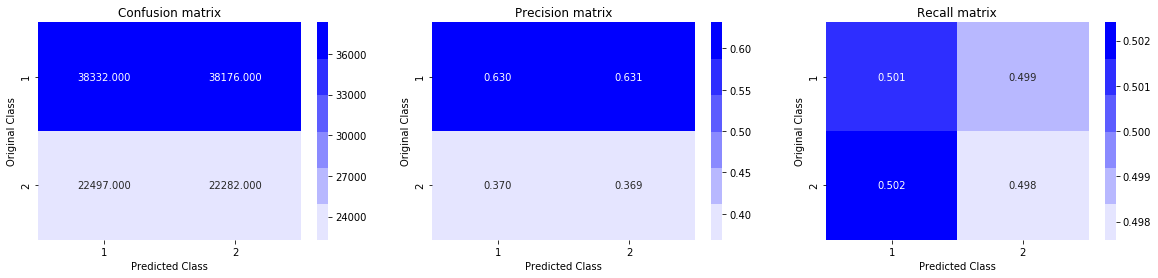

In [130]:
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039
# we create a output array that has exactly same size as the CV data
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)


## 4.5 Logistic Regression with hyperparameter tuning


For values of alpha =  1e-05 The log loss is: 0.4457532100781837
For values of alpha =  0.0001 The log loss is: 0.4437731879806291
For values of alpha =  0.001 The log loss is: 0.4562946696566922
For values of alpha =  0.01 The log loss is: 0.4343649870932145
For values of alpha =  0.1 The log loss is: 0.4522086464571665
For values of alpha =  1 The log loss is: 0.4872552277764656
For values of alpha =  10 The log loss is: 0.5331507481290368


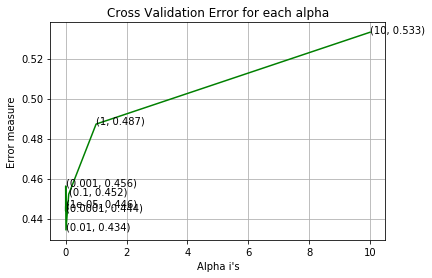

For values of best alpha =  0.01 The train log loss is: 0.4335071970267326
For values of best alpha =  0.01 The test log loss is: 0.4343649870932145
Total number of data points : 121287


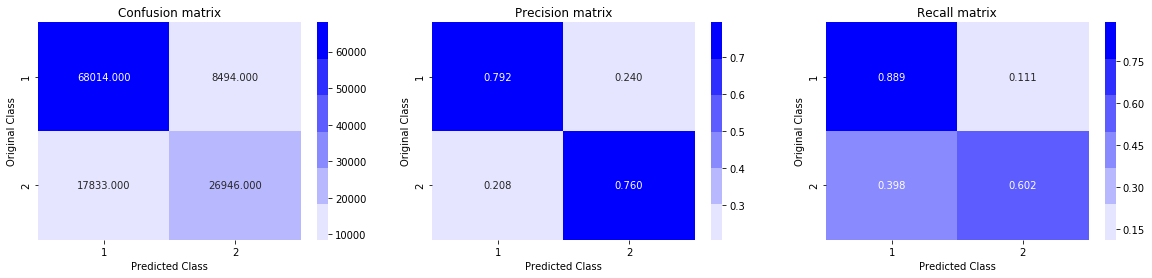

In [131]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y,eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y,eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)


SGD is sensitive to feature scaling, so did scaling and tried.



In [132]:
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()
X_train_sc = scale.fit_transform(X_train)
X_test_sc = scale.transform(X_test)


For values of alpha =  1e-05 The log loss is: 0.4249222644941107
For values of alpha =  0.0001 The log loss is: 0.4089803766917339
For values of alpha =  0.001 The log loss is: 0.4077814194015627
For values of alpha =  0.01 The log loss is: 0.41886195018610756
For values of alpha =  0.1 The log loss is: 0.4561677270100005
For values of alpha =  1 The log loss is: 0.5049867878342587
For values of alpha =  10 The log loss is: 0.546997061187054


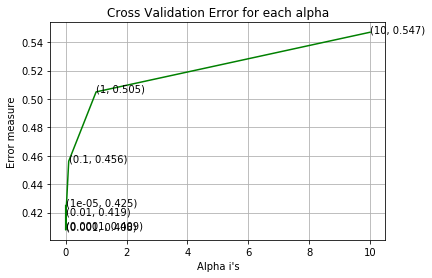

For values of best alpha =  0.001 The train log loss is: 0.4051386904696093
For values of best alpha =  0.001 The test log loss is: 0.4077814194015627
Total number of data points : 121287


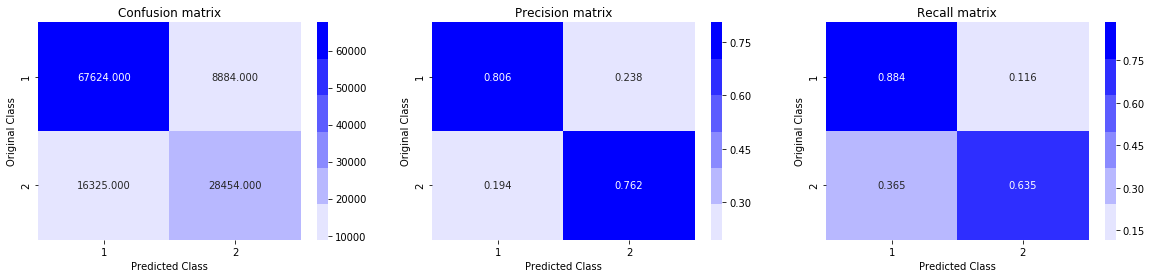

In [133]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.
log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train_sc, y_train)
    predict_y = sig_clf.predict_proba(X_test_sc)
    log_error_array.append(log_loss(y_test, predict_y, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_sc, y_train)

predict_y = sig_clf.predict_proba(X_train_sc)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y,eps=1e-15))
predict_y = sig_clf.predict_proba(X_test_sc)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y,eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

For values of alpha =  0.000862 The log loss is: 0.40885745257838246
For values of alpha =  0.001017 The log loss is: 0.40763681324015394
For values of alpha =  0.001226 The log loss is: 0.40723952255926554
For values of alpha =  0.001482 The log loss is: 0.4071373318674848
For values of alpha =  0.00212 The log loss is: 0.40825228899039945
For values of alpha =  0.003 The log loss is: 0.40964911956180755
For values of alpha =  0.00314 The log loss is: 0.40986798394214147
For values of alpha =  0.003153 The log loss is: 0.40988822157111754
For values of alpha =  0.003568 The log loss is: 0.41036339154932877
For values of alpha =  0.003988 The log loss is: 0.4110903082103961
For values of alpha =  0.004111 The log loss is: 0.4112697498386388
For values of alpha =  0.005223 The log loss is: 0.4128720557548429
For values of alpha =  0.005941 The log loss is: 0.41386886357851776
For values of alpha =  0.00595 The log loss is: 0.41388113877710536


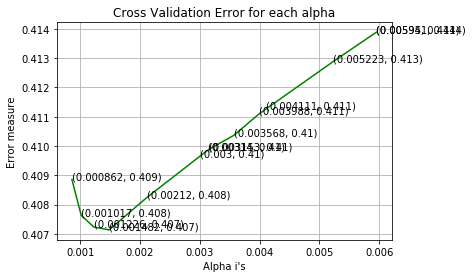

For values of best alpha =  0.001482 The train log loss is: 0.4044878315753182
For values of best alpha =  0.001482 The test log loss is: 0.4071373318674848
Total number of data points : 121287


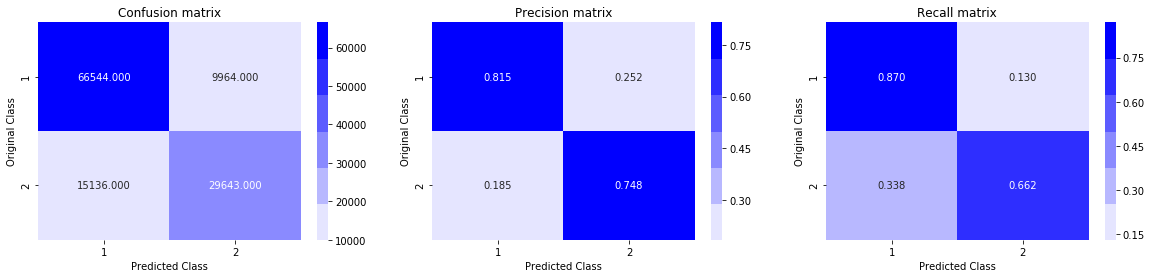

In [134]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.
np.random.seed(45)
alpha = np.random.uniform(0.0006,0.006,14)
alpha = np.round(alpha,6)
alpha.sort()
log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train_sc, y_train)
    predict_y = sig_clf.predict_proba(X_test_sc)
    log_error_array.append(log_loss(y_test, predict_y, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_sc, y_train)

predict_y = sig_clf.predict_proba(X_train_sc)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y,eps=1e-15))
predict_y = sig_clf.predict_proba(X_test_sc)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y,eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)


## 4.6 Linear SVM with hyperparameter tuning


For values of alpha =  1e-05 The log loss is: 0.41838311998718836
For values of alpha =  0.0001 The log loss is: 0.41045499375456
For values of alpha =  0.001 The log loss is: 0.41178910221446524
For values of alpha =  0.01 The log loss is: 0.4233825228698565
For values of alpha =  0.1 The log loss is: 0.5162552584782227
For values of alpha =  1 The log loss is: 0.6585278256293297
For values of alpha =  10 The log loss is: 0.6585278256293303


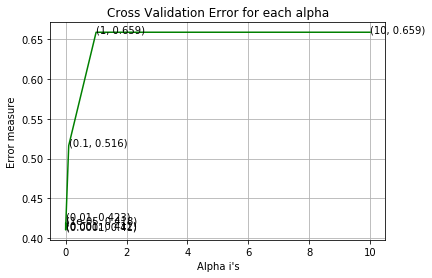

For values of best alpha =  0.0001 The train log loss is: 0.4090065786193422
For values of best alpha =  0.0001 The test log loss is: 0.41045499375456
Total number of data points : 121287


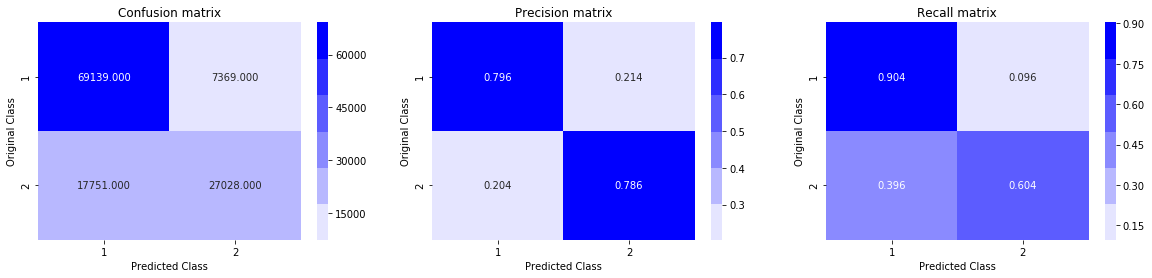

In [135]:
#Consider l1 panality
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.
log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train_sc, y_train)
    predict_y = sig_clf.predict_proba(X_test_sc)
    log_error_array.append(log_loss(y_test, predict_y,eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y,eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_sc, y_train)

predict_y = sig_clf.predict_proba(X_train_sc)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y,eps=1e-15))
predict_y = sig_clf.predict_proba(X_test_sc)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y,eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

For values of alpha =  1e-05 The log loss is: 0.4142141833103606
For values of alpha =  0.0001 The log loss is: 0.4110724743824499
For values of alpha =  0.001 The log loss is: 0.41224153213550785
For values of alpha =  0.01 The log loss is: 0.41440522493014104
For values of alpha =  0.1 The log loss is: 0.4451498563794295
For values of alpha =  1 The log loss is: 0.48542354472320076
For values of alpha =  10 The log loss is: 0.545516007767712


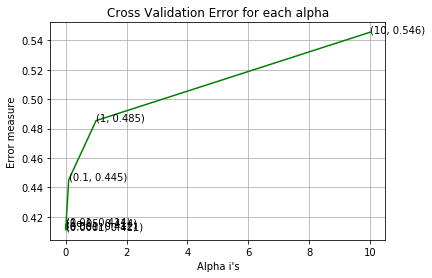

For values of best alpha =  0.0001 The train log loss is: 0.4090065786193422
For values of best alpha =  0.0001 The test log loss is: 0.41045499375456
Total number of data points : 121287


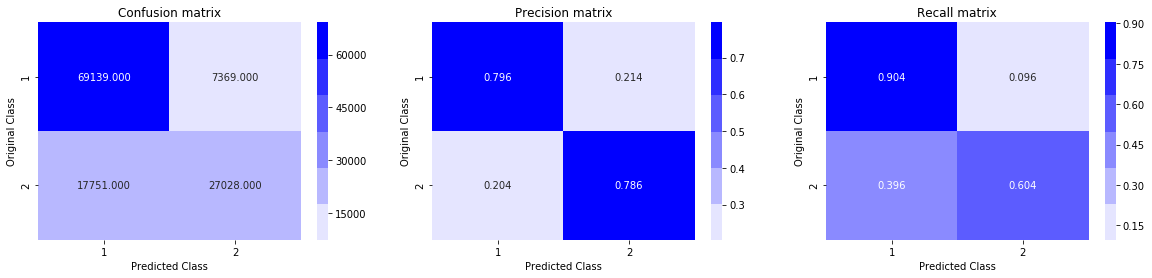

In [136]:
#Consider l2 penality
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.
log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='hinge', random_state=42)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train_sc, y_train)
    predict_y = sig_clf.predict_proba(X_test_sc)
    log_error_array.append(log_loss(y_test, predict_y,eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y,eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_sc, y_train)

predict_y = sig_clf.predict_proba(X_train_sc)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y,eps=1e-15))
predict_y = sig_clf.predict_proba(X_test_sc)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y,eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

For values of alpha =  0.00517 The log loss is: 0.4111337400419503
For values of alpha =  0.00529 The log loss is: 0.41122726425950507
For values of alpha =  0.00721 The log loss is: 0.4125808766616069
For values of alpha =  0.00981 The log loss is: 0.4142284147636377
For values of alpha =  0.01228 The log loss is: 0.41616933916887916
For values of alpha =  0.01327 The log loss is: 0.41716104644902163
For values of alpha =  0.01351 The log loss is: 0.4173309613771614
For values of alpha =  0.01425 The log loss is: 0.4177945432906255
For values of alpha =  0.01452 The log loss is: 0.41805157847754126
For values of alpha =  0.01757 The log loss is: 0.4200374697439882
For values of alpha =  0.0183 The log loss is: 0.4204472273772195
For values of alpha =  0.01839 The log loss is: 0.4205100079676086
For values of alpha =  0.02118 The log loss is: 0.4221264362573611
For values of alpha =  0.02636 The log loss is: 0.4248545023809321


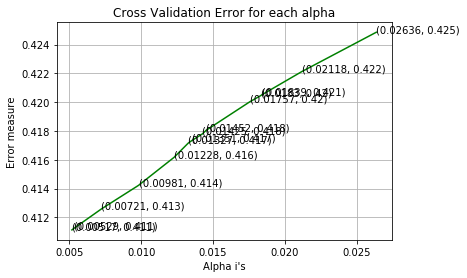

For values of best alpha =  0.00517 The train log loss is: 0.4083648975122767
For values of best alpha =  0.00517 The test log loss is: 0.4111337400419503
Total number of data points : 121287


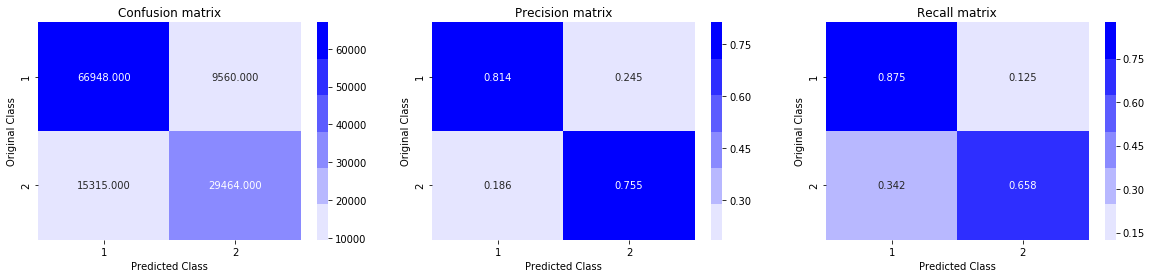

In [137]:
#consider uniform alpha with l2 penality
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.
np.random.seed(25)
alpha = np.random.uniform(0.002,0.03,14)
alpha = np.round(alpha,5)
alpha.sort()
log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='hinge', random_state=42)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train_sc, y_train)
    predict_y = sig_clf.predict_proba(X_test_sc)
    log_error_array.append(log_loss(y_test, predict_y,eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y,eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_sc, y_train)

predict_y = sig_clf.predict_proba(X_train_sc)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y,eps=1e-15))
predict_y = sig_clf.predict_proba(X_test_sc)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y,eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)


## 9.4 Random Forest with hyperparameter tuning

In [138]:
from sklearn.ensemble import RandomForestClassifier as RFC


We are going to see results for different hyperparameters e.g. estimetor,depth,e.t.c.

estimators =  100 Train Log Loss  0.10297023251700255 Test Log Loss  0.35223047948550607
estimators =  150 Train Log Loss  0.10291795785403521 Test Log Loss  0.3512472889330629
estimators =  200 Train Log Loss  0.10284862254286402 Test Log Loss  0.35055143626853835
estimators =  300 Train Log Loss  0.10276813260943565 Test Log Loss  0.35071872172172514
estimators =  400 Train Log Loss  0.10279137712789646 Test Log Loss  0.3501182277198549
estimators =  600 Train Log Loss  0.10258177754092322 Test Log Loss  0.3495942161337735
estimators =  800 Train Log Loss  0.10265969737151312 Test Log Loss  0.3496666087688474


Text(0, 0.5, 'Log Loss')

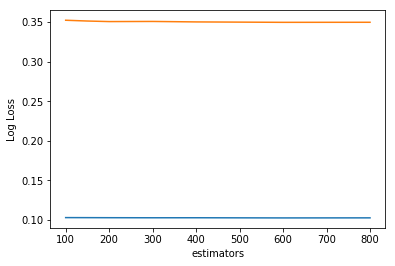

In [140]:
#see rresults for hyperparameter estimators
estimators = [100,150,200,300,400,600,800]
test_scores = []
train_scores = []
for i in estimators:
    clf = RFC(n_estimators=i,n_jobs=-1)
    clf.fit(X_train,y_train)
    predict_y = clf.predict_proba(X_train)
    log_loss_train = log_loss(y_train, predict_y, eps=1e-15)
    train_scores.append(log_loss_train)
    predict_y = clf.predict_proba(X_test)
    log_loss_test = log_loss(y_test, predict_y, eps=1e-15)
    test_scores.append(log_loss_test)
    print('estimators = ',i,'Train Log Loss ',log_loss_train,'Test Log Loss ',log_loss_test)
plt.plot(estimators,train_scores,label='Train Log Loss')
plt.plot(estimators,test_scores,label='Test Log Loss')
plt.xlabel('estimators') 
plt.ylabel('Log Loss')

Depth =  5 Train Log Loss  0.45159112932413586 Test Log Loss  0.4524548976453627
Depth =  10 Train Log Loss  0.3796710146571229 Test Log Loss  0.3927493400719944
Depth =  12 Train Log Loss  0.3520673561689778 Test Log Loss  0.3818417322412174
Depth =  15 Train Log Loss  0.29525594883064016 Test Log Loss  0.36630007947404253
Depth =  20 Train Log Loss  0.19831304124388457 Test Log Loss  0.3541653290301739
Depth =  25 Train Log Loss  0.13684369193828416 Test Log Loss  0.35262815226831795
Depth =  50 Train Log Loss  0.10313401815824241 Test Log Loss  0.3519024220778154


Text(0, 0.5, 'Log Loss')

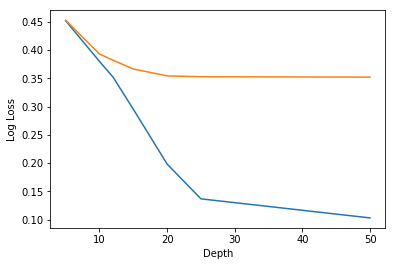

In [141]:
#see results for hyperparameter depth
Depth = [5,10,12,15,20,25,50]
test_scores = []
train_scores = []
for i in Depth:
    clf = RFC(n_estimators=100,max_depth=i,n_jobs=-1)
    clf.fit(X_train,y_train)
    predict_y = clf.predict_proba(X_train)
    log_loss_train = log_loss(y_train, predict_y, eps=1e-15)
    train_scores.append(log_loss_train)
    predict_y = clf.predict_proba(X_test)
    log_loss_test = log_loss(y_test, predict_y, eps=1e-15)
    test_scores.append(log_loss_test)
    print('Depth = ',i,'Train Log Loss ',log_loss_train,'Test Log Loss ',log_loss_test)
plt.plot(Depth,train_scores,label='Train Log Loss')
plt.plot(Depth,test_scores,label='Test Log Loss')
plt.xlabel('Depth') 
plt.ylabel('Log Loss')

estimators =  100 Train Log Loss  0.36741403596130934 Test Log Loss  0.3878890370555127
estimators =  150 Train Log Loss  0.3676434392186453 Test Log Loss  0.38771261466614126
estimators =  200 Train Log Loss  0.3675904637780903 Test Log Loss  0.38790564362033364
estimators =  300 Train Log Loss  0.36636976352520817 Test Log Loss  0.38671857457975517
estimators =  400 Train Log Loss  0.366564022829904 Test Log Loss  0.3867786171863733
estimators =  600 Train Log Loss  0.3658938294929212 Test Log Loss  0.3861438580424183
estimators =  800 Train Log Loss  0.36559998519241377 Test Log Loss  0.38589713810994763


Text(0, 0.5, 'Log Loss')

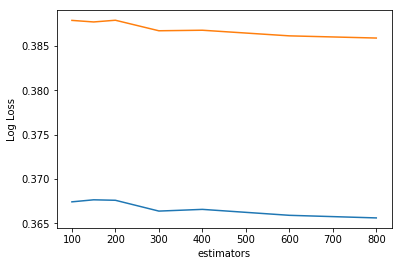

In [142]:
# see results for both hyperparameter estimetors and depth combined
estimators = [100,150,200,300,400,600,800]
test_scores = []
train_scores = []
for i in estimators:
    clf = RFC(n_estimators=i,max_depth=11,n_jobs=-1)
    clf.fit(X_train,y_train)
    predict_y = clf.predict_proba(X_train)
    log_loss_train = log_loss(y_train, predict_y, eps=1e-15)
    train_scores.append(log_loss_train)
    predict_y = clf.predict_proba(X_test)
    log_loss_test = log_loss(y_test, predict_y, eps=1e-15)
    test_scores.append(log_loss_test)
    print('estimators = ',i,'Train Log Loss ',log_loss_train,'Test Log Loss ',log_loss_test)
plt.plot(estimators,train_scores,label='Train Log Loss')
plt.plot(estimators,test_scores,label='Test Log Loss')
plt.xlabel('estimators') 
plt.ylabel('Log Loss')

## 9.5 XGBoost with hyperparameter tuning

In [145]:
import xgboost as xgb

Analyzing the result for different hyperparameters.

estimators =  100 Train Log Loss  0.3594552145813599 Test Log Loss  0.3624963885467871
estimators =  150 Train Log Loss  0.3483443096920713 Test Log Loss  0.3525056530708697
estimators =  200 Train Log Loss  0.3416341223240644 Test Log Loss  0.3467205483091866
estimators =  300 Train Log Loss  0.3331778711189421 Test Log Loss  0.3402038853583039
estimators =  400 Train Log Loss  0.3274190135004331 Test Log Loss  0.3364215456472551
estimators =  600 Train Log Loss  0.31877544454040185 Test Log Loss  0.3317697291562803
estimators =  800 Train Log Loss  0.31232615305080774 Test Log Loss  0.32916976324448854


Text(0, 0.5, 'Log Loss')

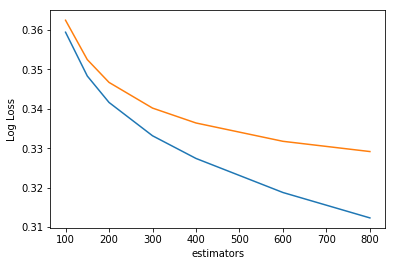

In [147]:
#Analyzing the result for different estimators
estimators = [100,150,200,300,400,600,800]
test_scores = []
train_scores = []
for i in estimators:
    clf = xgb.XGBClassifier(max_depth=3,learning_rate=0.1,n_estimators=i,n_jobs=-1)
    clf.fit(X_train,y_train)
    predict_y = clf.predict_proba(X_train)
    log_loss_train = log_loss(y_train, predict_y, eps=1e-15)
    train_scores.append(log_loss_train)
    predict_y = clf.predict_proba(X_test)
    log_loss_test = log_loss(y_test, predict_y, eps=1e-15)
    test_scores.append(log_loss_test)
    print('estimators = ',i,'Train Log Loss ',log_loss_train,'Test Log Loss ',log_loss_test)
plt.plot(estimators,train_scores,label='Train Log Loss')
plt.plot(estimators,test_scores,label='Test Log Loss')
plt.xlabel('estimators')
plt.ylabel('Log Loss')

Learning Rate =  0.05 Train Log Loss  0.344941359179685 Test Log Loss  0.34957916200480393
Learning Rate =  0.1 Train Log Loss  0.3300151092457925 Test Log Loss  0.33798369095244074
Learning Rate =  0.15 Train Log Loss  0.32159004876174296 Test Log Loss  0.3335962408811512
Learning Rate =  0.2 Train Log Loss  0.3155543653099069 Test Log Loss  0.33107863819666267
Learning Rate =  0.25 Train Log Loss  0.31053131139204326 Test Log Loss  0.3294381947540776
Learning Rate =  0.3 Train Log Loss  0.3060768034286396 Test Log Loss  0.3289843689849386


Text(0, 0.5, 'Log Loss')

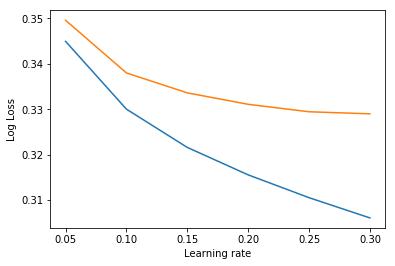

In [148]:
# analyzing the result for hyperparameter etas
test_scores = []
train_scores = []
etas = [0.05,0.1,0.15,0.2,0.25,0.3]
for i in etas:
    clf = xgb.XGBClassifier(max_depth=3,learning_rate=i,n_estimators=350,n_jobs=-1)
    clf.fit(X_train,y_train)
    predict_y = clf.predict_proba(X_train)
    log_loss_train = log_loss(y_train, predict_y, eps=1e-15)
    train_scores.append(log_loss_train)
    predict_y = clf.predict_proba(X_test)
    log_loss_test = log_loss(y_test, predict_y, eps=1e-15)
    test_scores.append(log_loss_test)
    print('Learning Rate = ',i,'Train Log Loss ',log_loss_train,'Test Log Loss ',log_loss_test)
plt.plot(etas,train_scores,label='Train Log Loss')
plt.plot(etas,test_scores,label='Test Log Loss')
plt.xlabel('Learning rate')
plt.ylabel('Log Loss')

reg_alpha =  0.5 Train Log Loss  0.2836588112367842 Test Log Loss  0.33457943399440027
reg_alpha =  1 Train Log Loss  0.28313805271071374 Test Log Loss  0.3331915171934615
reg_alpha =  5 Train Log Loss  0.28397994380142055 Test Log Loss  0.33152424427599675
reg_alpha =  10 Train Log Loss  0.2851825143095793 Test Log Loss  0.33035480361830316
reg_alpha =  50 Train Log Loss  0.2944169971499697 Test Log Loss  0.3291707245898081
reg_alpha =  100 Train Log Loss  0.30406629021775883 Test Log Loss  0.33040688652814604
reg_alpha =  150 Train Log Loss  0.31949823673828454 Test Log Loss  0.33492736394903877


Text(0, 0.5, 'Log Loss')

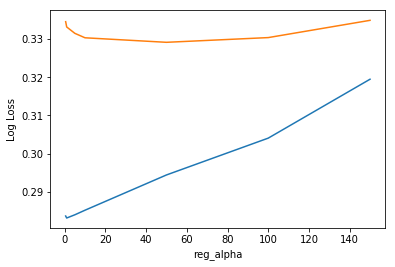

In [149]:
#Analyzing the result for different alphas
test_scores = []
train_scores = []
alpha = [0.5,1,5,10,50,100,150]
for i in alpha:
    clf = xgb.XGBClassifier(max_depth=3,learning_rate=0.65,n_estimators=370,reg_alpha=i,n_jobs=-1)
    clf.fit(X_train,y_train)
    predict_y = clf.predict_proba(X_train)
    log_loss_train = log_loss(y_train, predict_y, eps=1e-15)
    train_scores.append(log_loss_train)
    predict_y = clf.predict_proba(X_test)
    log_loss_test = log_loss(y_test, predict_y, eps=1e-15)
    test_scores.append(log_loss_test)
    print('reg_alpha = ',i,'Train Log Loss ',log_loss_train,'Test Log Loss ',log_loss_test)
plt.plot(alpha,train_scores,label='Train Log Loss')
plt.plot(alpha,test_scores,label='Test Log Loss')
plt.xlabel('reg_alpha')
plt.ylabel('Log Loss')

The test log loss is: 0.36850975737121533


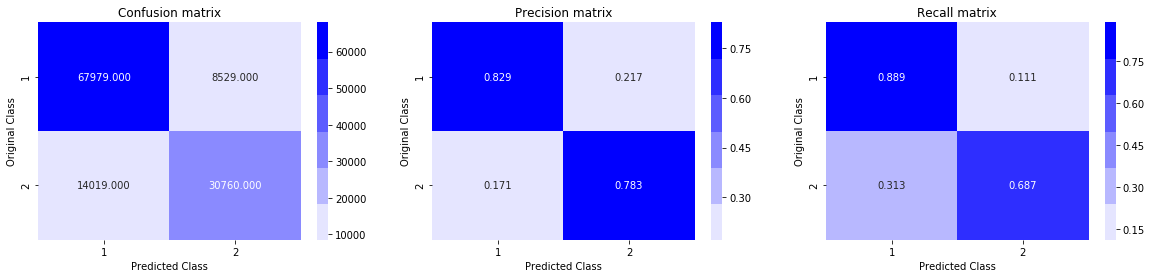

In [150]:
import xgboost as xgb
clf = xgb.XGBClassifier(max_depth=3,learning_rate=0.02,n_estimators=400,n_jobs=-1)
clf.fit(X_train,y_train)
predict_y = clf.predict_proba(X_test)
print("The test log loss is:",log_loss(y_test, predict_y, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
plot_confusion_matrix(y_test, predicted_y)


Sampled data and did further hyperparam truning because of time constraints.


In [151]:
# try to sample data according to the computing power we have
if os.path.isfile(read_db):
    conn_r = create_connection(read_db)
    if conn_r is not None:
        # for selecting first 1M rows
        # data = pd.read_sql_query("""SELECT * FROM data LIMIT 100001;""", conn_r)
        
        # for selecting random points
        data = pd.read_sql_query("SELECT * From data LIMIT 100001;", conn_r)
        conn_r.commit()
        conn_r.close()

In [153]:
# remove the first row 
data.drop(data.index[0], inplace=True)
y_true = data['is_duplicate']
data.drop(['Unnamed: 0', 'id','is_duplicate'], axis=1, inplace=True)

In [154]:
# after we read from sql table each entry was read it as a string
# we convert all the features into numaric before we apply any model
cols = list(data.columns)
data = pd.DataFrame(np.array(data.values,dtype=np.float64),columns=cols)


In [155]:
y_true = list(map(int, y_true.values))

In [156]:
X_train,X_test, y_train, y_test = train_test_split(data, y_true, stratify=y_true, test_size=0.3,random_state=13)

In [157]:
print("Number of data points in train data :",X_train.shape)
print("Number of data points in test data :",X_test.shape)

Number of data points in train data : (69999, 218)
Number of data points in test data : (30000, 218)


estimators =  100 Train Log Loss  0.35820506790205303 Test Log Loss  0.3659005378271162
estimators =  150 Train Log Loss  0.34516733728230287 Test Log Loss  0.356600762669225
estimators =  200 Train Log Loss  0.3363731635814967 Test Log Loss  0.35166136331614567
estimators =  300 Train Log Loss  0.3232553260423806 Test Log Loss  0.34603131188612773
estimators =  400 Train Log Loss  0.3132012475386186 Test Log Loss  0.3431944638782166
estimators =  600 Train Log Loss  0.29575841953673454 Test Log Loss  0.339837151704891
estimators =  800 Train Log Loss  0.28063265129693926 Test Log Loss  0.33877108915229837


Text(0, 0.5, 'Log Loss')

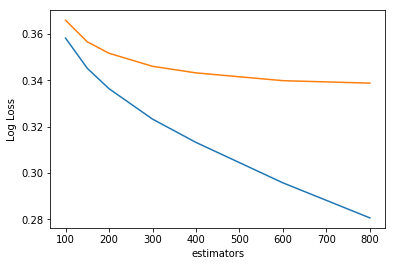

In [158]:
estimators = [100,150,200,300,400,600,800]
test_scores = []
train_scores = []
for i in estimators:
    clf = xgb.XGBClassifier(max_depth=3,learning_rate=0.1,n_estimators=i,n_jobs=-1)
    clf.fit(X_train,y_train)
    predict_y = clf.predict_proba(X_train)
    log_loss_train = log_loss(y_train, predict_y, eps=1e-15)
    train_scores.append(log_loss_train)
    predict_y = clf.predict_proba(X_test)
    log_loss_test = log_loss(y_test, predict_y, eps=1e-15)
    test_scores.append(log_loss_test)
    print('estimators = ',i,'Train Log Loss ',log_loss_train,'Test Log Loss ',log_loss_test)
plt.plot(estimators,train_scores,label='Train Log Loss')
plt.plot(estimators,test_scores,label='Test Log Loss')
plt.xlabel('estimators')
plt.ylabel('Log Loss')

Learning Rate =  0.05 Train Log Loss  0.35167706756893424 Test Log Loss  0.361012905825043
Learning Rate =  0.1 Train Log Loss  0.32942022837695345 Test Log Loss  0.348429654143883
Learning Rate =  0.15 Train Log Loss  0.31572467950681193 Test Log Loss  0.3448126074288621
Learning Rate =  0.2 Train Log Loss  0.3042716201447075 Test Log Loss  0.3426382014592481
Learning Rate =  0.25 Train Log Loss  0.2944788671407479 Test Log Loss  0.3418975599002057
Learning Rate =  0.3 Train Log Loss  0.2854682615153727 Test Log Loss  0.344797193662442


Text(0, 0.5, 'Log Loss')

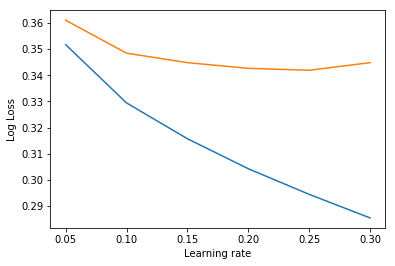

In [159]:
test_scores = []
train_scores = []
etas = [0.05,0.1,0.15,0.2,0.25,0.3]
for i in etas:
    clf = xgb.XGBClassifier(max_depth=3,learning_rate=i,n_estimators=250,n_jobs=-1)
    clf.fit(X_train,y_train)
    predict_y = clf.predict_proba(X_train)
    log_loss_train = log_loss(y_train, predict_y, eps=1e-15)
    train_scores.append(log_loss_train)
    predict_y = clf.predict_proba(X_test)
    log_loss_test = log_loss(y_test, predict_y, eps=1e-15)
    test_scores.append(log_loss_test)
    print('Learning Rate = ',i,'Train Log Loss ',log_loss_train,'Test Log Loss ',log_loss_test)
plt.plot(etas,train_scores,label='Train Log Loss')
plt.plot(etas,test_scores,label='Test Log Loss')
plt.xlabel('Learning rate')
plt.ylabel('Log Loss')

reg_alpha =  0.5 Train Log Loss  0.21616064805359536 Test Log Loss  0.41282637345189116
reg_alpha =  1 Train Log Loss  0.21530346999375233 Test Log Loss  0.40548901288359906
reg_alpha =  5 Train Log Loss  0.21987103770272406 Test Log Loss  0.3952447951563241
reg_alpha =  10 Train Log Loss  0.22617132114535263 Test Log Loss  0.38606816233610214
reg_alpha =  50 Train Log Loss  0.27111188646529527 Test Log Loss  0.36072342964379084
reg_alpha =  100 Train Log Loss  0.3323034654713759 Test Log Loss  0.3575591996481788
reg_alpha =  150 Train Log Loss  0.356383706341897 Test Log Loss  0.36757481438585865


Text(0, 0.5, 'Log Loss')

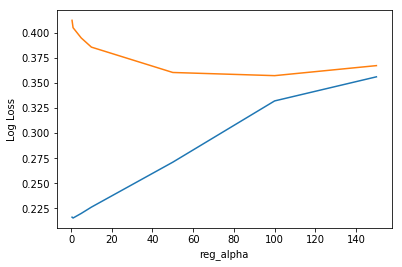

In [160]:
test_scores = []
train_scores = []
alpha = [0.5,1,5,10,50,100,150]
for i in alpha:
    clf = xgb.XGBClassifier(max_depth=3,learning_rate=0.95,n_estimators=250,reg_alpha=i,n_jobs=-1)
    clf.fit(X_train,y_train)
    predict_y = clf.predict_proba(X_train)
    log_loss_train = log_loss(y_train, predict_y, eps=1e-15)
    train_scores.append(log_loss_train)
    predict_y = clf.predict_proba(X_test)
    log_loss_test = log_loss(y_test, predict_y, eps=1e-15)
    test_scores.append(log_loss_test)
    print('reg_alpha = ',i,'Train Log Loss ',log_loss_train,'Test Log Loss ',log_loss_test)
plt.plot(alpha,train_scores,label='Train Log Loss')
plt.plot(alpha,test_scores,label='Test Log Loss')
plt.xlabel('reg_alpha')
plt.ylabel('Log Loss')

In [192]:
from sklearn.model_selection import RandomizedSearchCV
param_grid = {"max_depth":[1,5,10,50,100,500,1000],
              "n_estimators":[50,100,150,200,300,400,500]}

model = RandomizedSearchCV(xgb.XGBClassifier(n_jobs=-1,random_state=25), param_distributions=param_grid,n_iter=30,scoring='neg_log_loss',cv=3,n_jobs=-1)

model.fit(X_train,y_train)
model.best_params_

{'n_estimators': 500, 'max_depth': 5}

The test log loss is: 0.3644918919094605


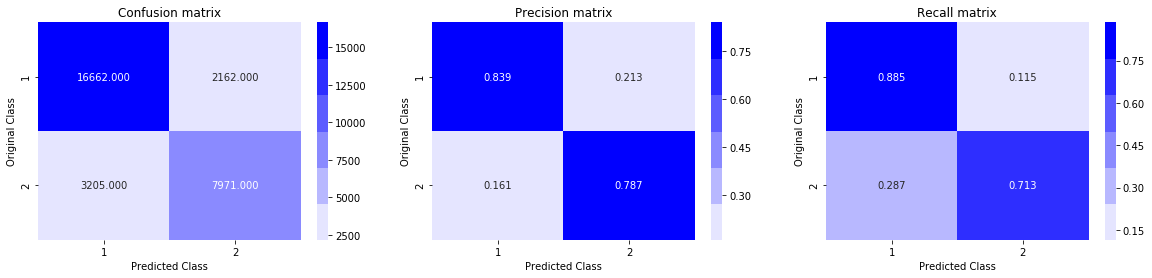

In [195]:
import xgboost as xgb
clf = xgb.XGBClassifier(max_depth=4,learning_rate=0.078998,n_estimators=312,
                        min_child_weight=7,subsample=0.862849,
                        reg_alpha=151.329530,reg_lambda=368.527334,
                        colsample_bytree=0.889555,gamma=2.475153,n_jobs=-1)
clf.fit(X_train,y_train)
predict_y = clf.predict_proba(X_test)
print("The test log loss is:",log_loss(y_test, predict_y, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
plot_confusion_matrix(y_test, predicted_y)

In [6]:
from prettytable import PrettyTable    
x = PrettyTable()
x.field_names = ["Model","vectorizer","log loss"]
x.add_row(['Logistic regression','TFIDF w2vec','0.4071'])
x.add_row(['Linear SVM','TFIDF w2vec','0.4111'])
x.add_row(['Random Forest','TFIDF w2vec','0.3858'])
x.add_row(['XGBOOST','TFIDF w2vec','0.3644'])
print(x)

+---------------------+-------------+----------+
|        Model        |  vectorizer | log loss |
+---------------------+-------------+----------+
| Logistic regression | TFIDF w2vec |  0.4071  |
|      Linear SVM     | TFIDF w2vec |  0.4111  |
|    Random Forest    | TFIDF w2vec |  0.3858  |
|       XGBOOST       | TFIDF w2vec |  0.3644  |
+---------------------+-------------+----------+
